### Import packages

In [1]:
import time
import pickle
import itertools
import numpy as np
import pandas as pd
#import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from utilities import *

In [2]:
model_name = 'model-02-keras-search'

### Params

In [3]:
is_log_target = True
is_per_area_target = True
is_embedding = True
is_tar_encoded = False
fix_town_and_city = False
rare_village_threshold = 2
rare_town_threshold = 2

map_target = {
    (True, True):   'log_per_area_total_price',
    (True, False):  'log_total_price',
    (False, True):  'per_area_total_price',
    (False, False): 'total_price'
}
col_target = map_target[(is_log_target, is_per_area_target)]
cols_num_add = ['land_per_building_area']
cols_cat_add = ['encoded_latlon']
cols_bin_add = []

#['day_in_year_txn_dt', 'day_in_year_building_complete_dt', 'dt_diff_building_complete_dt_txn_dt'] # dt num feats
#['dow_txn_dt', 'dow_building_complete_dt', 'month_txn_dt', 'month_building_complete_dt',
# 'quarter_txn_dt', 'quarter_building_complete_dt', 'year_txn_dt', 'year_building_complete_dt'] # dt cat feats

print('Target:', col_target)

Target: log_per_area_total_price


In [4]:
# Feature remove
# PARS #
N_feats_rm = 67
# PARS #

from vars_03 import score_base_per_area, shuffle_results_per_area

feat_imp = pd.DataFrame({'feats': shuffle_results_per_area[:,0],'avg':shuffle_results_per_area[:,1]})
feat_imp['diff'] = feat_imp['avg'] - score_base_per_area
feat_imp = feat_imp.sort_values(by='diff', ascending=False)
print(feat_imp.reset_index().values)

feats_rm = list(feat_imp.iloc[:(N_feats_rm+1)]['feats'].values)
feats_rm.remove('none')
print(len(feats_rm))
print(feats_rm)

[[0 5709.20035 'divorce_rate' 3.333296666667593]
 [1 5709.200316666666 'I_250' 3.333263333333889]
 [2 5708.200346666667 'XI_100' 2.33329333333495]
 [3 5707.867050000001 'VI_index_500' 1.9999966666682667]
 [4 5707.86704 'IX_index_50' 1.9999866666676098]
 [5 5707.866983333333 'VI_500' 1.9999300000008589]
 [6 5707.533710000001 'XIV_10' 1.666656666668132]
 [7 5707.200386666666 'XI_index_500' 1.3333333333339397]
 [8 5707.200383333334 'VI_index_1000' 1.3333300000012969]
 [9 5707.200373333333 'V_100' 1.33332000000064]
 [10 5707.200363333334 'VII_10' 1.333310000001802]
 [11 5707.200336666666 'X_100' 1.3332833333333838]
 [12 5706.867056666667 'XII_index_50' 1.0000033333344618]
 [15 5706.867050000001 'X_index_500' 0.9999966666682667]
 [14 5706.867050000001 'X_10' 0.9999966666682667]
 [13 5706.867050000001 'II_10' 0.9999966666682667]
 [16 5706.867046666666 'II_index_500' 0.9999933333338049]
 [17 5706.867046666666 'V_index_1000' 0.9999933333338049]
 [18 5706.867043333335 'XIII_10' 0.99999000000207

### Columns

In [5]:
cols_num = ['txn_dt', 'total_floor', 'building_complete_dt', 'parking_area', 'parking_price', 'txn_floor', 'land_area', 'building_area', 'lat', 'lon', 'village_income_median', 'town_population', 'town_area', 'town_population_density', 'doc_rate', 'master_rate', 'bachelor_rate', 'jobschool_rate', 'highschool_rate', 'junior_rate', 'elementary_rate', 'born_rate', 'death_rate', 'marriage_rate', 'divorce_rate', 'N_50', 'N_500', 'N_1000', 'N_5000', 'N_10000', 'I_10', 'I_50', 'I_100', 'I_250', 'I_500', 'I_1000', 'I_5000', 'I_10000', 'I_MIN', 'II_10', 'II_50', 'II_100', 'II_250', 'II_500', 'II_1000', 'II_5000', 'II_10000', 'II_MIN', 'III_10', 'III_50', 'III_100', 'III_250', 'III_500', 'III_1000', 'III_5000', 'III_10000', 'III_MIN', 'IV_10', 'IV_50', 'IV_100', 'IV_250', 'IV_500', 'IV_1000', 'IV_5000', 'IV_10000', 'IV_MIN', 'V_10', 'V_50', 'V_100', 'V_250', 'V_500', 'V_1000', 'V_5000', 'V_10000', 'V_MIN', 'VI_50', 'VI_100', 'VI_250', 'VI_500', 'VI_1000', 'VI_5000', 'VI_10000', 'VI_MIN', 'VII_10', 'VII_50', 'VII_100', 'VII_250', 'VII_500', 'VII_1000', 'VII_5000', 'VII_10000', 'VII_MIN', 'VIII_10', 'VIII_50', 'VIII_100', 'VIII_250', 'VIII_500', 'VIII_1000', 'VIII_5000', 'VIII_10000', 'VIII_MIN', 'IX_10', 'IX_50', 'IX_100', 'IX_250', 'IX_500', 'IX_1000', 'IX_5000', 'IX_10000', 'IX_MIN', 'X_10', 'X_50', 'X_100', 'X_250', 'X_500', 'X_1000', 'X_5000', 'X_10000', 'X_MIN', 'XI_10', 'XI_50', 'XI_100', 'XI_250', 'XI_500', 'XI_1000', 'XI_5000', 'XI_10000', 'XI_MIN', 'XII_10', 'XII_50', 'XII_100', 'XII_250', 'XII_500', 'XII_1000', 'XII_5000', 'XII_10000', 'XII_MIN', 'XIII_10', 'XIII_50', 'XIII_100', 'XIII_250', 'XIII_500', 'XIII_1000', 'XIII_5000', 'XIII_10000', 'XIII_MIN', 'XIV_10', 'XIV_50', 'XIV_100', 'XIV_250', 'XIV_500', 'XIV_1000', 'XIV_5000', 'XIV_10000', 'XIV_MIN']
cols_bin = ['I_index_50', 'I_index_500', 'I_index_1000', 'II_index_50', 'II_index_500', 'II_index_1000', 'III_index_50', 'III_index_500', 'III_index_1000', 'IV_index_50', 'IV_index_500', 'IV_index_1000', 'IV_index_5000', 'V_index_50', 'V_index_500', 'V_index_1000', 'VI_10', 'VI_index_50', 'VI_index_500', 'VI_index_1000', 'VII_index_50', 'VII_index_500', 'VII_index_1000', 'VIII_index_50', 'VIII_index_500', 'VIII_index_1000', 'IX_index_50', 'IX_index_500', 'IX_index_1000', 'IX_index_5000', 'X_index_50', 'X_index_500', 'X_index_1000', 'XI_index_50', 'XI_index_500', 'XI_index_1000', 'XI_index_5000', 'XI_index_10000', 'XII_index_50', 'XII_index_500', 'XII_index_1000', 'XIII_index_50', 'XIII_index_500', 'XIII_index_1000', 'XIII_index_5000', 'XIII_index_10000', 'XIV_index_50', 'XIV_index_500', 'XIV_index_1000']
cols_cat = ['building_material', 'city', 'building_type', 'building_use', 'parking_way', 'town', 'village']

print('Total (before remove):', 
      len(cols_num)+len(cols_bin)+len(cols_cat)+len(cols_num_add)+len(cols_bin_add)+len(cols_cat_add))

cols_num = [c for c in cols_num if c not in feats_rm]
cols_bin = [c for c in cols_bin if c not in feats_rm]
cols_cat = [c for c in cols_cat if c not in feats_rm]

# informational cols
cols_dt = ['txn_dt', 'building_complete_dt']

# right skew cols
#cols_right_skew = ['parking_area', 'land_area', 'building_area']+[c for c in cols_num if 'MIN' in c]

print('Num:', len(cols_num), 'Bin:', len(cols_bin), 'Cat:', len(cols_cat))
print('Add:', len(cols_num_add), len(cols_bin_add), len(cols_cat_add), 
      'Total (after):', 
      len(cols_num)+len(cols_bin)+len(cols_cat)+len(cols_num_add)+len(cols_bin_add)+len(cols_cat_add))
#print('Right skew:', cols_right_skew)
#print('Total:', len(cols_feats))

Total (before remove): 213
Num: 130 Bin: 7 Cat: 7
Add: 1 0 1 Total (after): 146


### Read data

In [8]:
train = pd.read_csv('dataset/train.csv', dtype=object)
test = pd.read_csv('dataset/test.csv', dtype=object)
display(train.head(5))
display(test.head(5))

id_cv = []
for i in range(5):
    id_one_fold = pd.read_csv('dataset/id_cv'+str(i)+'.csv', dtype=object)['building_id']
    id_cv.append(id_one_fold)

,building_id,building_material,city,txn_dt,total_floor,building_type,building_use,building_complete_dt,parking_way,parking_area,...,XIV_500,XIV_index_500,XIV_1000,XIV_index_1000,XIV_5000,XIV_index_5000,XIV_10000,XIV_index_10000,XIV_MIN,total_price
0,e3mMIMR3JJqCaXz1,8,21,18674,4,3,2,6271,2,NaN,...,58,1,157,1,2483,1,6011,1,34.469802848528126,647603.7704719775
1,LgwzgklNvy4QCtq5,8,7,18800,5,1,2,7885,2,NaN,...,28,1,115,1,15872,1,32221,1,40.07357348973039,3321452.0
2,ucIR2NLLsC3T650L,8,7,19289,4,1,2,6028,2,NaN,...,78,1,212,1,15760,1,32228,1,54.46208108983661,9570885.316206373
3,jre1pJhcQj91Kdky,8,21,20385,24,0,2,18325,0,NaN,...,20,1,125,1,2568,1,7271,1,99.62896580763416,14215011.127100045
4,rQpYpY9nRG7X5mmr,1,21,20657,2,4,2,6880,2,NaN,...,18,1,47,1,2587,1,7442,1,124.1312362968124,762711.9757135696


,building_id,building_material,city,txn_dt,total_floor,building_type,building_use,building_complete_dt,parking_way,parking_area,...,XIV_250,XIV_500,XIV_index_500,XIV_1000,XIV_index_1000,XIV_5000,XIV_index_5000,XIV_10000,XIV_index_10000,XIV_MIN
0,X5gsdTWGS3W7JJQB,1,13,18634,2,4,2,1857,2,NaN,...,7,21,1,129,1,3991,1,8409,1,105.4622312795739
1,BTshNOJyKHnT2YIT,8,7,20199,10,3,2,16011,2,NaN,...,18,44,1,67,1,1950,1,10725,1,100.81980868401074
2,dhdymr0lV8N5kZOT,8,12,19769,4,4,10,18294,2,NaN,...,0,3,1,35,1,3707,1,19459,1,259.8005430183116
3,VEwyGGMcD56w5BOc,10,7,20479,19,2,0,17837,2,NaN,...,16,60,1,144,1,6487,1,29400,1,22.941906168328487
4,wmUeMoJZfsqaSX9b,8,3,18164,13,0,2,13272,2,NaN,...,4,18,1,76,1,1346,1,3280,1,181.21309507601745


### Preprocessing

In [9]:
def pre_processing(df, cols_num, cols_cat, cols_bin):
    """Preprocess (inplace) that are independent of train and validatoin set"""
    # Convert types
    df[cols_num] = df[cols_num].astype('float32')
    df[cols_bin] = df[cols_bin].astype('float32')
    df[cols_cat] = df[cols_cat].astype('int32')
    
    # target transform base (store this for inverse transform)
    if is_per_area_target:
        df['building_area_ori'] = df['building_area']
    
    # generate target
    if 'total_price' in df:
        df['total_price'] = df['total_price'].astype('float32')
        df['log_total_price'] = np.log1p(df['total_price'])
        df['per_area_total_price'] = df['total_price'] / df['building_area_ori']
        df['log_per_area_total_price'] = np.log1p(df['per_area_total_price'])
        df['target'] = df[col_target]

    # generate lat/lon encoded
    kmeans = pickle.load(open('./object_kmeans_k6_combined.pkl', 'rb'))
    df['encoded_latlon'] = kmeans.predict(df[['lat','lon']])
    
    # generate dt feats
    df = create_dt_feats(df, 'txn_dt')
    df = create_dt_feats(df, 'building_complete_dt')
    df['dt_diff_building_complete_dt_txn_dt'] = df['txn_dt'] - df['building_complete_dt']
    
    # generate building to land ratio
    df['land_per_building_area'] = df['land_area'] / df['building_area']
    
    # fix town and city
    if fix_town_and_city:
        df['town'] = df['city'].astype('str')+'-'+df['town'].astype('str')
        df['village'] = df['town'].astype('str')+'-'+df['village'].astype('str')
    
    return df

In [10]:
def post_processing(y_pred, df):
    """Post processing target
       Args: 
          y_pred (1d np.array): raw prediction y
          df (pd.Dataframe): input feature df
       Return: np.array
    """
    y_pred_final = y_pred.copy()
    
    if is_log_target:
        y_pred_final = np.expm1(y_pred_final)
        y_pred_final = np.clip(y_pred_final, 0, None)

    if is_per_area_target:
        y_pred_final = y_pred_final * df['building_area_ori'].values
        
    return y_pred_final

In [11]:
train = pre_processing(train, cols_num, cols_cat, cols_bin)
test = pre_processing(test, cols_num, cols_cat, cols_bin)

/home/louis.yang.925/.local/lib/python3.5/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator KMeans from version 0.20.3 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/louis.yang.925/.local/lib/python3.5/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator KMeans from version 0.20.3 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [12]:
# Add those added feature columns (run this after preprocess has done)
cols_num = cols_num + [c for c in cols_num_add if c not in cols_num]
cols_cat = cols_cat + [c for c in cols_cat_add if c not in cols_cat]
cols_bin = cols_bin + [c for c in cols_bin_add if c not in cols_bin]
cols_feats = cols_num + cols_cat + cols_bin
print('Feat columns:', len(cols_feats))

# Target mean encoded columns
cols_tar_encoded = ['encoded_'+c for c in cols_cat] if is_tar_encoded else []
    
print('\nTarget mean encoded columns:', len(cols_tar_encoded))

# Compute skew columns
cols_right_skew = [c for c in cols_num if train[c].skew() > 2.2]
print('\nRight skew columns:', len(cols_right_skew))

# Fillna values for null columns
fillna_values = {
    'parking_area': -1.,
    'parking_price': -1.,
    'txn_floor': 0.,
    #'village_income_median': 'median',
}

Feat columns: 146

Target mean encoded columns: 0

Right skew columns: 57


### Feature engineering
Include cat encoding, fillna, scaling

In [13]:
from feature_engineering import CategoricalColumnsEncoder
from feature_engineering import TargetMeanEncoding
from feature_engineering import MultiLabelEncoding
from feature_engineering import PdStandardScaler, PdMedianScaler, PdMinMaxScaler

In [14]:
class FeatureEngineering():
    def __init__(self, cols_num, cols_cat, cols_bin, col_target, 
                 fillna_values={}, cols_right_skew=[], is_embedding=False, is_tar_encoded=True,
                 n_ran_encode=4, rare_village_threshold=2, rare_town_threshold=2):
        # Cols
        self.cols_num = cols_num
        self.cols_cat = cols_cat
        self.cols_bin = cols_bin
        self.col_target = col_target
        self.cols_right_skew = cols_right_skew
        
        # Numbers
        #self.n_ran_encode = n_ran_encode
        
        # Rare village and town
        self.rare_town_threshold = rare_town_threshold
        self.rare_village_threshold = rare_village_threshold
        
        # Cat encoders
        self.is_tar_encoded = is_tar_encoded
        if is_tar_encoded:
            self.tar_encoder = TargetMeanEncoding(col_target = self.col_target)
        #self.ran_encoder = MultiLabelEncoding(self.n_ran_encode)
        self.is_embedding = is_embedding
        if is_embedding:
            self.cat_astyper = CategoricalColumnsEncoder(mode='keras', reserve_missing=True)
        
        # Fillna
        self.fillna_values = fillna_values
        
        # Skewness
        self.mins_right_skew_cols = {}  # map from the col name to the original min
        
        # Normalization
        self.scaler = PdStandardScaler()
        
        # Target normalization
        self.target_scaler = PdStandardScaler()
        
    def fit_transform(self, df, df_test):
        df = df.copy()   
        
        # Rare village and town
        train_towns = df['town'].value_counts()
        rare_towns = (set(train_towns.index[train_towns <= self.rare_town_threshold])
                      - set(df_test['town']))
        df.loc[df['town'].isin(rare_towns), 'town'] = np.nan
        
        train_villages = df['village'].value_counts()        
        rare_villages = (set(train_villages.index[train_villages <= self.rare_village_threshold])
                         - set(df_test['village']))
        df.loc[df['village'].isin(rare_villages), 'village'] = np.nan
        
        # Cat encoders
        if self.is_tar_encoded:
            df_tar_encoded = self.tar_encoder.fit_transform(df[self.cols_cat], df[self.col_target])
            self.cols_tar_encoded = [c for c in df_tar_encoded]
            for c in df_tar_encoded:
                df[c] = df_tar_encoded[c].astype('float32')
        else:
            self.cols_tar_encoded = []
        #encoded2 = self.ran_encoder.fit_transform(df[self.cols_cat])
        if self.is_embedding:
            self.cat_astyper.fit_transform(df, self.cols_cat)
        
        # Fillna
        self.fillna_values['village_income_median'] = df['village_income_median'].median()
        for c, v in self.fillna_values.items():
            df[c] = df[c].fillna(v)
    
        # Skewness
        for c in self.cols_right_skew:
            # if the minimum of the col < 0, then subtract the min first (to make it positive)
            self.mins_right_skew_cols[c] = min(df[c].min(), 0)
            df[c] = np.log10(0.1 + df[c] - self.mins_right_skew_cols[c]).astype('float32')
    
        # Normalization
        self.scaler.fit(df, cols=self.cols_num+self.cols_tar_encoded)
        self.scaler.transform(df)  # transform inplace!
        
        # Target normalization
        assert self.col_target in df, 'Target column not found in the dataframe'
        self.target_scaler.fit(df, cols=[self.col_target])
        self.target_scaler.transform(df, cols_input=[self.col_target], cols_transformed=[self.col_target+'_scaled'])
        
        return df
        #return pd.concat([df, encoded1, encoded2], axis=1)
    
    def transform(self, df):
        df = df.copy()
        # Cat encoders
        if self.is_tar_encoded:
            df_tar_encoded = self.tar_encoder.transform(df[self.cols_cat])
            for c in df_tar_encoded:
                df[c] = df_tar_encoded[c].astype('float32')
        #encoded2 = self.ran_encoder.transform(df[self.cols_cat])     # TODO: add generated feats into cols_feats
        if self.is_embedding:
            self.cat_astyper.transform(df)
    
        # Fillna
        for c, v in self.fillna_values.items():
            df[c] = df[c].fillna(v)    

        # Skewness
        for c in self.cols_right_skew:
            df[c] = np.log10(0.1 + df[c] - self.mins_right_skew_cols[c]).astype('float32')
        
        # Normalization
        self.scaler.transform(df)  # transform inplace!
        
        # Target normalization
        if self.col_target in df:
            self.target_scaler.transform(df, cols_input=[self.col_target], cols_transformed=[self.col_target+'_scaled'])
        
        return df
        #return pd.concat([df, encoded1, encoded2], axis=1)
        
    def target_inverse_transform(self, df, col_scaled_target, col_unscaled_target):
        self.target_scaler.inverse_transform(df, cols_input=[col_scaled_target], 
                                             cols_transformed=[col_unscaled_target])
        return df[col_unscaled_target]

#### Debug

In [15]:
# for debug only
feat_eng_t = FeatureEngineering(cols_num=cols_num, 
                                  cols_cat=cols_cat, 
                                  cols_bin=cols_bin, 
                                  col_target=col_target, 
                                  fillna_values=fillna_values, 
                                  cols_right_skew=cols_right_skew,
                                  is_embedding=is_embedding, 
                                  is_tar_encoded=is_tar_encoded,)

In [16]:
dfp2 = feat_eng_t.fit_transform(train, test)

In [17]:
df_test_2 = feat_eng_t.transform(test)

In [18]:
for c in cols_cat:
    print(c, dfp2[c].min(), df_test_2[c].min())

building_material 1 1
city 1 1
building_type 1 1
building_use 1 1
parking_way 1 1
town 0 0
village 0 0
encoded_latlon 1 1


In [19]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 253 entries, building_id to land_per_building_area
dtypes: float32(145), int32(8), int64(10), object(90)
memory usage: 80.8+ MB


In [20]:
dfp2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 254 entries, building_id to log_per_area_total_price_scaled
dtypes: float32(146), int16(2), int64(10), int8(6), object(90)
memory usage: 79.8+ MB


In [21]:
dfp2['building_area_ori'].check()

0         3.418175
1         4.041309
2         5.584279
3        13.563030
4         4.688108
59995     6.754059
59996     5.356788
59997     8.223644
59998     8.728287
59999     5.356788
Name: building_area_ori, dtype: float32

shape = (60000,)


In [22]:
#dfp2.loc[:, cols_right_skew].check()

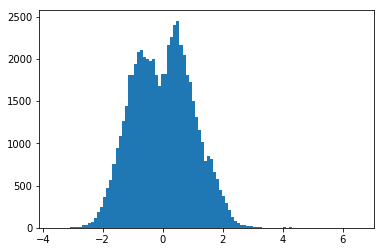

In [23]:
plt.hist(dfp2['log_per_area_total_price_scaled'], bins=100); plt.show()

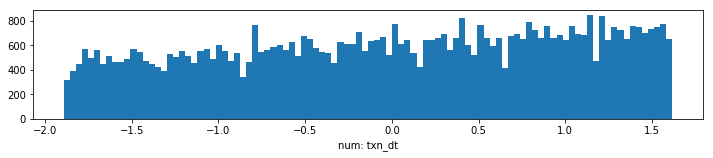

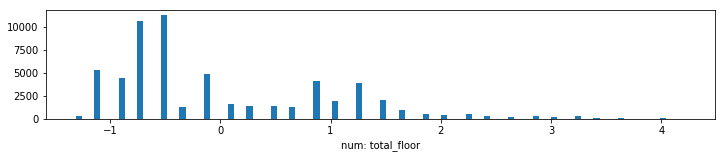

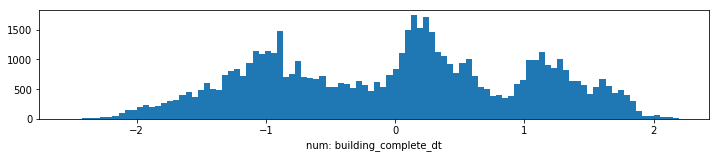

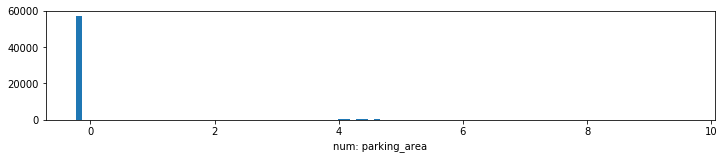

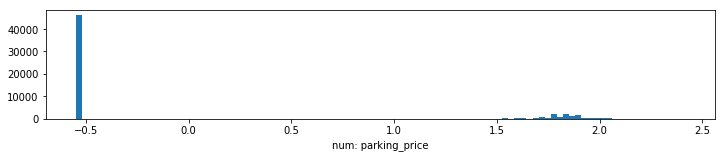

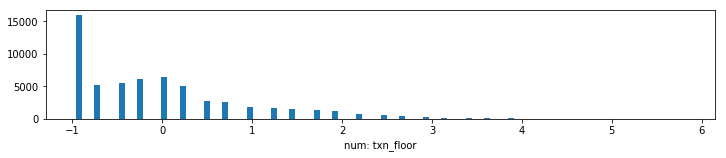

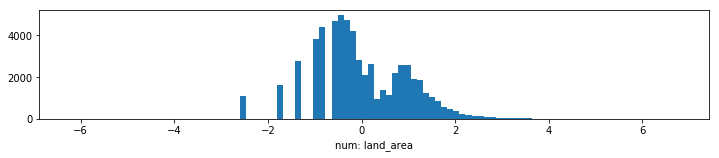

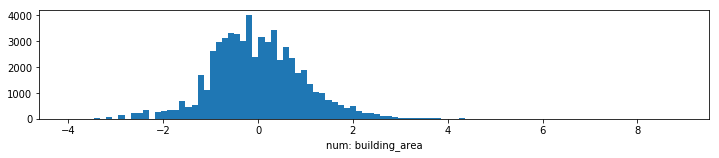

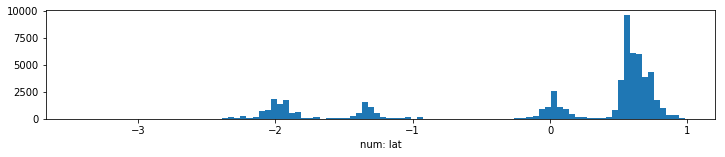

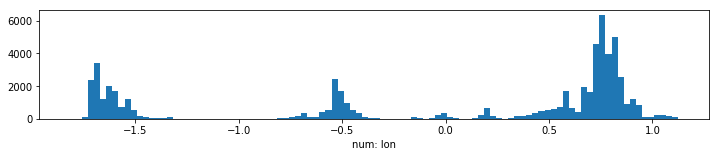

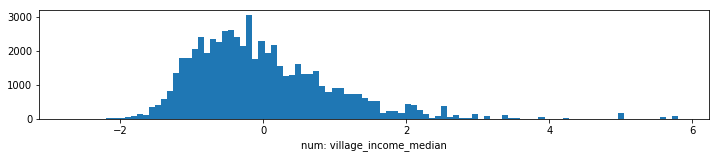

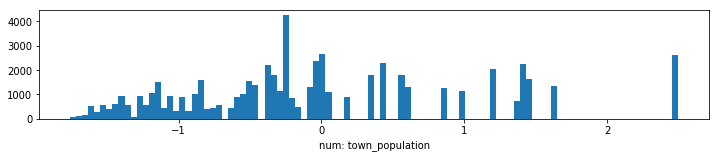

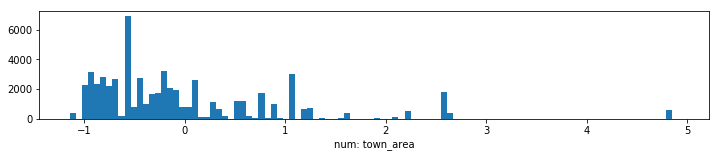

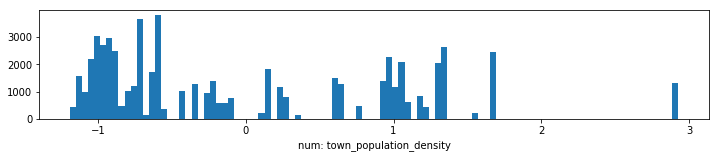

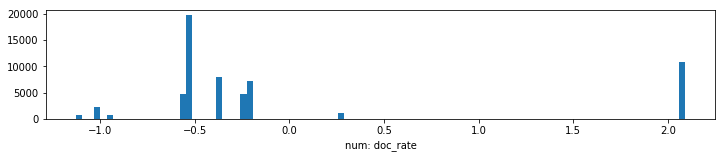

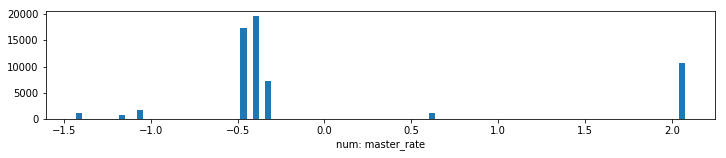

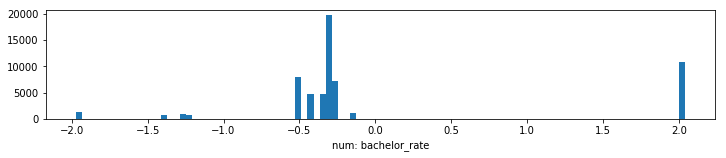

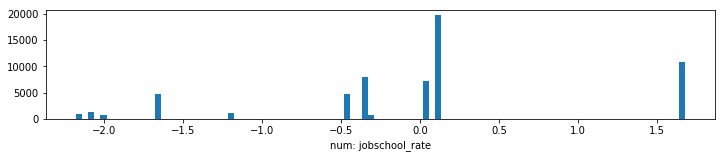

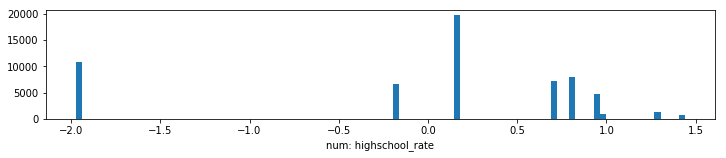

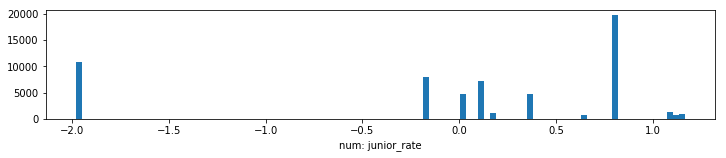

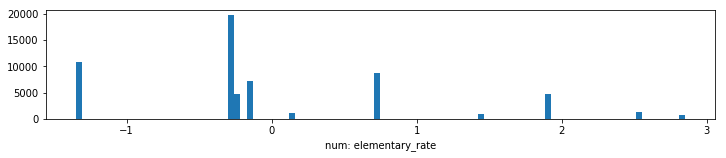

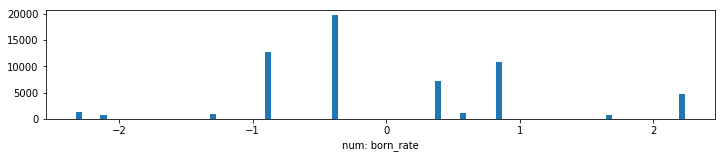

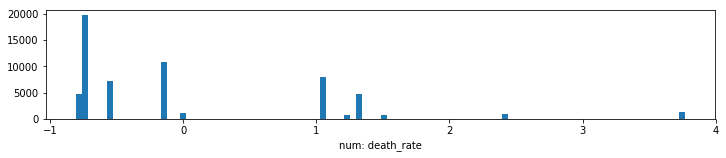

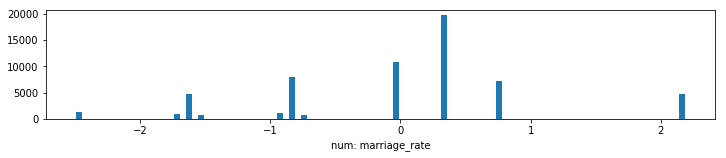

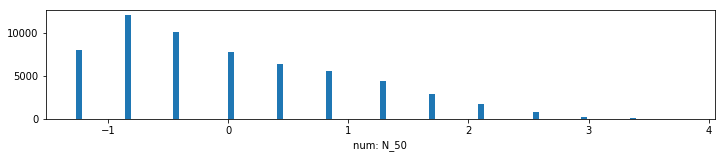

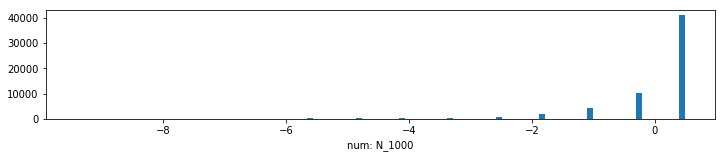

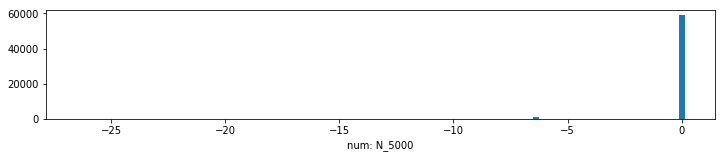

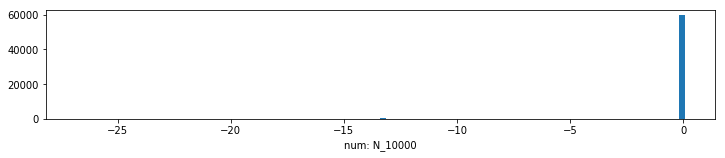

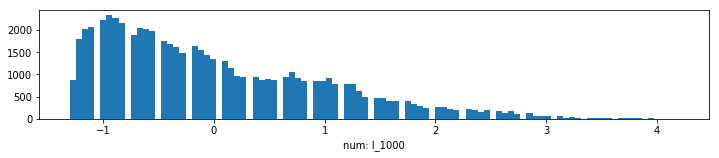

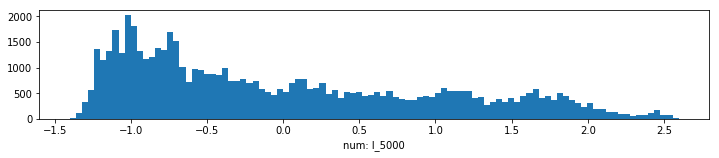

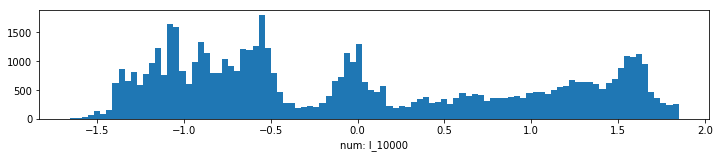

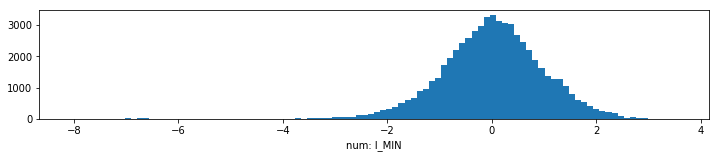

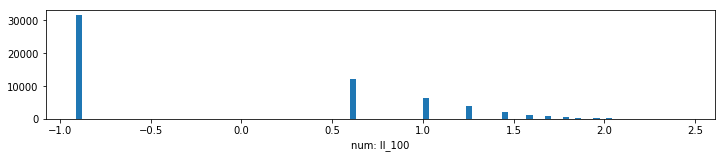

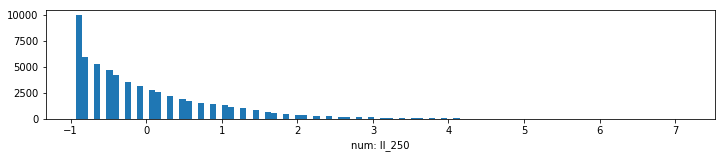

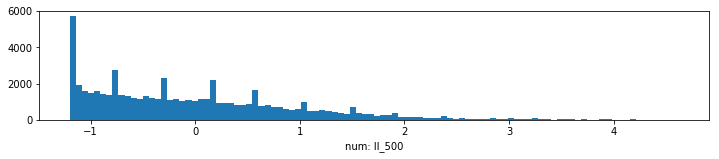

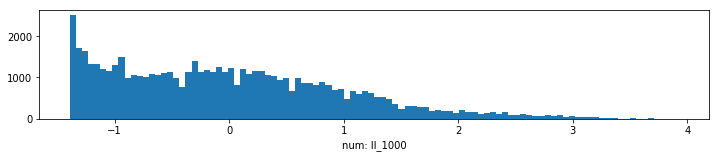

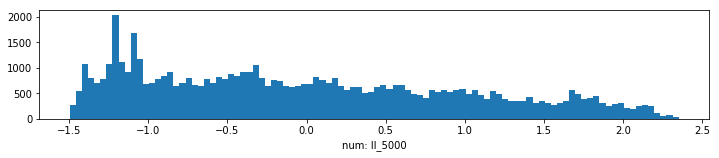

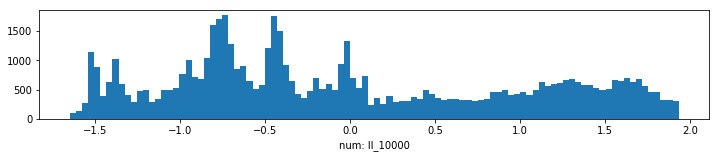

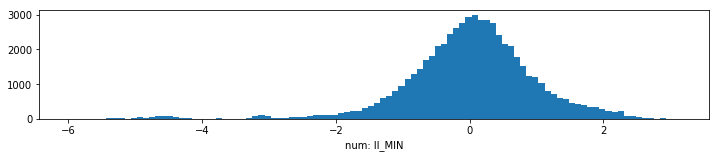

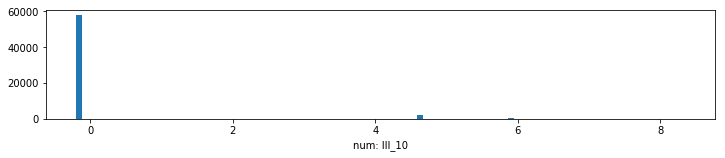

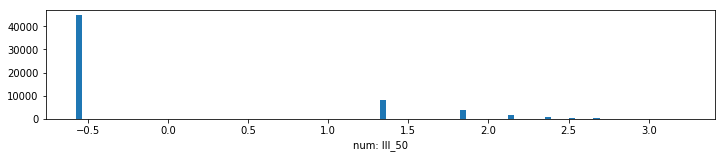

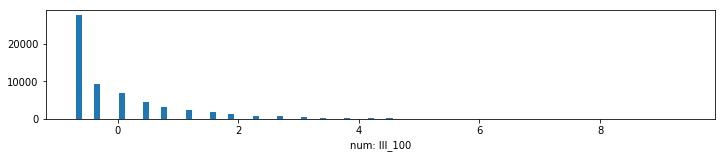

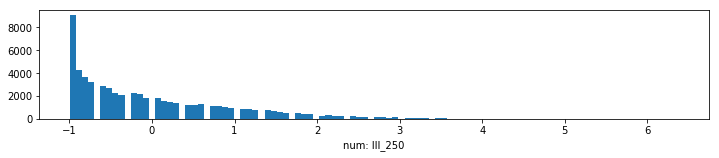

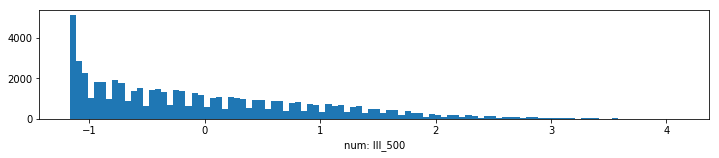

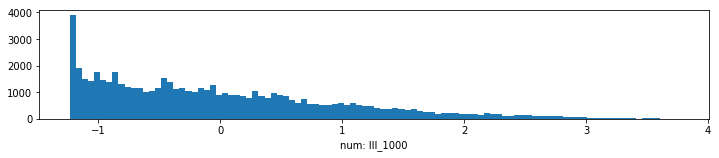

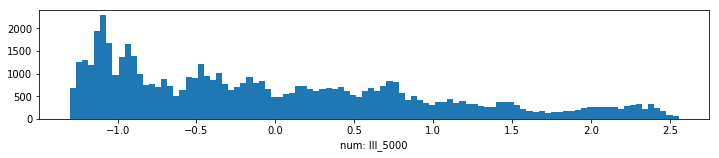

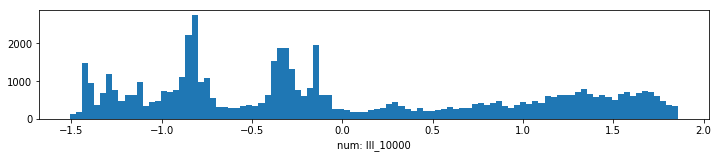

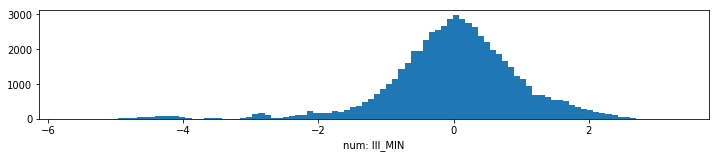

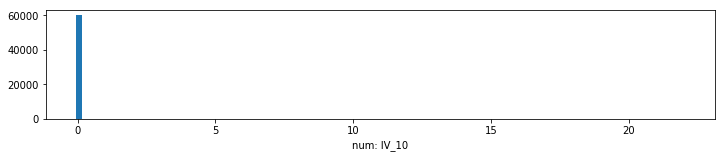

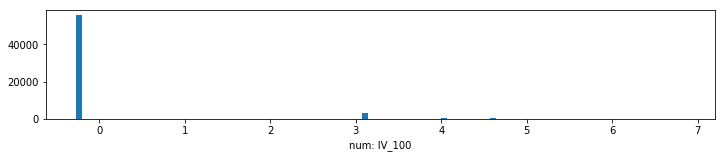

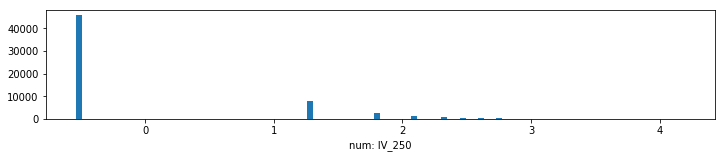

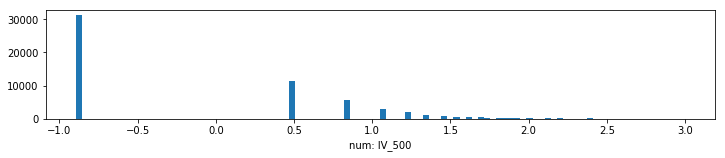

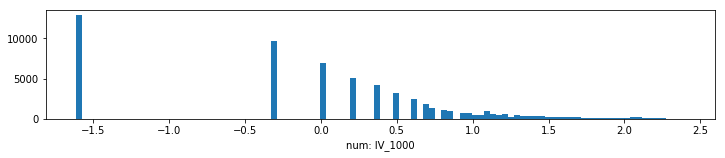

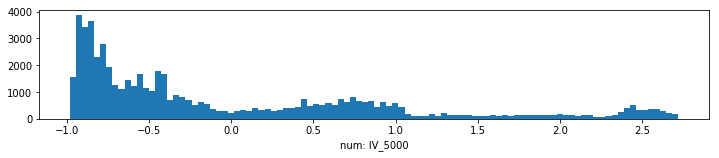

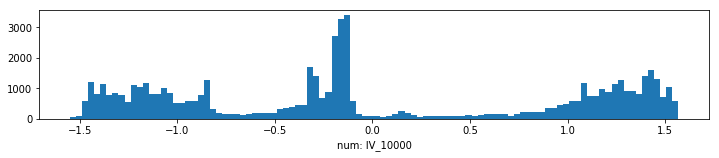

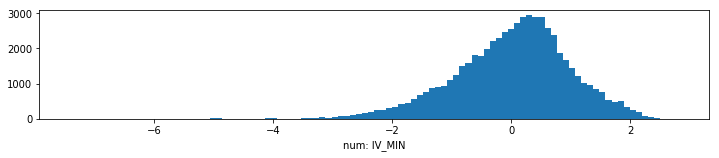

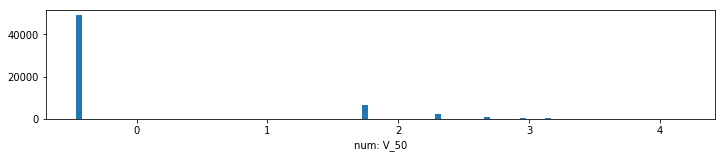

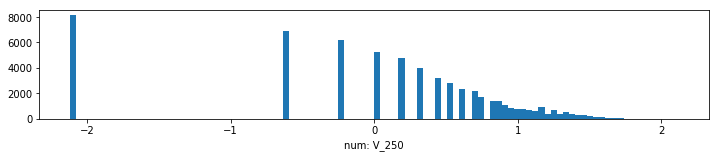

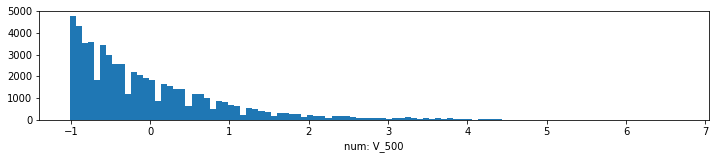

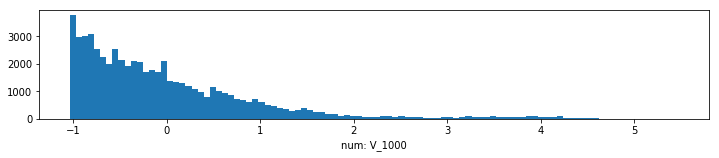

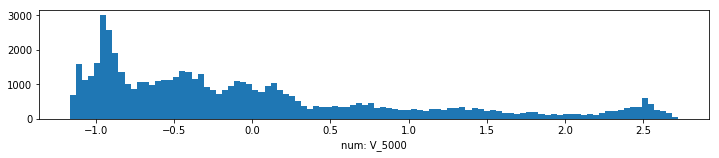

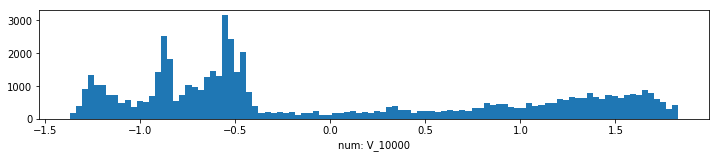

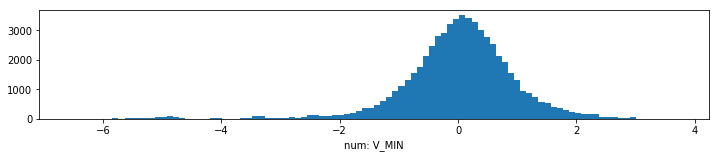

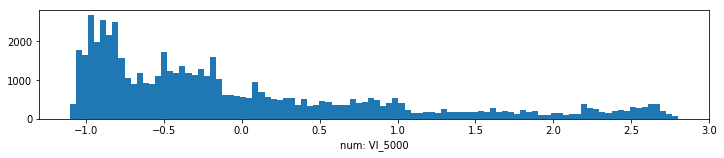

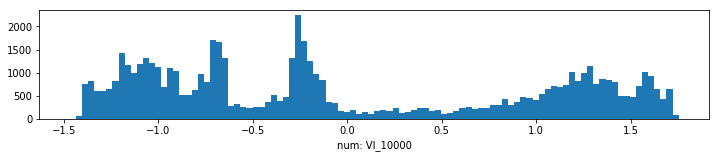

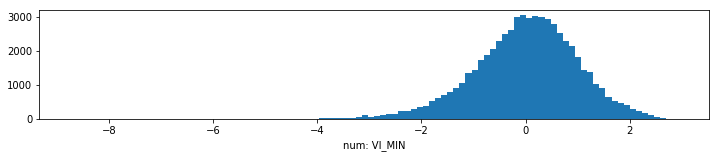

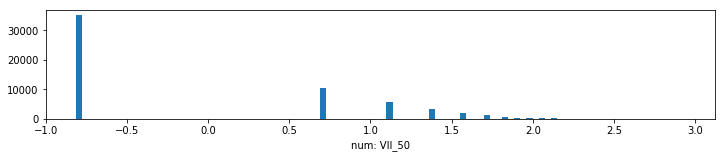

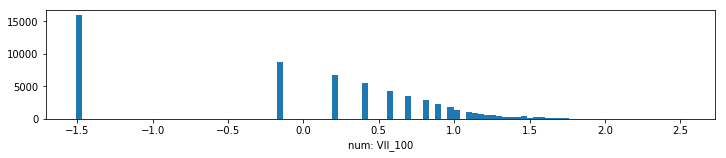

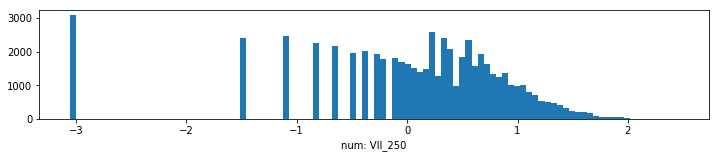

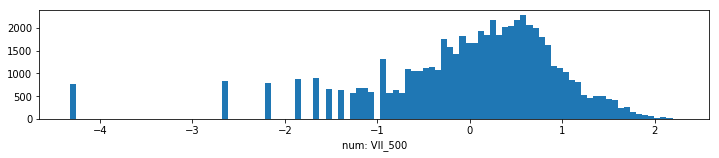

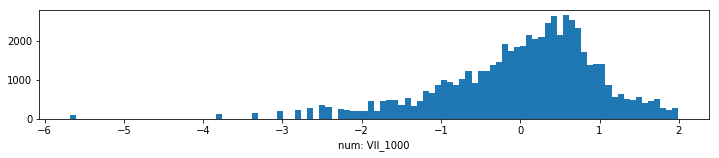

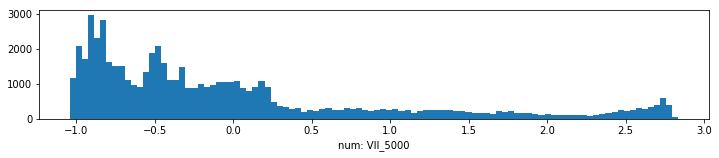

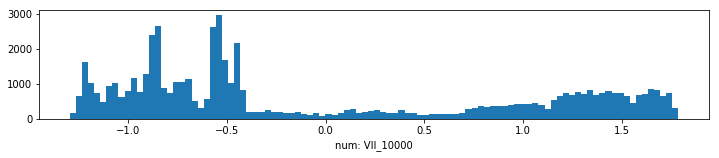

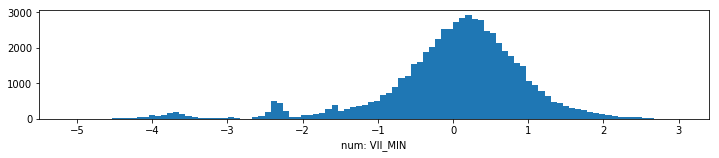

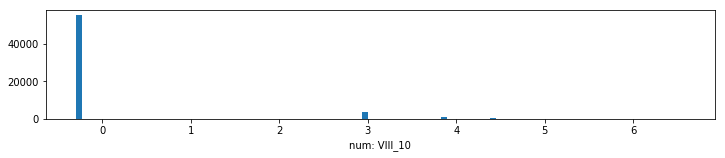

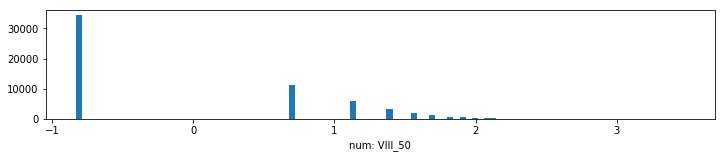

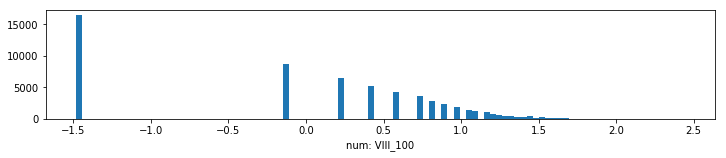

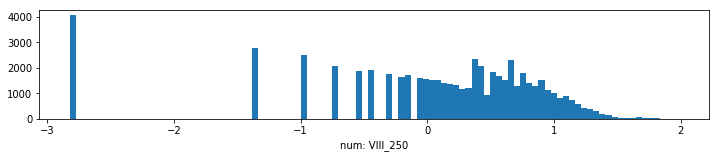

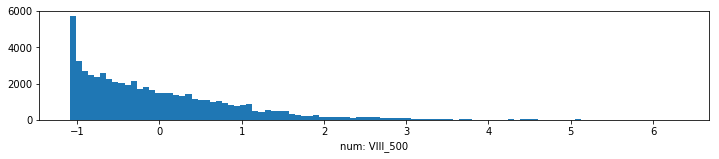

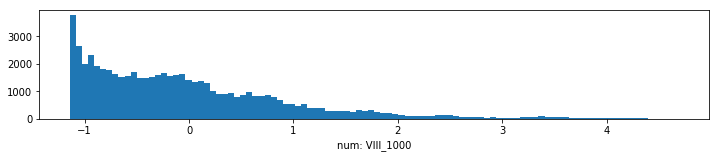

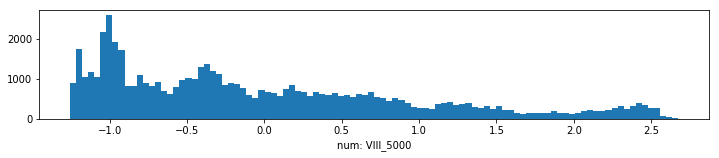

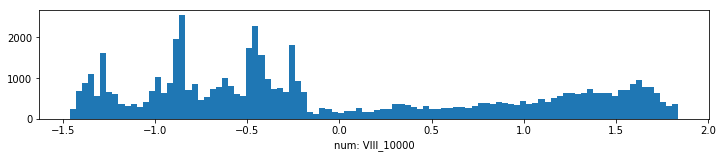

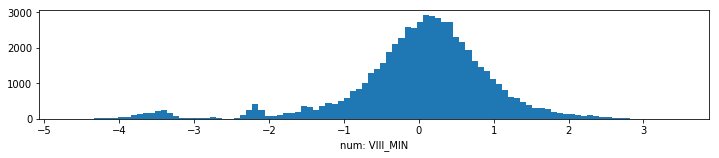

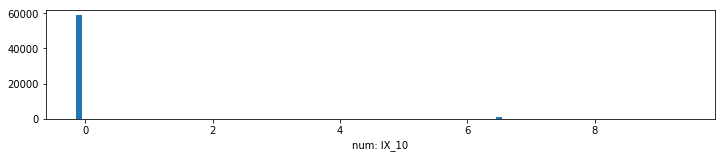

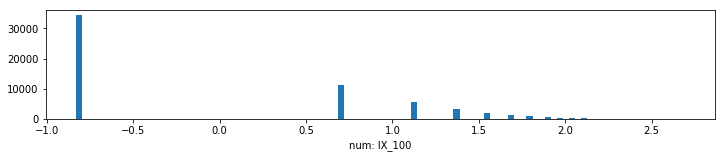

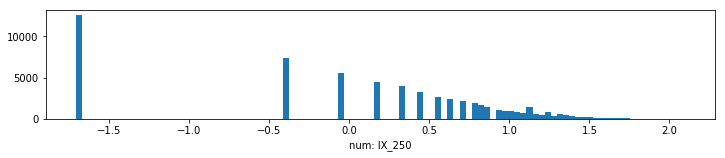

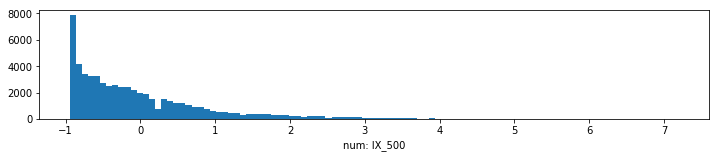

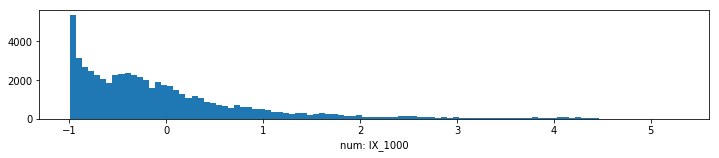

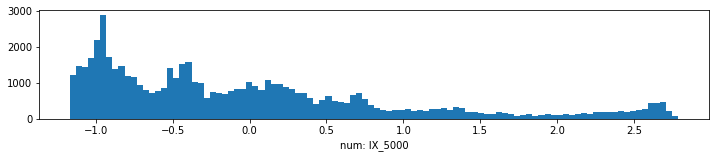

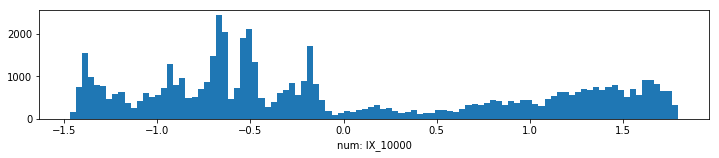

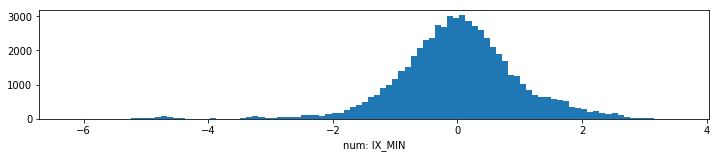

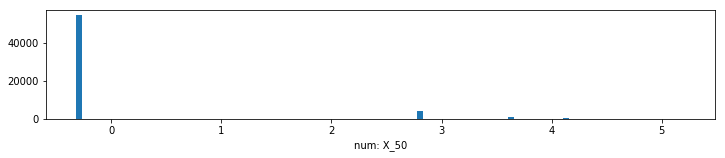

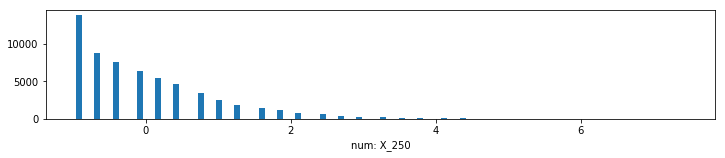

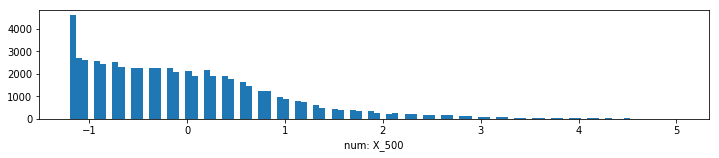

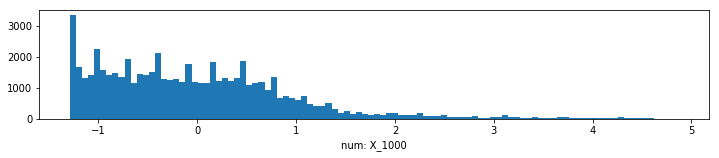

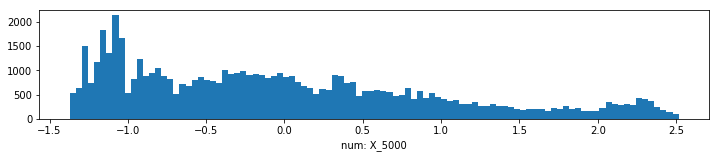

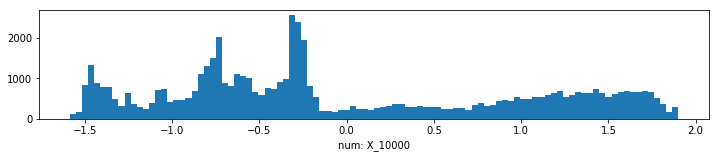

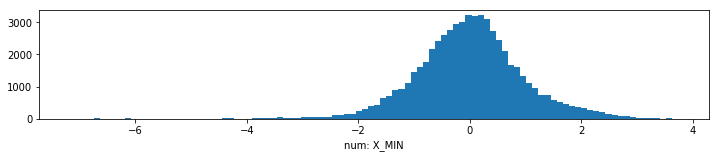

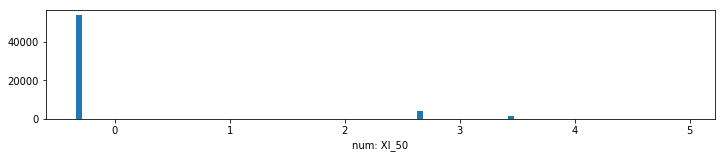

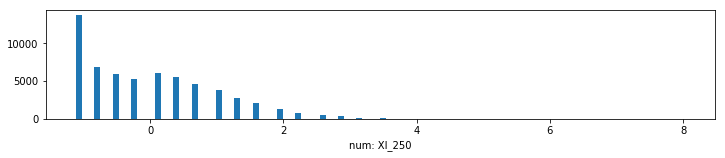

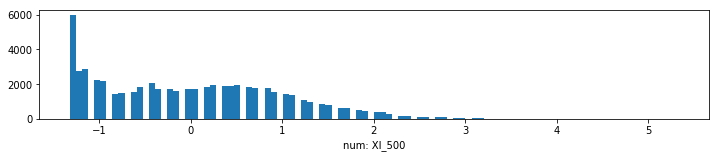

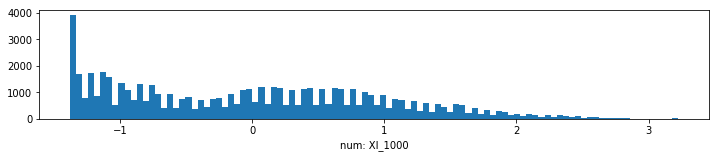

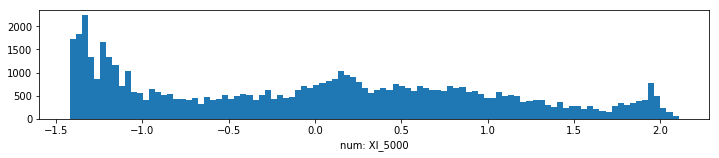

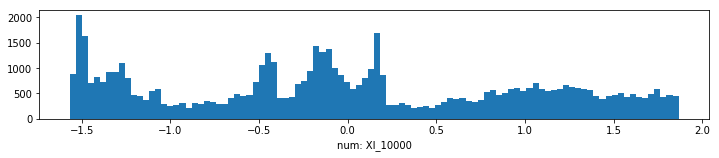

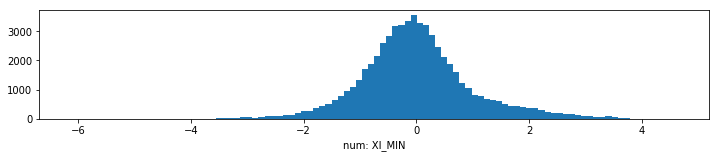

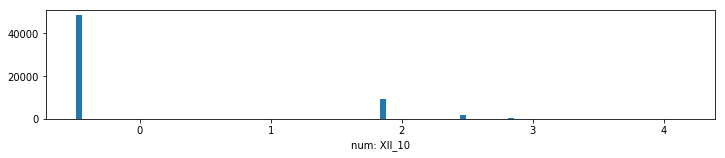

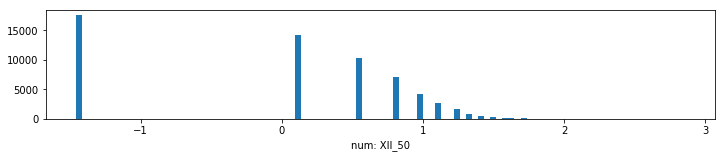

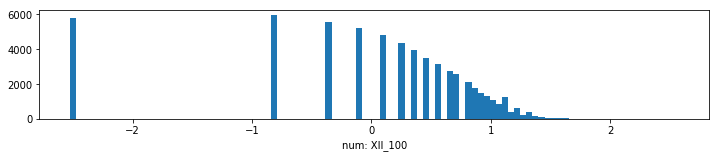

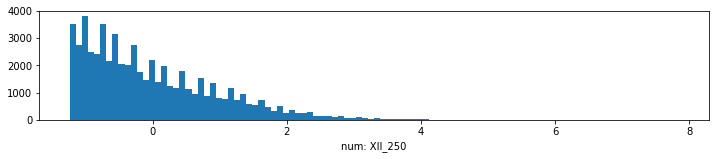

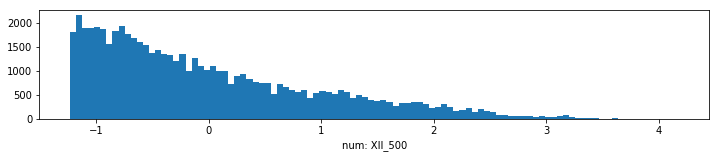

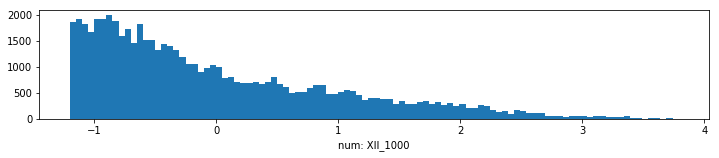

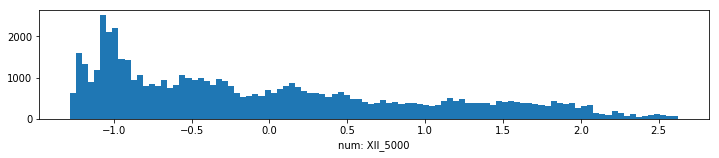

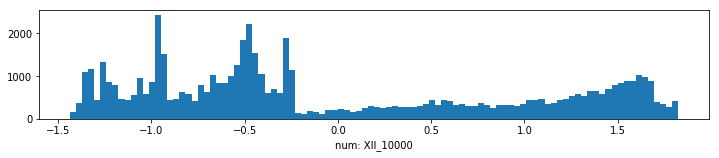

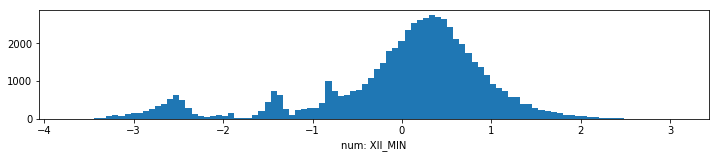

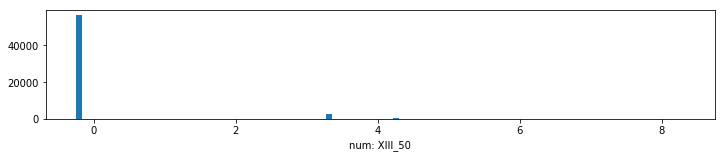

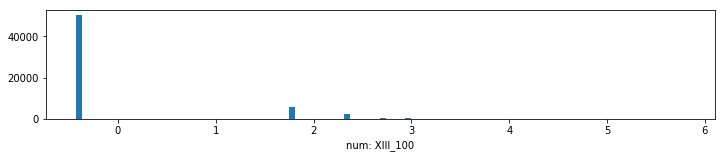

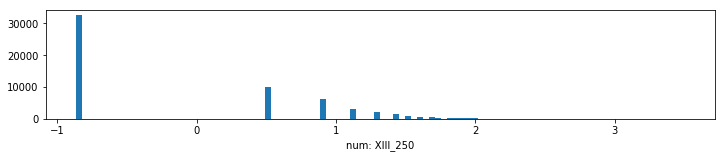

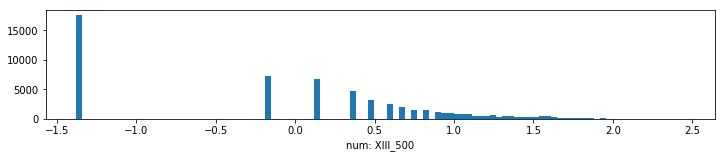

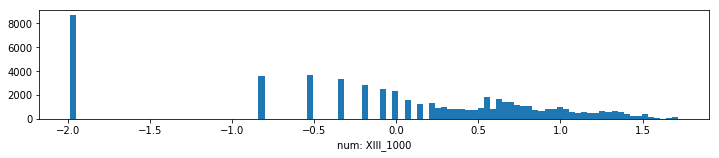

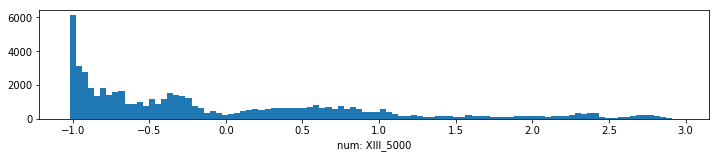

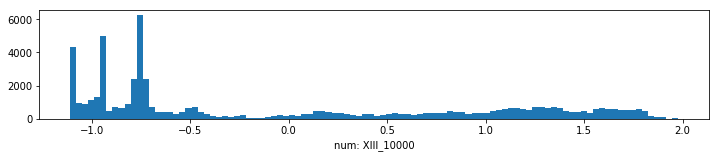

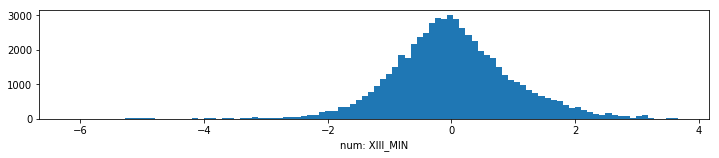

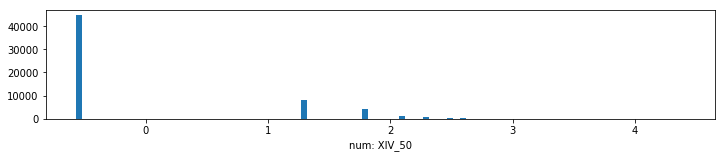

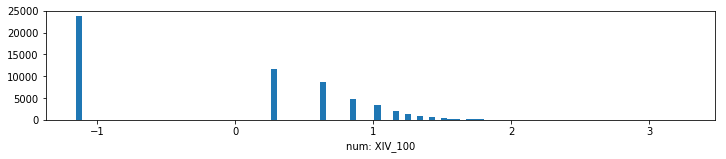

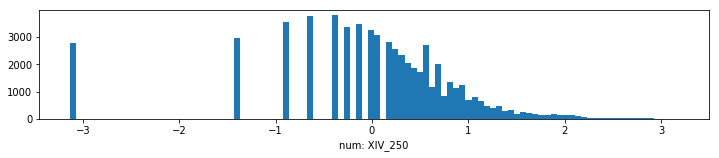

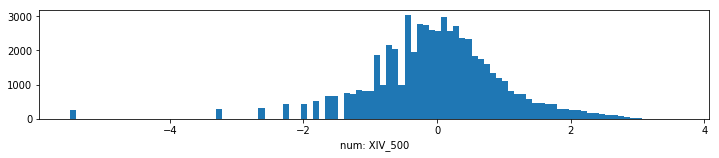

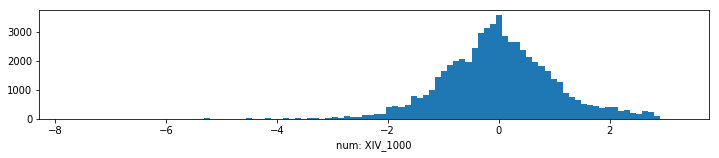

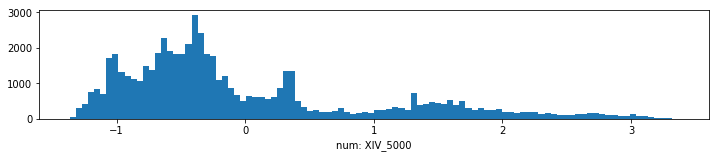

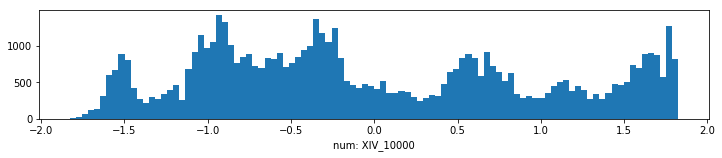

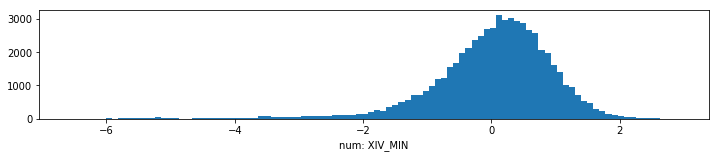

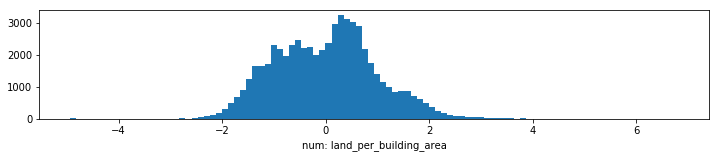

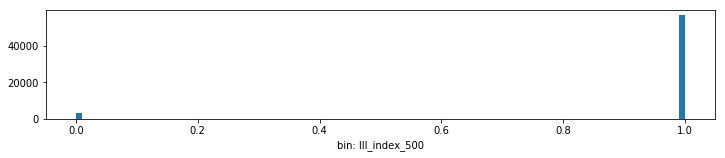

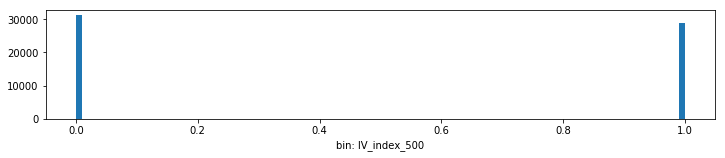

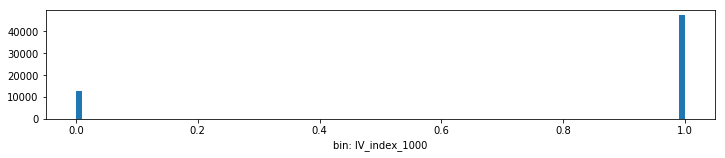

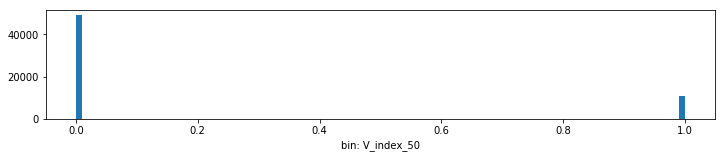

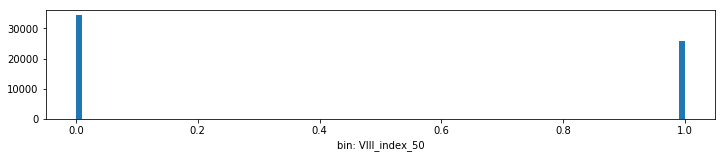

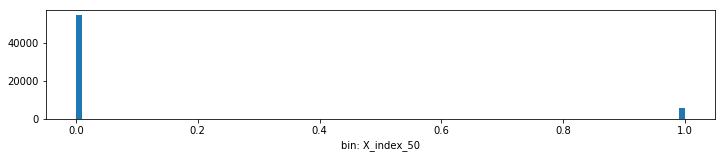

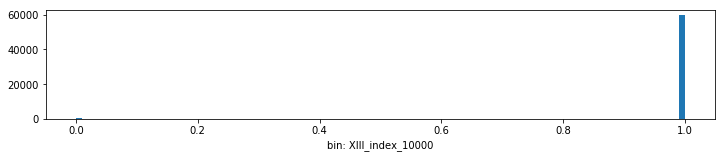

In [24]:
for c in cols_num:
    plt.figure(figsize=(12, 2))
    plt.hist(dfp2[c], bins=100)
    plt.xlabel('num: '+c); plt.show()
for c in cols_bin:
    plt.figure(figsize=(12, 2))
    plt.hist(dfp2[c], bins=100)
    plt.xlabel('bin: '+c); plt.show()

In [25]:
for c in cols_tar_encoded:
    plt.figure(figsize=(12, 2))
    plt.hist(dfp2[c], bins=100)
    plt.xlabel('tar: '+c); plt.show()

### Keras Model

In [26]:
import keras
import tensorflow as tf
print('keras:', keras.__version__, 'tensorflow:', tf.__version__)

from keras.models import Model
from keras.layers import Input, Dense, Embedding, Flatten, Reshape, concatenate, Dropout, BatchNormalization, Activation, Add
from keras.optimizers import Adam, SGD

Using TensorFlow backend.


keras: 2.2.4 tensorflow: 1.14.0


In [27]:
from keras_get_best import GetBest
from keras_SGDRScheduler import SGDRScheduler

In [28]:
def build_model(n_cols_num_bin, cat_n_classes={}, cat_embed_sizes={}, 
                n_neurons=(1024,)*10, learning_rate=0.001, optimizer=Adam, loss='mse', 
                skip_connection=False, batch_norm=False, activation='relu', dropout=0.,
                **ignored):
    '''Args: 
       n_cols_num_bin: number of numerical and binary features
       cat_n_classes: dict of cat column name to number of classes in the cat column
       cat_embed_sizes: dict of cat column name to embedding output size
       n_neurons: list of number of neurons for each dense layer
    '''
    if skip_connection:
        assert all([x==n_neurons[0] for x in n_neurons]), 'Residual connection only work' \
            ' for square shape network'
    is_embedding = len(cat_n_classes) > 0
    num_bin_input = Input(shape=(n_cols_num_bin,), dtype='float32', name='num_bin')
    cats_inputs = {c: Input(shape=(1,), dtype='int32', name=c) for c in cat_n_classes}
    if is_embedding:
        cats_embedding_layers = [
            Reshape(target_shape=(cat_embed_sizes[c],))(
                Embedding(input_dim=c_input_dim, output_dim=cat_embed_sizes[c])(cats_inputs[c])
            ) 
            for c, c_input_dim in cat_n_classes.items()
        ]
        x_layer = concatenate([num_bin_input]+cats_embedding_layers)  # output shape = 258
    else:
        x_layer = num_bin_input
    for i, n in enumerate(n_neurons):
        if skip_connection and i%2 == 1:
            skip_layer = x_layer
        x_layer = Dense(n)(x_layer)
        x_layer = Activation(activation)(x_layer)
        if dropout > 0. and i < len(n_neurons)-1:
            x_layer = Dropout(dropout)(x_layer)
        if batch_norm:
            x_layer = BatchNormalization()(x_layer)
        if skip_connection and i%2 == 0 and i > 0:
            x_layer = Add()([x_layer, skip_layer])
    output = Dense(1)(x_layer)
    model = Model(inputs=[num_bin_input]+list(cats_inputs.values()),
                  outputs=output)
    metrics = [m for m in ['mse', 'mae'] if m != loss]
    model.compile(optimizer=optimizer(lr=learning_rate), loss=loss, metrics=metrics)
    return model    

def build_features_matrices(df, cols_num, cols_cat, cols_bin):
    Xs = {'num_bin': df[cols_num+cols_bin].values}
    for c in cols_cat:
        Xs[c] = df[c].values
    return Xs

def plot_keras_hist(hists, ylim=None, metrics_plot=None, labels=None):
    if not isinstance(hists, list): hists=[hists]
    if metrics_plot is None:
        metrics_plot = [c for c in hists[0].history.keys() if not c.startswith('val')]
    if labels is None:
        labels = [str(i) for i in range(len(hists))]
    for m in metrics_plot:
        plt.figure(figsize=(14, 4))
        for label, hist in zip(labels, hists):
            for c in hist.history:
                if c.endswith(m):
                    plt.plot(hist.history[c], label=c+' '+label, alpha=0.9)
        if ylim != None:
            plt.ylim(*ylim)
        plt.xlabel('epochs'); plt.title(m)
        plt.legend(); plt.grid(); plt.show()

def plot_list_hist(hists, ylim=None, metrics_plot=None, labels=None):
    if not isinstance(hists, list): hists=[hists]
    if metrics_plot is None:
        metrics_plot = [c for c in hists[0].keys() if not c.startswith('val')]
    if labels is None:
        labels = [str(i) for i in range(len(hists))]
    for m in metrics_plot:
        plt.figure(figsize=(14, 4))
        for label, hist in zip(labels, hists):
            for c in hist:
                if c.endswith(m):
                    plt.plot(hist[c], label=c+' '+label, alpha=0.9)
        if ylim != None:
            plt.ylim(*ylim)
        plt.xlabel('epochs'); plt.title(m)
        plt.legend(); plt.grid(); plt.show()

def plot_list_hist_mean(hists, ylim=None, metrics_plot=None):
    if not isinstance(hists, list): hists=[hists]
    if metrics_plot is None:
        metrics_plot = [c for c in hists[0].keys() if not c.startswith('val')]
    keys_plot = [c for c in hists[0] for m in metrics_plot if c.endswith(m)]
    
    for c in keys_plot:
        plt.figure(figsize=(14, 4))
        array = np.zeros((len(hists[0][c]), len(hists)))
        for i, hist in enumerate(hists):
            array[:, i] = np.array(hist[c])
        sq_mean = array.mean(axis=1)
        sq_std = np.std(array, axis=1)
        #plt.errorbar(np.arange(1, len(sq_mean)+1), sq_mean, yerr=sq_std, label=c, alpha=0.9, fmt='-o')
        plt.plot(sq_mean, label=c+'_mean')
        plt.plot(sq_mean+sq_std, label=c+'_std+', alpha=0.5)
        plt.plot(sq_mean-sq_std, label=c+'_std-', alpha=0.5)
        if ylim != None: plt.ylim(*ylim)
        plt.xlabel('epochs'); plt.title(c+'_mean')
        plt.legend(); plt.grid(); plt.show()

### Compute N parameters

In [29]:
def n_params(n_neurons, n_inputs=194):
    """ Compute N of parameters for the dense layers """
    n_params = n_neurons[0]*(n_inputs+1)
    for i in range(1, len(n_neurons)):
        n_params += (n_neurons[i-1]+1)*n_neurons[i]
    n_params += (n_neurons[-1]+1)
    return n_params

def solve_2nd_order_equation(a, b, c):
    """ Solve a*x^2 +b*x + c == 0 for x """
    return (-b+np.sqrt(b**2 - 4*a*c)) / (2*a) 

def solve_width_for_ratio(ratios, params, n_inputs=194):
    """ Solve the width given ratio for each layers and the total params.
        Assume the layers to be (width*ratios[0], width*ratios[1], width*ratios[2], ...)
    """
    b = ratios[0]*(n_inputs+1)
    a = 0
    for i in range(1, len(ratios)):
        a += ratios[i-1]*ratios[i]
        b += ratios[i]
    b += ratios[-1]
    c = 1 - params
    #print(a, b, c)
    return solve_2nd_order_equation(a, b, c)

def best_n_neurons(ratios, params, n_inputs=194):
    width = int(round(solve_width_for_ratio(ratios, params, n_inputs)))
    return tuple([width*x for x in ratios])

In [30]:
print(best_n_neurons(ratios=(4,4,2,2,1,1), params=9647105, n_inputs=219))

(2176, 2176, 1088, 1088, 544, 544)


In [31]:
6*400*x**2 (3/2)*5 = 24*3600/ 

3000

In [32]:
np.sqrt(24*3600/(5*3/2)/6/400)

2.1908902300206643

In [33]:
9647105*2.1908902300206643

21135748.092483502

In [34]:
print(best_n_neurons(ratios=(4,4,2,2,1,1), params=21135748, n_inputs=219))

(3244, 3244, 1622, 1622, 811, 811)


In [37]:
21135748*1.239

26187191.772000004

In [38]:
print(best_n_neurons(ratios=(4,4,2,2,1,1), params=26187192, n_inputs=219))

(3620, 3620, 1810, 1810, 905, 905)


In [39]:
900*1.239

1115.1000000000001

In [42]:
np.sqrt(12/13)

0.9607689228305228

In [43]:
np.sqrt(12/13)*26187192

25159840.249796085

In [44]:
print(best_n_neurons(ratios=(4,4,2,2,1,1), params=25159840, n_inputs=219))

(3548, 3548, 1774, 1774, 887, 887)


In [45]:
1116*np.sqrt(12/13)

1072.2181178788635

### Params

In [47]:
params = {'epochs': 1072,
          'loss': 'mse',
          'batch_norm': True,
          'n_neurons': (3548, 3548, 1774, 1774, 887, 887),
          'batch_size': 256,
          'embedding_ratio': 3,
         }

### kfold cross-predict

In [48]:
t0 = time.time()

predicts_val = []
predicts_test = test[['building_id']].copy()
hists = []
best_iterations = []
scores = []
for i, id_fold in enumerate(id_cv):
    print('==== Fold', i+1, '====')
    
    # split train, val
    df_train = train.loc[~train['building_id'].isin(id_fold)].copy().reset_index(drop=True)
    df_val = train.loc[train['building_id'].isin(id_fold)].copy().reset_index(drop=True)
    df_test = test.copy()

    # Feature engineering
    feat_eng = FeatureEngineering(cols_num=cols_num, 
                                  cols_cat=cols_cat, 
                                  cols_bin=cols_bin, 
                                  col_target=col_target, 
                                  fillna_values=fillna_values, 
                                  cols_right_skew=cols_right_skew,
                                  is_embedding=is_embedding, 
                                  is_tar_encoded=is_tar_encoded,
                                  rare_village_threshold=rare_village_threshold, 
                                  rare_town_threshold=rare_town_threshold,)
    df_train = feat_eng.fit_transform(df_train, df_val)
    df_val = feat_eng.transform(df_val)
    df_test = feat_eng.transform(df_test)

    # Construct X y matrices
    if is_embedding:
        X_train = build_features_matrices(df_train, cols_num=cols_num+cols_tar_encoded, cols_cat=cols_cat, cols_bin=cols_bin)
        X_val = build_features_matrices(df_val, cols_num=cols_num+cols_tar_encoded, cols_cat=cols_cat, cols_bin=cols_bin)
        X_test = build_features_matrices(df_test, cols_num=cols_num+cols_tar_encoded, cols_cat=cols_cat, cols_bin=cols_bin)
    else:
        X_train = build_features_matrices(df_train, cols_num=cols_num+cols_tar_encoded, cols_cat=[], cols_bin=cols_bin)
        X_val = build_features_matrices(df_val, cols_num=cols_num+cols_tar_encoded, cols_cat=[], cols_bin=cols_bin)
        X_test = build_features_matrices(df_test, cols_num=cols_num+cols_tar_encoded, cols_cat=[], cols_bin=cols_bin)
    y_train = df_train[col_target+'_scaled']
    y_val = df_val[col_target+'_scaled']
    
    # Compute network size
    n_cols_num_bin = len(cols_num+cols_bin+cols_tar_encoded)
    if is_embedding:
        cat_n_classes = {c: feat_eng.cat_astyper.cat_n_classes[c] for c in cols_cat}
    else:
        cat_n_classes = {}
    cat_embed_sizes = {c: min(int(params['embedding_ratio']*np.log(cat_n_classes[c]+1)+1), 
                              cat_n_classes[c]) for c in cat_n_classes}
    print('Numerical input dims:', n_cols_num_bin)
    print('Embeding  input dims:', cat_n_classes)
    print('Embeding output dims:', cat_embed_sizes)
    print('Total embedding output dims:', np.sum(list(cat_embed_sizes.values())))
    print()

    # Build model
    model = build_model(n_cols_num_bin, cat_n_classes, cat_embed_sizes, **params)

    # Train model
    hist = model.fit(x=X_train, y=y_train, verbose=2, validation_data=(X_val, y_val), 
                     callbacks=[GetBest(monitor='val_mean_absolute_error', verbose=0, mode='min')],
                     batch_size=params['batch_size'], epochs=params['epochs'])
    best_iterations.append(np.argmin(hist.history['val_loss'])+1)
    hists.append(hist)

    # Predict on val set
    df_val[col_target+'_scaled_pred'] = model.predict(X_val, batch_size=1024)
    feat_eng.target_inverse_transform(df_val, col_target+'_scaled_pred', col_target+'_pred')
    df_val['total_price_pred'] = post_processing(df_val[col_target+'_pred'], df_val)

    mse = mean_squared_error(df_val[col_target], df_val[col_target+'_pred'])
    mae = mean_absolute_error(df_val[col_target], df_val[col_target+'_pred'])
    mape = cal_mape(df_val[col_target], df_val[col_target+'_pred'])
    score = cal_score(df_val['total_price'], df_val['total_price_pred'])
    scores.append(score)

    print('(Fold %d) score, mse, mae, mape: %.5f, %.5f, %.5f, %.5f.' % (i, score, mse, mae, mape))
    predicts_val.append(pd.DataFrame({'building_id': df_val['building_id'],
                                      'total_price': df_val['total_price'],
                                      'total_price_predict': df_val['total_price_pred']}))

    
    # Predict on test set
    df_test[col_target+'_scaled_pred'] = model.predict(X_test, batch_size=1024)
    feat_eng.target_inverse_transform(df_test, col_target+'_scaled_pred', col_target+'_pred')

    predicts_test['target_{}'.format(i)] = df_test[col_target+'_pred']

t1 = time.time()

==== Fold 1 ====
Numerical input dims: 138
Embeding  input dims: {'building_material': 10, 'parking_way': 4, 'city': 12, 'town': 202, 'building_type': 6, 'building_use': 11, 'encoded_latlon': 7, 'village': 2479}
Embeding output dims: {'building_material': 8, 'building_use': 8, 'city': 8, 'town': 16, 'building_type': 6, 'parking_way': 4, 'encoded_latlon': 7, 'village': 24}
Total embedding output dims: 81

Train on 48000 samples, validate on 12000 samples
Epoch 1/1072
 - 14s - loss: 1.1625 - mean_absolute_error: 0.4744 - val_loss: 0.1602 - val_mean_absolute_error: 0.3078
Epoch 2/1072
 - 13s - loss: 0.1200 - mean_absolute_error: 0.2644 - val_loss: 0.1023 - val_mean_absolute_error: 0.2416
Epoch 3/1072
 - 12s - loss: 0.0978 - mean_absolute_error: 0.2380 - val_loss: 0.0825 - val_mean_absolute_error: 0.2136
Epoch 4/1072
 - 13s - loss: 0.0844 - mean_absolute_error: 0.2200 - val_loss: 0.0798 - val_mean_absolute_error: 0.2119
Epoch 5/1072
 - 13s - loss: 0.0786 - mean_absolute_error: 0.2126 - val

 - 12s - loss: 0.0229 - mean_absolute_error: 0.1133 - val_loss: 0.0585 - val_mean_absolute_error: 0.1687
Epoch 67/1072
 - 12s - loss: 0.0196 - mean_absolute_error: 0.1040 - val_loss: 0.0593 - val_mean_absolute_error: 0.1694
Epoch 68/1072
 - 13s - loss: 0.0198 - mean_absolute_error: 0.1063 - val_loss: 0.0581 - val_mean_absolute_error: 0.1712
Epoch 69/1072
 - 12s - loss: 0.0208 - mean_absolute_error: 0.1077 - val_loss: 0.0648 - val_mean_absolute_error: 0.1816
Epoch 70/1072
 - 12s - loss: 0.0191 - mean_absolute_error: 0.1027 - val_loss: 0.0590 - val_mean_absolute_error: 0.1711
Epoch 71/1072
 - 12s - loss: 0.0218 - mean_absolute_error: 0.1113 - val_loss: 0.0697 - val_mean_absolute_error: 0.1921
Epoch 72/1072
 - 12s - loss: 0.0205 - mean_absolute_error: 0.1073 - val_loss: 0.0617 - val_mean_absolute_error: 0.1757
Epoch 73/1072
 - 13s - loss: 0.0191 - mean_absolute_error: 0.1029 - val_loss: 0.0600 - val_mean_absolute_error: 0.1678
Epoch 74/1072
 - 12s - loss: 0.0177 - mean_absolute_error: 0.1

Epoch 135/1072
 - 12s - loss: 0.0093 - mean_absolute_error: 0.0717 - val_loss: 0.0537 - val_mean_absolute_error: 0.1593
Epoch 136/1072
 - 12s - loss: 0.0111 - mean_absolute_error: 0.0795 - val_loss: 0.0531 - val_mean_absolute_error: 0.1544
Epoch 137/1072
 - 12s - loss: 0.0101 - mean_absolute_error: 0.0741 - val_loss: 0.0577 - val_mean_absolute_error: 0.1641
Epoch 138/1072
 - 12s - loss: 0.0095 - mean_absolute_error: 0.0732 - val_loss: 0.0508 - val_mean_absolute_error: 0.1514
Epoch 139/1072
 - 12s - loss: 0.0100 - mean_absolute_error: 0.0745 - val_loss: 0.0507 - val_mean_absolute_error: 0.1533
Epoch 140/1072
 - 13s - loss: 0.0100 - mean_absolute_error: 0.0754 - val_loss: 0.0589 - val_mean_absolute_error: 0.1643
Epoch 141/1072
 - 12s - loss: 0.0101 - mean_absolute_error: 0.0760 - val_loss: 0.0510 - val_mean_absolute_error: 0.1530
Epoch 142/1072
 - 13s - loss: 0.0098 - mean_absolute_error: 0.0746 - val_loss: 0.0508 - val_mean_absolute_error: 0.1511
Epoch 143/1072
 - 13s - loss: 0.0091 - m

Epoch 204/1072
 - 12s - loss: 0.0069 - mean_absolute_error: 0.0638 - val_loss: 0.0494 - val_mean_absolute_error: 0.1466
Epoch 205/1072
 - 12s - loss: 0.0069 - mean_absolute_error: 0.0647 - val_loss: 0.0485 - val_mean_absolute_error: 0.1448
Epoch 206/1072
 - 12s - loss: 0.0064 - mean_absolute_error: 0.0607 - val_loss: 0.0503 - val_mean_absolute_error: 0.1480
Epoch 207/1072
 - 12s - loss: 0.0063 - mean_absolute_error: 0.0600 - val_loss: 0.0490 - val_mean_absolute_error: 0.1457
Epoch 208/1072
 - 12s - loss: 0.0076 - mean_absolute_error: 0.0670 - val_loss: 0.0500 - val_mean_absolute_error: 0.1486
Epoch 209/1072
 - 12s - loss: 0.0067 - mean_absolute_error: 0.0644 - val_loss: 0.0487 - val_mean_absolute_error: 0.1449
Epoch 210/1072
 - 12s - loss: 0.0071 - mean_absolute_error: 0.0650 - val_loss: 0.0483 - val_mean_absolute_error: 0.1448
Epoch 211/1072
 - 12s - loss: 0.0063 - mean_absolute_error: 0.0600 - val_loss: 0.0487 - val_mean_absolute_error: 0.1451
Epoch 212/1072
 - 12s - loss: 0.0068 - m

Epoch 273/1072
 - 12s - loss: 0.0058 - mean_absolute_error: 0.0597 - val_loss: 0.0498 - val_mean_absolute_error: 0.1463
Epoch 274/1072
 - 12s - loss: 0.0049 - mean_absolute_error: 0.0528 - val_loss: 0.0490 - val_mean_absolute_error: 0.1443
Epoch 275/1072
 - 12s - loss: 0.0049 - mean_absolute_error: 0.0546 - val_loss: 0.0494 - val_mean_absolute_error: 0.1457
Epoch 276/1072
 - 12s - loss: 0.0052 - mean_absolute_error: 0.0557 - val_loss: 0.0487 - val_mean_absolute_error: 0.1429
Epoch 277/1072
 - 12s - loss: 0.0056 - mean_absolute_error: 0.0579 - val_loss: 0.0491 - val_mean_absolute_error: 0.1435
Epoch 278/1072
 - 12s - loss: 0.0052 - mean_absolute_error: 0.0556 - val_loss: 0.0486 - val_mean_absolute_error: 0.1436
Epoch 279/1072
 - 12s - loss: 0.0055 - mean_absolute_error: 0.0570 - val_loss: 0.0506 - val_mean_absolute_error: 0.1471
Epoch 280/1072
 - 12s - loss: 0.0058 - mean_absolute_error: 0.0596 - val_loss: 0.0486 - val_mean_absolute_error: 0.1445
Epoch 281/1072
 - 13s - loss: 0.0070 - m

Epoch 342/1072
 - 13s - loss: 0.0049 - mean_absolute_error: 0.0545 - val_loss: 0.0506 - val_mean_absolute_error: 0.1469
Epoch 343/1072
 - 12s - loss: 0.0058 - mean_absolute_error: 0.0579 - val_loss: 0.0496 - val_mean_absolute_error: 0.1457
Epoch 344/1072
 - 12s - loss: 0.0055 - mean_absolute_error: 0.0565 - val_loss: 0.0493 - val_mean_absolute_error: 0.1455
Epoch 345/1072
 - 13s - loss: 0.0054 - mean_absolute_error: 0.0572 - val_loss: 0.0498 - val_mean_absolute_error: 0.1459
Epoch 346/1072
 - 13s - loss: 0.0052 - mean_absolute_error: 0.0566 - val_loss: 0.0488 - val_mean_absolute_error: 0.1441
Epoch 347/1072
 - 13s - loss: 0.0050 - mean_absolute_error: 0.0541 - val_loss: 0.0492 - val_mean_absolute_error: 0.1444
Epoch 348/1072
 - 13s - loss: 0.0048 - mean_absolute_error: 0.0540 - val_loss: 0.0501 - val_mean_absolute_error: 0.1489
Epoch 349/1072
 - 13s - loss: 0.0053 - mean_absolute_error: 0.0555 - val_loss: 0.0512 - val_mean_absolute_error: 0.1483
Epoch 350/1072
 - 12s - loss: 0.0051 - m

Epoch 411/1072
 - 12s - loss: 0.0049 - mean_absolute_error: 0.0539 - val_loss: 0.0502 - val_mean_absolute_error: 0.1459
Epoch 412/1072
 - 12s - loss: 0.0047 - mean_absolute_error: 0.0525 - val_loss: 0.0498 - val_mean_absolute_error: 0.1447
Epoch 413/1072
 - 13s - loss: 0.0052 - mean_absolute_error: 0.0556 - val_loss: 0.0500 - val_mean_absolute_error: 0.1460
Epoch 414/1072
 - 12s - loss: 0.0052 - mean_absolute_error: 0.0558 - val_loss: 0.0495 - val_mean_absolute_error: 0.1446
Epoch 415/1072
 - 13s - loss: 0.0049 - mean_absolute_error: 0.0540 - val_loss: 0.0498 - val_mean_absolute_error: 0.1443
Epoch 416/1072
 - 12s - loss: 0.0050 - mean_absolute_error: 0.0559 - val_loss: 0.0497 - val_mean_absolute_error: 0.1455
Epoch 417/1072
 - 12s - loss: 0.0051 - mean_absolute_error: 0.0564 - val_loss: 0.0502 - val_mean_absolute_error: 0.1458
Epoch 418/1072
 - 13s - loss: 0.0050 - mean_absolute_error: 0.0538 - val_loss: 0.0522 - val_mean_absolute_error: 0.1511
Epoch 419/1072
 - 13s - loss: 0.0047 - m

Epoch 480/1072
 - 12s - loss: 0.0053 - mean_absolute_error: 0.0564 - val_loss: 0.0503 - val_mean_absolute_error: 0.1457
Epoch 481/1072
 - 13s - loss: 0.0053 - mean_absolute_error: 0.0558 - val_loss: 0.0504 - val_mean_absolute_error: 0.1460
Epoch 482/1072
 - 13s - loss: 0.0046 - mean_absolute_error: 0.0523 - val_loss: 0.0497 - val_mean_absolute_error: 0.1439
Epoch 483/1072
 - 13s - loss: 0.0044 - mean_absolute_error: 0.0506 - val_loss: 0.0499 - val_mean_absolute_error: 0.1443
Epoch 484/1072
 - 13s - loss: 0.0047 - mean_absolute_error: 0.0522 - val_loss: 0.0502 - val_mean_absolute_error: 0.1453
Epoch 485/1072
 - 13s - loss: 0.0047 - mean_absolute_error: 0.0520 - val_loss: 0.0495 - val_mean_absolute_error: 0.1434
Epoch 486/1072
 - 13s - loss: 0.0051 - mean_absolute_error: 0.0566 - val_loss: 0.0498 - val_mean_absolute_error: 0.1450
Epoch 487/1072
 - 13s - loss: 0.0049 - mean_absolute_error: 0.0539 - val_loss: 0.0496 - val_mean_absolute_error: 0.1438
Epoch 488/1072
 - 13s - loss: 0.0049 - m

Epoch 549/1072
 - 13s - loss: 0.0044 - mean_absolute_error: 0.0511 - val_loss: 0.0504 - val_mean_absolute_error: 0.1445
Epoch 550/1072
 - 13s - loss: 0.0047 - mean_absolute_error: 0.0531 - val_loss: 0.0509 - val_mean_absolute_error: 0.1456
Epoch 551/1072
 - 13s - loss: 0.0055 - mean_absolute_error: 0.0562 - val_loss: 0.0516 - val_mean_absolute_error: 0.1482
Epoch 552/1072
 - 13s - loss: 0.0048 - mean_absolute_error: 0.0536 - val_loss: 0.0510 - val_mean_absolute_error: 0.1459
Epoch 553/1072
 - 13s - loss: 0.0053 - mean_absolute_error: 0.0568 - val_loss: 0.0503 - val_mean_absolute_error: 0.1455
Epoch 554/1072
 - 13s - loss: 0.0050 - mean_absolute_error: 0.0543 - val_loss: 0.0502 - val_mean_absolute_error: 0.1446
Epoch 555/1072
 - 13s - loss: 0.0057 - mean_absolute_error: 0.0587 - val_loss: 0.0505 - val_mean_absolute_error: 0.1448
Epoch 556/1072
 - 13s - loss: 0.0041 - mean_absolute_error: 0.0495 - val_loss: 0.0509 - val_mean_absolute_error: 0.1467
Epoch 557/1072
 - 13s - loss: 0.0052 - m

Epoch 618/1072
 - 13s - loss: 0.0044 - mean_absolute_error: 0.0523 - val_loss: 0.0504 - val_mean_absolute_error: 0.1448
Epoch 619/1072
 - 13s - loss: 0.0049 - mean_absolute_error: 0.0556 - val_loss: 0.0508 - val_mean_absolute_error: 0.1466
Epoch 620/1072
 - 13s - loss: 0.0043 - mean_absolute_error: 0.0492 - val_loss: 0.0502 - val_mean_absolute_error: 0.1457
Epoch 621/1072
 - 13s - loss: 0.0054 - mean_absolute_error: 0.0567 - val_loss: 0.0510 - val_mean_absolute_error: 0.1465
Epoch 622/1072
 - 13s - loss: 0.0054 - mean_absolute_error: 0.0567 - val_loss: 0.0518 - val_mean_absolute_error: 0.1472
Epoch 623/1072
 - 13s - loss: 0.0047 - mean_absolute_error: 0.0537 - val_loss: 0.0506 - val_mean_absolute_error: 0.1456
Epoch 624/1072
 - 13s - loss: 0.0048 - mean_absolute_error: 0.0527 - val_loss: 0.0504 - val_mean_absolute_error: 0.1447
Epoch 625/1072
 - 13s - loss: 0.0049 - mean_absolute_error: 0.0535 - val_loss: 0.0504 - val_mean_absolute_error: 0.1448
Epoch 626/1072
 - 13s - loss: 0.0044 - m

Epoch 687/1072
 - 13s - loss: 0.0046 - mean_absolute_error: 0.0518 - val_loss: 0.0505 - val_mean_absolute_error: 0.1450
Epoch 688/1072
 - 13s - loss: 0.0045 - mean_absolute_error: 0.0535 - val_loss: 0.0519 - val_mean_absolute_error: 0.1488
Epoch 689/1072
 - 13s - loss: 0.0048 - mean_absolute_error: 0.0543 - val_loss: 0.0506 - val_mean_absolute_error: 0.1452
Epoch 690/1072
 - 13s - loss: 0.0046 - mean_absolute_error: 0.0529 - val_loss: 0.0520 - val_mean_absolute_error: 0.1481
Epoch 691/1072
 - 13s - loss: 0.0051 - mean_absolute_error: 0.0564 - val_loss: 0.0509 - val_mean_absolute_error: 0.1459
Epoch 692/1072
 - 13s - loss: 0.0050 - mean_absolute_error: 0.0550 - val_loss: 0.0506 - val_mean_absolute_error: 0.1458
Epoch 693/1072
 - 13s - loss: 0.0044 - mean_absolute_error: 0.0498 - val_loss: 0.0510 - val_mean_absolute_error: 0.1459
Epoch 694/1072
 - 13s - loss: 0.0043 - mean_absolute_error: 0.0501 - val_loss: 0.0515 - val_mean_absolute_error: 0.1459
Epoch 695/1072
 - 13s - loss: 0.0047 - m

Epoch 756/1072
 - 13s - loss: 0.0041 - mean_absolute_error: 0.0497 - val_loss: 0.0511 - val_mean_absolute_error: 0.1454
Epoch 757/1072
 - 13s - loss: 0.0045 - mean_absolute_error: 0.0511 - val_loss: 0.0515 - val_mean_absolute_error: 0.1457
Epoch 758/1072
 - 13s - loss: 0.0048 - mean_absolute_error: 0.0541 - val_loss: 0.0513 - val_mean_absolute_error: 0.1465
Epoch 759/1072
 - 13s - loss: 0.0045 - mean_absolute_error: 0.0514 - val_loss: 0.0511 - val_mean_absolute_error: 0.1466
Epoch 760/1072
 - 13s - loss: 0.0047 - mean_absolute_error: 0.0526 - val_loss: 0.0510 - val_mean_absolute_error: 0.1452
Epoch 761/1072
 - 13s - loss: 0.0043 - mean_absolute_error: 0.0517 - val_loss: 0.0516 - val_mean_absolute_error: 0.1472
Epoch 762/1072
 - 13s - loss: 0.0038 - mean_absolute_error: 0.0469 - val_loss: 0.0511 - val_mean_absolute_error: 0.1469
Epoch 763/1072
 - 13s - loss: 0.0046 - mean_absolute_error: 0.0529 - val_loss: 0.0511 - val_mean_absolute_error: 0.1454
Epoch 764/1072
 - 13s - loss: 0.0048 - m

Epoch 825/1072
 - 13s - loss: 0.0045 - mean_absolute_error: 0.0529 - val_loss: 0.0514 - val_mean_absolute_error: 0.1466
Epoch 826/1072
 - 12s - loss: 0.0052 - mean_absolute_error: 0.0570 - val_loss: 0.0529 - val_mean_absolute_error: 0.1520
Epoch 827/1072
 - 12s - loss: 0.0037 - mean_absolute_error: 0.0468 - val_loss: 0.0508 - val_mean_absolute_error: 0.1454
Epoch 828/1072
 - 12s - loss: 0.0045 - mean_absolute_error: 0.0516 - val_loss: 0.0511 - val_mean_absolute_error: 0.1460
Epoch 829/1072
 - 13s - loss: 0.0052 - mean_absolute_error: 0.0562 - val_loss: 0.0512 - val_mean_absolute_error: 0.1460
Epoch 830/1072
 - 12s - loss: 0.0050 - mean_absolute_error: 0.0523 - val_loss: 0.0522 - val_mean_absolute_error: 0.1493
Epoch 831/1072
 - 13s - loss: 0.0039 - mean_absolute_error: 0.0481 - val_loss: 0.0512 - val_mean_absolute_error: 0.1460
Epoch 832/1072
 - 13s - loss: 0.0041 - mean_absolute_error: 0.0515 - val_loss: 0.0509 - val_mean_absolute_error: 0.1455
Epoch 833/1072
 - 13s - loss: 0.0048 - m

Epoch 894/1072
 - 13s - loss: 0.0050 - mean_absolute_error: 0.0535 - val_loss: 0.0521 - val_mean_absolute_error: 0.1469
Epoch 895/1072
 - 13s - loss: 0.0045 - mean_absolute_error: 0.0508 - val_loss: 0.0510 - val_mean_absolute_error: 0.1460
Epoch 896/1072
 - 12s - loss: 0.0049 - mean_absolute_error: 0.0543 - val_loss: 0.0512 - val_mean_absolute_error: 0.1453
Epoch 897/1072
 - 12s - loss: 0.0050 - mean_absolute_error: 0.0561 - val_loss: 0.0512 - val_mean_absolute_error: 0.1457
Epoch 898/1072
 - 12s - loss: 0.0042 - mean_absolute_error: 0.0512 - val_loss: 0.0514 - val_mean_absolute_error: 0.1473
Epoch 899/1072
 - 12s - loss: 0.0052 - mean_absolute_error: 0.0571 - val_loss: 0.0515 - val_mean_absolute_error: 0.1470
Epoch 900/1072
 - 12s - loss: 0.0048 - mean_absolute_error: 0.0538 - val_loss: 0.0514 - val_mean_absolute_error: 0.1461
Epoch 901/1072
 - 12s - loss: 0.0046 - mean_absolute_error: 0.0513 - val_loss: 0.0520 - val_mean_absolute_error: 0.1463
Epoch 902/1072
 - 12s - loss: 0.0052 - m

Epoch 963/1072
 - 12s - loss: 0.0050 - mean_absolute_error: 0.0544 - val_loss: 0.0511 - val_mean_absolute_error: 0.1451
Epoch 964/1072
 - 12s - loss: 0.0045 - mean_absolute_error: 0.0516 - val_loss: 0.0511 - val_mean_absolute_error: 0.1456
Epoch 965/1072
 - 12s - loss: 0.0044 - mean_absolute_error: 0.0513 - val_loss: 0.0509 - val_mean_absolute_error: 0.1458
Epoch 966/1072
 - 13s - loss: 0.0040 - mean_absolute_error: 0.0483 - val_loss: 0.0511 - val_mean_absolute_error: 0.1461
Epoch 967/1072
 - 13s - loss: 0.0041 - mean_absolute_error: 0.0496 - val_loss: 0.0513 - val_mean_absolute_error: 0.1456
Epoch 968/1072
 - 12s - loss: 0.0040 - mean_absolute_error: 0.0484 - val_loss: 0.0514 - val_mean_absolute_error: 0.1466
Epoch 969/1072
 - 12s - loss: 0.0048 - mean_absolute_error: 0.0542 - val_loss: 0.0511 - val_mean_absolute_error: 0.1462
Epoch 970/1072
 - 12s - loss: 0.0040 - mean_absolute_error: 0.0492 - val_loss: 0.0517 - val_mean_absolute_error: 0.1474
Epoch 971/1072
 - 12s - loss: 0.0044 - m

 - 13s - loss: 0.0042 - mean_absolute_error: 0.0512 - val_loss: 0.0514 - val_mean_absolute_error: 0.1462
Epoch 1032/1072
 - 12s - loss: 0.0049 - mean_absolute_error: 0.0534 - val_loss: 0.0518 - val_mean_absolute_error: 0.1465
Epoch 1033/1072
 - 13s - loss: 0.0050 - mean_absolute_error: 0.0545 - val_loss: 0.0516 - val_mean_absolute_error: 0.1474
Epoch 1034/1072
 - 12s - loss: 0.0053 - mean_absolute_error: 0.0557 - val_loss: 0.0518 - val_mean_absolute_error: 0.1474
Epoch 1035/1072
 - 12s - loss: 0.0050 - mean_absolute_error: 0.0552 - val_loss: 0.0524 - val_mean_absolute_error: 0.1498
Epoch 1036/1072
 - 12s - loss: 0.0039 - mean_absolute_error: 0.0477 - val_loss: 0.0519 - val_mean_absolute_error: 0.1470
Epoch 1037/1072
 - 12s - loss: 0.0044 - mean_absolute_error: 0.0516 - val_loss: 0.0522 - val_mean_absolute_error: 0.1479
Epoch 1038/1072
 - 12s - loss: 0.0045 - mean_absolute_error: 0.0528 - val_loss: 0.0514 - val_mean_absolute_error: 0.1465
Epoch 1039/1072
 - 12s - loss: 0.0047 - mean_abs

Epoch 23/1072
 - 12s - loss: 0.0395 - mean_absolute_error: 0.1497 - val_loss: 0.0669 - val_mean_absolute_error: 0.1875
Epoch 24/1072
 - 12s - loss: 0.0341 - mean_absolute_error: 0.1394 - val_loss: 0.0763 - val_mean_absolute_error: 0.1978
Epoch 25/1072
 - 12s - loss: 0.0357 - mean_absolute_error: 0.1431 - val_loss: 0.0594 - val_mean_absolute_error: 0.1727
Epoch 26/1072
 - 12s - loss: 0.0358 - mean_absolute_error: 0.1433 - val_loss: 0.0673 - val_mean_absolute_error: 0.1847
Epoch 27/1072
 - 12s - loss: 0.0320 - mean_absolute_error: 0.1353 - val_loss: 0.0667 - val_mean_absolute_error: 0.1842
Epoch 28/1072
 - 12s - loss: 0.0330 - mean_absolute_error: 0.1367 - val_loss: 0.0718 - val_mean_absolute_error: 0.1959
Epoch 29/1072
 - 12s - loss: 0.0341 - mean_absolute_error: 0.1403 - val_loss: 0.0601 - val_mean_absolute_error: 0.1732
Epoch 30/1072
 - 12s - loss: 0.0343 - mean_absolute_error: 0.1397 - val_loss: 0.0635 - val_mean_absolute_error: 0.1779
Epoch 31/1072
 - 12s - loss: 0.0317 - mean_absol

Epoch 92/1072
 - 12s - loss: 0.0133 - mean_absolute_error: 0.0861 - val_loss: 0.0675 - val_mean_absolute_error: 0.1764
Epoch 93/1072
 - 13s - loss: 0.0150 - mean_absolute_error: 0.0892 - val_loss: 0.0585 - val_mean_absolute_error: 0.1625
Epoch 94/1072
 - 12s - loss: 0.0140 - mean_absolute_error: 0.0884 - val_loss: 0.0586 - val_mean_absolute_error: 0.1655
Epoch 95/1072
 - 12s - loss: 0.0135 - mean_absolute_error: 0.0878 - val_loss: 0.0558 - val_mean_absolute_error: 0.1592
Epoch 96/1072
 - 12s - loss: 0.0136 - mean_absolute_error: 0.0870 - val_loss: 0.0647 - val_mean_absolute_error: 0.1718
Epoch 97/1072
 - 12s - loss: 0.0126 - mean_absolute_error: 0.0854 - val_loss: 0.0550 - val_mean_absolute_error: 0.1576
Epoch 98/1072
 - 12s - loss: 0.0128 - mean_absolute_error: 0.0852 - val_loss: 0.0642 - val_mean_absolute_error: 0.1691
Epoch 99/1072
 - 12s - loss: 0.0124 - mean_absolute_error: 0.0816 - val_loss: 0.0554 - val_mean_absolute_error: 0.1573
Epoch 100/1072
 - 12s - loss: 0.0127 - mean_abso

Epoch 161/1072
 - 12s - loss: 0.0078 - mean_absolute_error: 0.0674 - val_loss: 0.0541 - val_mean_absolute_error: 0.1534
Epoch 162/1072
 - 12s - loss: 0.0076 - mean_absolute_error: 0.0660 - val_loss: 0.0522 - val_mean_absolute_error: 0.1492
Epoch 163/1072
 - 12s - loss: 0.0077 - mean_absolute_error: 0.0654 - val_loss: 0.0518 - val_mean_absolute_error: 0.1484
Epoch 164/1072
 - 12s - loss: 0.0072 - mean_absolute_error: 0.0642 - val_loss: 0.0517 - val_mean_absolute_error: 0.1483
Epoch 165/1072
 - 12s - loss: 0.0073 - mean_absolute_error: 0.0660 - val_loss: 0.0514 - val_mean_absolute_error: 0.1482
Epoch 166/1072
 - 12s - loss: 0.0068 - mean_absolute_error: 0.0622 - val_loss: 0.0523 - val_mean_absolute_error: 0.1502
Epoch 167/1072
 - 13s - loss: 0.0088 - mean_absolute_error: 0.0709 - val_loss: 0.0525 - val_mean_absolute_error: 0.1488
Epoch 168/1072
 - 12s - loss: 0.0077 - mean_absolute_error: 0.0665 - val_loss: 0.0530 - val_mean_absolute_error: 0.1507
Epoch 169/1072
 - 12s - loss: 0.0075 - m

Epoch 230/1072
 - 12s - loss: 0.0056 - mean_absolute_error: 0.0576 - val_loss: 0.0515 - val_mean_absolute_error: 0.1466
Epoch 231/1072
 - 12s - loss: 0.0064 - mean_absolute_error: 0.0614 - val_loss: 0.0515 - val_mean_absolute_error: 0.1472
Epoch 232/1072
 - 12s - loss: 0.0060 - mean_absolute_error: 0.0600 - val_loss: 0.0526 - val_mean_absolute_error: 0.1501
Epoch 233/1072
 - 12s - loss: 0.0061 - mean_absolute_error: 0.0605 - val_loss: 0.0514 - val_mean_absolute_error: 0.1468
Epoch 234/1072
 - 12s - loss: 0.0055 - mean_absolute_error: 0.0564 - val_loss: 0.0518 - val_mean_absolute_error: 0.1468
Epoch 235/1072
 - 12s - loss: 0.0054 - mean_absolute_error: 0.0574 - val_loss: 0.0517 - val_mean_absolute_error: 0.1464
Epoch 236/1072
 - 12s - loss: 0.0055 - mean_absolute_error: 0.0568 - val_loss: 0.0507 - val_mean_absolute_error: 0.1462
Epoch 237/1072
 - 12s - loss: 0.0053 - mean_absolute_error: 0.0564 - val_loss: 0.0518 - val_mean_absolute_error: 0.1470
Epoch 238/1072
 - 12s - loss: 0.0063 - m

Epoch 299/1072
 - 12s - loss: 0.0047 - mean_absolute_error: 0.0531 - val_loss: 0.0516 - val_mean_absolute_error: 0.1458
Epoch 300/1072
 - 12s - loss: 0.0050 - mean_absolute_error: 0.0557 - val_loss: 0.0522 - val_mean_absolute_error: 0.1465
Epoch 301/1072
 - 12s - loss: 0.0058 - mean_absolute_error: 0.0593 - val_loss: 0.0546 - val_mean_absolute_error: 0.1560
Epoch 302/1072
 - 12s - loss: 0.0047 - mean_absolute_error: 0.0538 - val_loss: 0.0518 - val_mean_absolute_error: 0.1466
Epoch 303/1072
 - 12s - loss: 0.0059 - mean_absolute_error: 0.0584 - val_loss: 0.0516 - val_mean_absolute_error: 0.1455
Epoch 304/1072
 - 12s - loss: 0.0060 - mean_absolute_error: 0.0598 - val_loss: 0.0528 - val_mean_absolute_error: 0.1489
Epoch 305/1072
 - 12s - loss: 0.0056 - mean_absolute_error: 0.0581 - val_loss: 0.0516 - val_mean_absolute_error: 0.1470
Epoch 306/1072
 - 12s - loss: 0.0045 - mean_absolute_error: 0.0528 - val_loss: 0.0514 - val_mean_absolute_error: 0.1457
Epoch 307/1072
 - 12s - loss: 0.0059 - m

Epoch 368/1072
 - 12s - loss: 0.0050 - mean_absolute_error: 0.0565 - val_loss: 0.0525 - val_mean_absolute_error: 0.1479
Epoch 369/1072
 - 12s - loss: 0.0051 - mean_absolute_error: 0.0546 - val_loss: 0.0543 - val_mean_absolute_error: 0.1500
Epoch 370/1072
 - 12s - loss: 0.0073 - mean_absolute_error: 0.0627 - val_loss: 0.0564 - val_mean_absolute_error: 0.1543
Epoch 371/1072
 - 13s - loss: 0.0066 - mean_absolute_error: 0.0606 - val_loss: 0.0554 - val_mean_absolute_error: 0.1543
Epoch 372/1072
 - 12s - loss: 0.0058 - mean_absolute_error: 0.0572 - val_loss: 0.0535 - val_mean_absolute_error: 0.1488
Epoch 373/1072
 - 12s - loss: 0.0048 - mean_absolute_error: 0.0531 - val_loss: 0.0530 - val_mean_absolute_error: 0.1479
Epoch 374/1072
 - 12s - loss: 0.0046 - mean_absolute_error: 0.0529 - val_loss: 0.0529 - val_mean_absolute_error: 0.1473
Epoch 375/1072
 - 12s - loss: 0.0048 - mean_absolute_error: 0.0536 - val_loss: 0.0528 - val_mean_absolute_error: 0.1475
Epoch 376/1072
 - 12s - loss: 0.0053 - m

Epoch 437/1072
 - 12s - loss: 0.0049 - mean_absolute_error: 0.0538 - val_loss: 0.0531 - val_mean_absolute_error: 0.1476
Epoch 438/1072
 - 12s - loss: 0.0047 - mean_absolute_error: 0.0533 - val_loss: 0.0526 - val_mean_absolute_error: 0.1467
Epoch 439/1072
 - 12s - loss: 0.0045 - mean_absolute_error: 0.0513 - val_loss: 0.0528 - val_mean_absolute_error: 0.1473
Epoch 440/1072
 - 12s - loss: 0.0052 - mean_absolute_error: 0.0548 - val_loss: 0.0522 - val_mean_absolute_error: 0.1464
Epoch 441/1072
 - 13s - loss: 0.0054 - mean_absolute_error: 0.0571 - val_loss: 0.0526 - val_mean_absolute_error: 0.1467
Epoch 442/1072
 - 12s - loss: 0.0050 - mean_absolute_error: 0.0551 - val_loss: 0.0526 - val_mean_absolute_error: 0.1468
Epoch 443/1072
 - 12s - loss: 0.0054 - mean_absolute_error: 0.0579 - val_loss: 0.0525 - val_mean_absolute_error: 0.1473
Epoch 444/1072
 - 12s - loss: 0.0039 - mean_absolute_error: 0.0482 - val_loss: 0.0525 - val_mean_absolute_error: 0.1481
Epoch 445/1072
 - 12s - loss: 0.0047 - m

Epoch 506/1072
 - 12s - loss: 0.0044 - mean_absolute_error: 0.0501 - val_loss: 0.0523 - val_mean_absolute_error: 0.1467
Epoch 507/1072
 - 12s - loss: 0.0050 - mean_absolute_error: 0.0565 - val_loss: 0.0525 - val_mean_absolute_error: 0.1472
Epoch 508/1072
 - 12s - loss: 0.0053 - mean_absolute_error: 0.0568 - val_loss: 0.0526 - val_mean_absolute_error: 0.1475
Epoch 509/1072
 - 12s - loss: 0.0047 - mean_absolute_error: 0.0534 - val_loss: 0.0527 - val_mean_absolute_error: 0.1475
Epoch 510/1072
 - 12s - loss: 0.0050 - mean_absolute_error: 0.0558 - val_loss: 0.0528 - val_mean_absolute_error: 0.1477
Epoch 511/1072
 - 12s - loss: 0.0052 - mean_absolute_error: 0.0554 - val_loss: 0.0525 - val_mean_absolute_error: 0.1469
Epoch 512/1072
 - 12s - loss: 0.0048 - mean_absolute_error: 0.0551 - val_loss: 0.0527 - val_mean_absolute_error: 0.1473
Epoch 513/1072
 - 12s - loss: 0.0044 - mean_absolute_error: 0.0525 - val_loss: 0.0523 - val_mean_absolute_error: 0.1466
Epoch 514/1072
 - 12s - loss: 0.0053 - m

Epoch 575/1072
 - 12s - loss: 0.0047 - mean_absolute_error: 0.0539 - val_loss: 0.0529 - val_mean_absolute_error: 0.1487
Epoch 576/1072
 - 12s - loss: 0.0061 - mean_absolute_error: 0.0615 - val_loss: 0.0527 - val_mean_absolute_error: 0.1482
Epoch 577/1072
 - 12s - loss: 0.0047 - mean_absolute_error: 0.0528 - val_loss: 0.0527 - val_mean_absolute_error: 0.1483
Epoch 578/1072
 - 12s - loss: 0.0045 - mean_absolute_error: 0.0526 - val_loss: 0.0525 - val_mean_absolute_error: 0.1471
Epoch 579/1072
 - 12s - loss: 0.0047 - mean_absolute_error: 0.0537 - val_loss: 0.0523 - val_mean_absolute_error: 0.1470
Epoch 580/1072
 - 12s - loss: 0.0041 - mean_absolute_error: 0.0495 - val_loss: 0.0528 - val_mean_absolute_error: 0.1494
Epoch 581/1072
 - 12s - loss: 0.0046 - mean_absolute_error: 0.0523 - val_loss: 0.0528 - val_mean_absolute_error: 0.1483
Epoch 582/1072
 - 12s - loss: 0.0047 - mean_absolute_error: 0.0543 - val_loss: 0.0522 - val_mean_absolute_error: 0.1467
Epoch 583/1072
 - 12s - loss: 0.0047 - m

Epoch 644/1072
 - 12s - loss: 0.0047 - mean_absolute_error: 0.0537 - val_loss: 0.0547 - val_mean_absolute_error: 0.1512
Epoch 645/1072
 - 12s - loss: 0.0046 - mean_absolute_error: 0.0527 - val_loss: 0.0539 - val_mean_absolute_error: 0.1495
Epoch 646/1072
 - 12s - loss: 0.0049 - mean_absolute_error: 0.0550 - val_loss: 0.0535 - val_mean_absolute_error: 0.1484
Epoch 647/1072
 - 12s - loss: 0.0051 - mean_absolute_error: 0.0562 - val_loss: 0.0531 - val_mean_absolute_error: 0.1479
Epoch 648/1072
 - 12s - loss: 0.0050 - mean_absolute_error: 0.0549 - val_loss: 0.0532 - val_mean_absolute_error: 0.1474
Epoch 649/1072
 - 12s - loss: 0.0050 - mean_absolute_error: 0.0541 - val_loss: 0.0533 - val_mean_absolute_error: 0.1476
Epoch 650/1072
 - 12s - loss: 0.0045 - mean_absolute_error: 0.0538 - val_loss: 0.0529 - val_mean_absolute_error: 0.1472
Epoch 651/1072
 - 12s - loss: 0.0041 - mean_absolute_error: 0.0494 - val_loss: 0.0532 - val_mean_absolute_error: 0.1479
Epoch 652/1072
 - 12s - loss: 0.0045 - m

Epoch 713/1072
 - 12s - loss: 0.0052 - mean_absolute_error: 0.0547 - val_loss: 0.0531 - val_mean_absolute_error: 0.1484
Epoch 714/1072
 - 12s - loss: 0.0035 - mean_absolute_error: 0.0458 - val_loss: 0.0530 - val_mean_absolute_error: 0.1474
Epoch 715/1072
 - 12s - loss: 0.0044 - mean_absolute_error: 0.0527 - val_loss: 0.0526 - val_mean_absolute_error: 0.1472
Epoch 716/1072
 - 13s - loss: 0.0042 - mean_absolute_error: 0.0517 - val_loss: 0.0528 - val_mean_absolute_error: 0.1475
Epoch 717/1072
 - 12s - loss: 0.0047 - mean_absolute_error: 0.0528 - val_loss: 0.0528 - val_mean_absolute_error: 0.1491
Epoch 718/1072
 - 13s - loss: 0.0045 - mean_absolute_error: 0.0509 - val_loss: 0.0532 - val_mean_absolute_error: 0.1490
Epoch 719/1072
 - 12s - loss: 0.0042 - mean_absolute_error: 0.0516 - val_loss: 0.0524 - val_mean_absolute_error: 0.1474
Epoch 720/1072
 - 12s - loss: 0.0052 - mean_absolute_error: 0.0575 - val_loss: 0.0529 - val_mean_absolute_error: 0.1471
Epoch 721/1072
 - 12s - loss: 0.0044 - m

Epoch 782/1072
 - 12s - loss: 0.0047 - mean_absolute_error: 0.0526 - val_loss: 0.0545 - val_mean_absolute_error: 0.1481
Epoch 783/1072
 - 12s - loss: 0.0054 - mean_absolute_error: 0.0584 - val_loss: 0.0544 - val_mean_absolute_error: 0.1487
Epoch 784/1072
 - 12s - loss: 0.0046 - mean_absolute_error: 0.0533 - val_loss: 0.0544 - val_mean_absolute_error: 0.1481
Epoch 785/1072
 - 12s - loss: 0.0046 - mean_absolute_error: 0.0532 - val_loss: 0.0546 - val_mean_absolute_error: 0.1492
Epoch 786/1072
 - 12s - loss: 0.0039 - mean_absolute_error: 0.0491 - val_loss: 0.0544 - val_mean_absolute_error: 0.1489
Epoch 787/1072
 - 12s - loss: 0.0041 - mean_absolute_error: 0.0506 - val_loss: 0.0549 - val_mean_absolute_error: 0.1496
Epoch 788/1072
 - 12s - loss: 0.0039 - mean_absolute_error: 0.0478 - val_loss: 0.0543 - val_mean_absolute_error: 0.1481
Epoch 789/1072
 - 12s - loss: 0.0041 - mean_absolute_error: 0.0506 - val_loss: 0.0543 - val_mean_absolute_error: 0.1487
Epoch 790/1072
 - 12s - loss: 0.0046 - m

Epoch 851/1072
 - 12s - loss: 0.0038 - mean_absolute_error: 0.0478 - val_loss: 0.0539 - val_mean_absolute_error: 0.1484
Epoch 852/1072
 - 12s - loss: 0.0044 - mean_absolute_error: 0.0503 - val_loss: 0.0535 - val_mean_absolute_error: 0.1478
Epoch 853/1072
 - 12s - loss: 0.0045 - mean_absolute_error: 0.0523 - val_loss: 0.0538 - val_mean_absolute_error: 0.1483
Epoch 854/1072
 - 12s - loss: 0.0037 - mean_absolute_error: 0.0473 - val_loss: 0.0533 - val_mean_absolute_error: 0.1477
Epoch 855/1072
 - 12s - loss: 0.0045 - mean_absolute_error: 0.0521 - val_loss: 0.0534 - val_mean_absolute_error: 0.1477
Epoch 856/1072
 - 12s - loss: 0.0050 - mean_absolute_error: 0.0544 - val_loss: 0.0537 - val_mean_absolute_error: 0.1481
Epoch 857/1072
 - 12s - loss: 0.0043 - mean_absolute_error: 0.0524 - val_loss: 0.0539 - val_mean_absolute_error: 0.1479
Epoch 858/1072
 - 12s - loss: 0.0040 - mean_absolute_error: 0.0495 - val_loss: 0.0537 - val_mean_absolute_error: 0.1480
Epoch 859/1072
 - 12s - loss: 0.0047 - m

Epoch 920/1072
 - 12s - loss: 0.0048 - mean_absolute_error: 0.0537 - val_loss: 0.0536 - val_mean_absolute_error: 0.1480
Epoch 921/1072
 - 12s - loss: 0.0043 - mean_absolute_error: 0.0517 - val_loss: 0.0540 - val_mean_absolute_error: 0.1495
Epoch 922/1072
 - 12s - loss: 0.0035 - mean_absolute_error: 0.0446 - val_loss: 0.0532 - val_mean_absolute_error: 0.1473
Epoch 923/1072
 - 12s - loss: 0.0037 - mean_absolute_error: 0.0483 - val_loss: 0.0535 - val_mean_absolute_error: 0.1488
Epoch 924/1072
 - 12s - loss: 0.0038 - mean_absolute_error: 0.0486 - val_loss: 0.0537 - val_mean_absolute_error: 0.1482
Epoch 925/1072
 - 12s - loss: 0.0039 - mean_absolute_error: 0.0478 - val_loss: 0.0538 - val_mean_absolute_error: 0.1484
Epoch 926/1072
 - 12s - loss: 0.0044 - mean_absolute_error: 0.0518 - val_loss: 0.0543 - val_mean_absolute_error: 0.1490
Epoch 927/1072
 - 12s - loss: 0.0041 - mean_absolute_error: 0.0505 - val_loss: 0.0538 - val_mean_absolute_error: 0.1483
Epoch 928/1072
 - 12s - loss: 0.0043 - m

Epoch 989/1072
 - 12s - loss: 0.0038 - mean_absolute_error: 0.0477 - val_loss: 0.0534 - val_mean_absolute_error: 0.1481
Epoch 990/1072
 - 13s - loss: 0.0045 - mean_absolute_error: 0.0530 - val_loss: 0.0536 - val_mean_absolute_error: 0.1475
Epoch 991/1072
 - 12s - loss: 0.0042 - mean_absolute_error: 0.0503 - val_loss: 0.0530 - val_mean_absolute_error: 0.1467
Epoch 992/1072
 - 12s - loss: 0.0047 - mean_absolute_error: 0.0529 - val_loss: 0.0534 - val_mean_absolute_error: 0.1479
Epoch 993/1072
 - 12s - loss: 0.0051 - mean_absolute_error: 0.0538 - val_loss: 0.0532 - val_mean_absolute_error: 0.1482
Epoch 994/1072
 - 12s - loss: 0.0040 - mean_absolute_error: 0.0482 - val_loss: 0.0532 - val_mean_absolute_error: 0.1474
Epoch 995/1072
 - 12s - loss: 0.0050 - mean_absolute_error: 0.0559 - val_loss: 0.0533 - val_mean_absolute_error: 0.1476
Epoch 996/1072
 - 12s - loss: 0.0045 - mean_absolute_error: 0.0527 - val_loss: 0.0533 - val_mean_absolute_error: 0.1479
Epoch 997/1072
 - 12s - loss: 0.0051 - m

Epoch 1057/1072
 - 12s - loss: 0.0047 - mean_absolute_error: 0.0548 - val_loss: 0.0539 - val_mean_absolute_error: 0.1486
Epoch 1058/1072
 - 12s - loss: 0.0045 - mean_absolute_error: 0.0522 - val_loss: 0.0543 - val_mean_absolute_error: 0.1502
Epoch 1059/1072
 - 12s - loss: 0.0058 - mean_absolute_error: 0.0577 - val_loss: 0.0544 - val_mean_absolute_error: 0.1504
Epoch 1060/1072
 - 12s - loss: 0.0047 - mean_absolute_error: 0.0541 - val_loss: 0.0539 - val_mean_absolute_error: 0.1484
Epoch 1061/1072
 - 12s - loss: 0.0039 - mean_absolute_error: 0.0505 - val_loss: 0.0540 - val_mean_absolute_error: 0.1485
Epoch 1062/1072
 - 12s - loss: 0.0038 - mean_absolute_error: 0.0471 - val_loss: 0.0540 - val_mean_absolute_error: 0.1486
Epoch 1063/1072
 - 12s - loss: 0.0045 - mean_absolute_error: 0.0524 - val_loss: 0.0540 - val_mean_absolute_error: 0.1485
Epoch 1064/1072
 - 12s - loss: 0.0048 - mean_absolute_error: 0.0541 - val_loss: 0.0548 - val_mean_absolute_error: 0.1524
Epoch 1065/1072
 - 13s - loss: 0

Epoch 50/1072
 - 12s - loss: 0.0242 - mean_absolute_error: 0.1185 - val_loss: 0.0762 - val_mean_absolute_error: 0.1987
Epoch 51/1072
 - 12s - loss: 0.0246 - mean_absolute_error: 0.1195 - val_loss: 0.0807 - val_mean_absolute_error: 0.2016
Epoch 52/1072
 - 12s - loss: 0.0244 - mean_absolute_error: 0.1189 - val_loss: 0.0614 - val_mean_absolute_error: 0.1681
Epoch 53/1072
 - 12s - loss: 0.0234 - mean_absolute_error: 0.1153 - val_loss: 0.0727 - val_mean_absolute_error: 0.1873
Epoch 54/1072
 - 12s - loss: 0.0218 - mean_absolute_error: 0.1121 - val_loss: 0.0725 - val_mean_absolute_error: 0.1894
Epoch 55/1072
 - 12s - loss: 0.0214 - mean_absolute_error: 0.1112 - val_loss: 0.0678 - val_mean_absolute_error: 0.1786
Epoch 56/1072
 - 12s - loss: 0.0202 - mean_absolute_error: 0.1076 - val_loss: 0.0791 - val_mean_absolute_error: 0.1946
Epoch 57/1072
 - 12s - loss: 0.0211 - mean_absolute_error: 0.1110 - val_loss: 0.0681 - val_mean_absolute_error: 0.1862
Epoch 58/1072
 - 12s - loss: 0.0214 - mean_absol

Epoch 119/1072
 - 13s - loss: 0.0106 - mean_absolute_error: 0.0785 - val_loss: 0.0553 - val_mean_absolute_error: 0.1551
Epoch 120/1072
 - 13s - loss: 0.0087 - mean_absolute_error: 0.0709 - val_loss: 0.0549 - val_mean_absolute_error: 0.1546
Epoch 121/1072
 - 13s - loss: 0.0092 - mean_absolute_error: 0.0732 - val_loss: 0.0605 - val_mean_absolute_error: 0.1690
Epoch 122/1072
 - 13s - loss: 0.0098 - mean_absolute_error: 0.0749 - val_loss: 0.0586 - val_mean_absolute_error: 0.1612
Epoch 123/1072
 - 13s - loss: 0.0095 - mean_absolute_error: 0.0745 - val_loss: 0.0544 - val_mean_absolute_error: 0.1529
Epoch 124/1072
 - 13s - loss: 0.0101 - mean_absolute_error: 0.0769 - val_loss: 0.0534 - val_mean_absolute_error: 0.1519
Epoch 125/1072
 - 13s - loss: 0.0100 - mean_absolute_error: 0.0760 - val_loss: 0.0560 - val_mean_absolute_error: 0.1565
Epoch 126/1072
 - 13s - loss: 0.0094 - mean_absolute_error: 0.0742 - val_loss: 0.0542 - val_mean_absolute_error: 0.1536
Epoch 127/1072
 - 13s - loss: 0.0080 - m

Epoch 188/1072
 - 13s - loss: 0.0069 - mean_absolute_error: 0.0646 - val_loss: 0.0513 - val_mean_absolute_error: 0.1459
Epoch 189/1072
 - 13s - loss: 0.0061 - mean_absolute_error: 0.0602 - val_loss: 0.0514 - val_mean_absolute_error: 0.1471
Epoch 190/1072
 - 13s - loss: 0.0059 - mean_absolute_error: 0.0593 - val_loss: 0.0511 - val_mean_absolute_error: 0.1454
Epoch 191/1072
 - 13s - loss: 0.0066 - mean_absolute_error: 0.0624 - val_loss: 0.0516 - val_mean_absolute_error: 0.1463
Epoch 192/1072
 - 13s - loss: 0.0073 - mean_absolute_error: 0.0657 - val_loss: 0.0518 - val_mean_absolute_error: 0.1462
Epoch 193/1072
 - 13s - loss: 0.0058 - mean_absolute_error: 0.0587 - val_loss: 0.0514 - val_mean_absolute_error: 0.1468
Epoch 194/1072
 - 13s - loss: 0.0070 - mean_absolute_error: 0.0658 - val_loss: 0.0514 - val_mean_absolute_error: 0.1461
Epoch 195/1072
 - 13s - loss: 0.0064 - mean_absolute_error: 0.0629 - val_loss: 0.0514 - val_mean_absolute_error: 0.1464
Epoch 196/1072
 - 13s - loss: 0.0074 - m

Epoch 257/1072
 - 13s - loss: 0.0048 - mean_absolute_error: 0.0540 - val_loss: 0.0517 - val_mean_absolute_error: 0.1460
Epoch 258/1072
 - 13s - loss: 0.0050 - mean_absolute_error: 0.0551 - val_loss: 0.0509 - val_mean_absolute_error: 0.1445
Epoch 259/1072
 - 13s - loss: 0.0055 - mean_absolute_error: 0.0577 - val_loss: 0.0517 - val_mean_absolute_error: 0.1454
Epoch 260/1072
 - 13s - loss: 0.0062 - mean_absolute_error: 0.0603 - val_loss: 0.0520 - val_mean_absolute_error: 0.1478
Epoch 261/1072
 - 13s - loss: 0.0059 - mean_absolute_error: 0.0592 - val_loss: 0.0514 - val_mean_absolute_error: 0.1449
Epoch 262/1072
 - 13s - loss: 0.0062 - mean_absolute_error: 0.0612 - val_loss: 0.0514 - val_mean_absolute_error: 0.1451
Epoch 263/1072
 - 13s - loss: 0.0053 - mean_absolute_error: 0.0569 - val_loss: 0.0510 - val_mean_absolute_error: 0.1447
Epoch 264/1072
 - 13s - loss: 0.0049 - mean_absolute_error: 0.0546 - val_loss: 0.0516 - val_mean_absolute_error: 0.1470
Epoch 265/1072
 - 13s - loss: 0.0060 - m

Epoch 326/1072
 - 13s - loss: 0.0046 - mean_absolute_error: 0.0518 - val_loss: 0.0518 - val_mean_absolute_error: 0.1460
Epoch 327/1072
 - 13s - loss: 0.0047 - mean_absolute_error: 0.0537 - val_loss: 0.0523 - val_mean_absolute_error: 0.1474
Epoch 328/1072
 - 13s - loss: 0.0059 - mean_absolute_error: 0.0594 - val_loss: 0.0521 - val_mean_absolute_error: 0.1471
Epoch 329/1072
 - 13s - loss: 0.0044 - mean_absolute_error: 0.0510 - val_loss: 0.0517 - val_mean_absolute_error: 0.1451
Epoch 330/1072
 - 13s - loss: 0.0053 - mean_absolute_error: 0.0553 - val_loss: 0.0519 - val_mean_absolute_error: 0.1456
Epoch 331/1072
 - 13s - loss: 0.0049 - mean_absolute_error: 0.0556 - val_loss: 0.0514 - val_mean_absolute_error: 0.1443
Epoch 332/1072
 - 13s - loss: 0.0048 - mean_absolute_error: 0.0539 - val_loss: 0.0516 - val_mean_absolute_error: 0.1453
Epoch 333/1072
 - 13s - loss: 0.0044 - mean_absolute_error: 0.0528 - val_loss: 0.0517 - val_mean_absolute_error: 0.1458
Epoch 334/1072
 - 13s - loss: 0.0049 - m

Epoch 395/1072
 - 13s - loss: 0.0057 - mean_absolute_error: 0.0577 - val_loss: 0.0536 - val_mean_absolute_error: 0.1512
Epoch 396/1072
 - 13s - loss: 0.0052 - mean_absolute_error: 0.0561 - val_loss: 0.0517 - val_mean_absolute_error: 0.1441
Epoch 397/1072
 - 13s - loss: 0.0049 - mean_absolute_error: 0.0558 - val_loss: 0.0514 - val_mean_absolute_error: 0.1441
Epoch 398/1072
 - 13s - loss: 0.0047 - mean_absolute_error: 0.0546 - val_loss: 0.0513 - val_mean_absolute_error: 0.1438
Epoch 399/1072
 - 13s - loss: 0.0051 - mean_absolute_error: 0.0558 - val_loss: 0.0529 - val_mean_absolute_error: 0.1479
Epoch 400/1072
 - 13s - loss: 0.0056 - mean_absolute_error: 0.0579 - val_loss: 0.0518 - val_mean_absolute_error: 0.1455
Epoch 401/1072
 - 13s - loss: 0.0047 - mean_absolute_error: 0.0532 - val_loss: 0.0519 - val_mean_absolute_error: 0.1455
Epoch 402/1072
 - 13s - loss: 0.0047 - mean_absolute_error: 0.0538 - val_loss: 0.0514 - val_mean_absolute_error: 0.1441
Epoch 403/1072
 - 13s - loss: 0.0042 - m

Epoch 464/1072
 - 13s - loss: 0.0054 - mean_absolute_error: 0.0568 - val_loss: 0.0532 - val_mean_absolute_error: 0.1484
Epoch 465/1072
 - 13s - loss: 0.0048 - mean_absolute_error: 0.0554 - val_loss: 0.0520 - val_mean_absolute_error: 0.1454
Epoch 466/1072
 - 13s - loss: 0.0047 - mean_absolute_error: 0.0530 - val_loss: 0.0522 - val_mean_absolute_error: 0.1451
Epoch 467/1072
 - 13s - loss: 0.0040 - mean_absolute_error: 0.0497 - val_loss: 0.0523 - val_mean_absolute_error: 0.1458
Epoch 468/1072
 - 13s - loss: 0.0054 - mean_absolute_error: 0.0578 - val_loss: 0.0530 - val_mean_absolute_error: 0.1489
Epoch 469/1072
 - 13s - loss: 0.0046 - mean_absolute_error: 0.0543 - val_loss: 0.0516 - val_mean_absolute_error: 0.1449
Epoch 470/1072
 - 13s - loss: 0.0047 - mean_absolute_error: 0.0552 - val_loss: 0.0515 - val_mean_absolute_error: 0.1439
Epoch 471/1072
 - 13s - loss: 0.0041 - mean_absolute_error: 0.0499 - val_loss: 0.0521 - val_mean_absolute_error: 0.1456
Epoch 472/1072
 - 13s - loss: 0.0045 - m

Epoch 533/1072
 - 13s - loss: 0.0048 - mean_absolute_error: 0.0545 - val_loss: 0.0524 - val_mean_absolute_error: 0.1454
Epoch 534/1072
 - 13s - loss: 0.0047 - mean_absolute_error: 0.0535 - val_loss: 0.0521 - val_mean_absolute_error: 0.1452
Epoch 535/1072
 - 13s - loss: 0.0049 - mean_absolute_error: 0.0563 - val_loss: 0.0518 - val_mean_absolute_error: 0.1451
Epoch 536/1072
 - 13s - loss: 0.0044 - mean_absolute_error: 0.0516 - val_loss: 0.0519 - val_mean_absolute_error: 0.1462
Epoch 537/1072
 - 13s - loss: 0.0046 - mean_absolute_error: 0.0541 - val_loss: 0.0539 - val_mean_absolute_error: 0.1523
Epoch 538/1072
 - 13s - loss: 0.0043 - mean_absolute_error: 0.0519 - val_loss: 0.0518 - val_mean_absolute_error: 0.1449
Epoch 539/1072
 - 13s - loss: 0.0044 - mean_absolute_error: 0.0526 - val_loss: 0.0521 - val_mean_absolute_error: 0.1450
Epoch 540/1072
 - 13s - loss: 0.0042 - mean_absolute_error: 0.0517 - val_loss: 0.0520 - val_mean_absolute_error: 0.1453
Epoch 541/1072
 - 13s - loss: 0.0050 - m

Epoch 602/1072
 - 13s - loss: 0.0040 - mean_absolute_error: 0.0498 - val_loss: 0.0517 - val_mean_absolute_error: 0.1458
Epoch 603/1072
 - 13s - loss: 0.0049 - mean_absolute_error: 0.0554 - val_loss: 0.0514 - val_mean_absolute_error: 0.1448
Epoch 604/1072
 - 13s - loss: 0.0049 - mean_absolute_error: 0.0562 - val_loss: 0.0528 - val_mean_absolute_error: 0.1471
Epoch 605/1072
 - 13s - loss: 0.0047 - mean_absolute_error: 0.0538 - val_loss: 0.0520 - val_mean_absolute_error: 0.1450
Epoch 606/1072
 - 13s - loss: 0.0047 - mean_absolute_error: 0.0529 - val_loss: 0.0519 - val_mean_absolute_error: 0.1446
Epoch 607/1072
 - 13s - loss: 0.0043 - mean_absolute_error: 0.0529 - val_loss: 0.0521 - val_mean_absolute_error: 0.1461
Epoch 608/1072
 - 13s - loss: 0.0046 - mean_absolute_error: 0.0533 - val_loss: 0.0522 - val_mean_absolute_error: 0.1463
Epoch 609/1072
 - 13s - loss: 0.0044 - mean_absolute_error: 0.0530 - val_loss: 0.0526 - val_mean_absolute_error: 0.1465
Epoch 610/1072
 - 13s - loss: 0.0047 - m

Epoch 671/1072
 - 13s - loss: 0.0048 - mean_absolute_error: 0.0558 - val_loss: 0.0527 - val_mean_absolute_error: 0.1456
Epoch 672/1072
 - 13s - loss: 0.0043 - mean_absolute_error: 0.0514 - val_loss: 0.0528 - val_mean_absolute_error: 0.1459
Epoch 673/1072
 - 13s - loss: 0.0039 - mean_absolute_error: 0.0481 - val_loss: 0.0524 - val_mean_absolute_error: 0.1457
Epoch 674/1072
 - 13s - loss: 0.0045 - mean_absolute_error: 0.0528 - val_loss: 0.0526 - val_mean_absolute_error: 0.1458
Epoch 675/1072
 - 13s - loss: 0.0041 - mean_absolute_error: 0.0484 - val_loss: 0.0524 - val_mean_absolute_error: 0.1460
Epoch 676/1072
 - 13s - loss: 0.0049 - mean_absolute_error: 0.0549 - val_loss: 0.0524 - val_mean_absolute_error: 0.1455
Epoch 677/1072
 - 13s - loss: 0.0046 - mean_absolute_error: 0.0523 - val_loss: 0.0524 - val_mean_absolute_error: 0.1454
Epoch 678/1072
 - 13s - loss: 0.0040 - mean_absolute_error: 0.0492 - val_loss: 0.0529 - val_mean_absolute_error: 0.1463
Epoch 679/1072
 - 13s - loss: 0.0046 - m

Epoch 740/1072
 - 13s - loss: 0.0055 - mean_absolute_error: 0.0577 - val_loss: 0.0527 - val_mean_absolute_error: 0.1467
Epoch 741/1072
 - 13s - loss: 0.0044 - mean_absolute_error: 0.0521 - val_loss: 0.0525 - val_mean_absolute_error: 0.1458
Epoch 742/1072
 - 13s - loss: 0.0046 - mean_absolute_error: 0.0519 - val_loss: 0.0524 - val_mean_absolute_error: 0.1451
Epoch 743/1072
 - 13s - loss: 0.0045 - mean_absolute_error: 0.0531 - val_loss: 0.0522 - val_mean_absolute_error: 0.1455
Epoch 744/1072
 - 13s - loss: 0.0037 - mean_absolute_error: 0.0482 - val_loss: 0.0524 - val_mean_absolute_error: 0.1454
Epoch 745/1072
 - 13s - loss: 0.0045 - mean_absolute_error: 0.0522 - val_loss: 0.0532 - val_mean_absolute_error: 0.1490
Epoch 746/1072
 - 13s - loss: 0.0046 - mean_absolute_error: 0.0540 - val_loss: 0.0525 - val_mean_absolute_error: 0.1456
Epoch 747/1072
 - 13s - loss: 0.0043 - mean_absolute_error: 0.0516 - val_loss: 0.0531 - val_mean_absolute_error: 0.1462
Epoch 748/1072
 - 13s - loss: 0.0045 - m

Epoch 809/1072
 - 13s - loss: 0.0044 - mean_absolute_error: 0.0511 - val_loss: 0.0520 - val_mean_absolute_error: 0.1451
Epoch 810/1072
 - 13s - loss: 0.0055 - mean_absolute_error: 0.0595 - val_loss: 0.0533 - val_mean_absolute_error: 0.1497
Epoch 811/1072
 - 13s - loss: 0.0042 - mean_absolute_error: 0.0496 - val_loss: 0.0533 - val_mean_absolute_error: 0.1470
Epoch 812/1072
 - 13s - loss: 0.0039 - mean_absolute_error: 0.0478 - val_loss: 0.0526 - val_mean_absolute_error: 0.1466
Epoch 813/1072
 - 13s - loss: 0.0047 - mean_absolute_error: 0.0541 - val_loss: 0.0539 - val_mean_absolute_error: 0.1489
Epoch 814/1072
 - 13s - loss: 0.0050 - mean_absolute_error: 0.0557 - val_loss: 0.0539 - val_mean_absolute_error: 0.1487
Epoch 815/1072
 - 13s - loss: 0.0051 - mean_absolute_error: 0.0548 - val_loss: 0.0536 - val_mean_absolute_error: 0.1476
Epoch 816/1072
 - 13s - loss: 0.0052 - mean_absolute_error: 0.0570 - val_loss: 0.0531 - val_mean_absolute_error: 0.1465
Epoch 817/1072
 - 13s - loss: 0.0052 - m

Epoch 878/1072
 - 13s - loss: 0.0038 - mean_absolute_error: 0.0480 - val_loss: 0.0532 - val_mean_absolute_error: 0.1475
Epoch 879/1072
 - 13s - loss: 0.0039 - mean_absolute_error: 0.0482 - val_loss: 0.0525 - val_mean_absolute_error: 0.1464
Epoch 880/1072
 - 13s - loss: 0.0043 - mean_absolute_error: 0.0525 - val_loss: 0.0533 - val_mean_absolute_error: 0.1472
Epoch 881/1072
 - 13s - loss: 0.0045 - mean_absolute_error: 0.0527 - val_loss: 0.0527 - val_mean_absolute_error: 0.1462
Epoch 882/1072
 - 13s - loss: 0.0037 - mean_absolute_error: 0.0470 - val_loss: 0.0529 - val_mean_absolute_error: 0.1473
Epoch 883/1072
 - 13s - loss: 0.0046 - mean_absolute_error: 0.0529 - val_loss: 0.0528 - val_mean_absolute_error: 0.1461
Epoch 884/1072
 - 13s - loss: 0.0044 - mean_absolute_error: 0.0514 - val_loss: 0.0528 - val_mean_absolute_error: 0.1461
Epoch 885/1072
 - 13s - loss: 0.0042 - mean_absolute_error: 0.0508 - val_loss: 0.0529 - val_mean_absolute_error: 0.1470
Epoch 886/1072
 - 13s - loss: 0.0043 - m

Epoch 947/1072
 - 13s - loss: 0.0043 - mean_absolute_error: 0.0521 - val_loss: 0.0527 - val_mean_absolute_error: 0.1460
Epoch 948/1072
 - 13s - loss: 0.0043 - mean_absolute_error: 0.0525 - val_loss: 0.0530 - val_mean_absolute_error: 0.1464
Epoch 949/1072
 - 13s - loss: 0.0036 - mean_absolute_error: 0.0459 - val_loss: 0.0531 - val_mean_absolute_error: 0.1462
Epoch 950/1072
 - 13s - loss: 0.0042 - mean_absolute_error: 0.0496 - val_loss: 0.0530 - val_mean_absolute_error: 0.1462
Epoch 951/1072
 - 13s - loss: 0.0043 - mean_absolute_error: 0.0497 - val_loss: 0.0530 - val_mean_absolute_error: 0.1475
Epoch 952/1072
 - 13s - loss: 0.0047 - mean_absolute_error: 0.0523 - val_loss: 0.0529 - val_mean_absolute_error: 0.1463
Epoch 953/1072
 - 13s - loss: 0.0053 - mean_absolute_error: 0.0564 - val_loss: 0.0531 - val_mean_absolute_error: 0.1472
Epoch 954/1072
 - 13s - loss: 0.0047 - mean_absolute_error: 0.0538 - val_loss: 0.0536 - val_mean_absolute_error: 0.1481
Epoch 955/1072
 - 13s - loss: 0.0049 - m

Epoch 1016/1072
 - 13s - loss: 0.0042 - mean_absolute_error: 0.0510 - val_loss: 0.0552 - val_mean_absolute_error: 0.1527
Epoch 1017/1072
 - 13s - loss: 0.0039 - mean_absolute_error: 0.0485 - val_loss: 0.0532 - val_mean_absolute_error: 0.1467
Epoch 1018/1072
 - 13s - loss: 0.0046 - mean_absolute_error: 0.0525 - val_loss: 0.0531 - val_mean_absolute_error: 0.1464
Epoch 1019/1072
 - 13s - loss: 0.0054 - mean_absolute_error: 0.0573 - val_loss: 0.0532 - val_mean_absolute_error: 0.1467
Epoch 1020/1072
 - 13s - loss: 0.0033 - mean_absolute_error: 0.0459 - val_loss: 0.0530 - val_mean_absolute_error: 0.1464
Epoch 1021/1072
 - 13s - loss: 0.0044 - mean_absolute_error: 0.0523 - val_loss: 0.0532 - val_mean_absolute_error: 0.1463
Epoch 1022/1072
 - 13s - loss: 0.0045 - mean_absolute_error: 0.0535 - val_loss: 0.0530 - val_mean_absolute_error: 0.1461
Epoch 1023/1072
 - 13s - loss: 0.0047 - mean_absolute_error: 0.0532 - val_loss: 0.0529 - val_mean_absolute_error: 0.1460
Epoch 1024/1072
 - 13s - loss: 0

Epoch 8/1072
 - 12s - loss: 0.0621 - mean_absolute_error: 0.1876 - val_loss: 0.0986 - val_mean_absolute_error: 0.2405
Epoch 9/1072
 - 13s - loss: 0.0588 - mean_absolute_error: 0.1822 - val_loss: 0.0739 - val_mean_absolute_error: 0.1995
Epoch 10/1072
 - 13s - loss: 0.0579 - mean_absolute_error: 0.1824 - val_loss: 0.0687 - val_mean_absolute_error: 0.1933
Epoch 11/1072
 - 12s - loss: 0.0519 - mean_absolute_error: 0.1723 - val_loss: 0.0653 - val_mean_absolute_error: 0.1849
Epoch 12/1072
 - 12s - loss: 0.0518 - mean_absolute_error: 0.1719 - val_loss: 0.0914 - val_mean_absolute_error: 0.2304
Epoch 13/1072
 - 13s - loss: 0.0509 - mean_absolute_error: 0.1701 - val_loss: 0.1063 - val_mean_absolute_error: 0.2334
Epoch 14/1072
 - 12s - loss: 0.0448 - mean_absolute_error: 0.1600 - val_loss: 0.0658 - val_mean_absolute_error: 0.1858
Epoch 15/1072
 - 12s - loss: 0.0443 - mean_absolute_error: 0.1587 - val_loss: 0.0835 - val_mean_absolute_error: 0.2205
Epoch 16/1072
 - 12s - loss: 0.0466 - mean_absolut

Epoch 77/1072
 - 13s - loss: 0.0180 - mean_absolute_error: 0.1000 - val_loss: 0.0578 - val_mean_absolute_error: 0.1650
Epoch 78/1072
 - 13s - loss: 0.0181 - mean_absolute_error: 0.1012 - val_loss: 0.0792 - val_mean_absolute_error: 0.1956
Epoch 79/1072
 - 13s - loss: 0.0191 - mean_absolute_error: 0.1042 - val_loss: 0.0653 - val_mean_absolute_error: 0.1787
Epoch 80/1072
 - 13s - loss: 0.0177 - mean_absolute_error: 0.1004 - val_loss: 0.0561 - val_mean_absolute_error: 0.1638
Epoch 81/1072
 - 13s - loss: 0.0159 - mean_absolute_error: 0.0943 - val_loss: 0.0586 - val_mean_absolute_error: 0.1682
Epoch 82/1072
 - 13s - loss: 0.0170 - mean_absolute_error: 0.0984 - val_loss: 0.0561 - val_mean_absolute_error: 0.1626
Epoch 83/1072
 - 13s - loss: 0.0147 - mean_absolute_error: 0.0910 - val_loss: 0.0628 - val_mean_absolute_error: 0.1746
Epoch 84/1072
 - 13s - loss: 0.0164 - mean_absolute_error: 0.0971 - val_loss: 0.0619 - val_mean_absolute_error: 0.1747
Epoch 85/1072
 - 13s - loss: 0.0159 - mean_absol

Epoch 146/1072
 - 13s - loss: 0.0084 - mean_absolute_error: 0.0696 - val_loss: 0.0522 - val_mean_absolute_error: 0.1530
Epoch 147/1072
 - 13s - loss: 0.0089 - mean_absolute_error: 0.0709 - val_loss: 0.0529 - val_mean_absolute_error: 0.1541
Epoch 148/1072
 - 13s - loss: 0.0086 - mean_absolute_error: 0.0704 - val_loss: 0.0525 - val_mean_absolute_error: 0.1544
Epoch 149/1072
 - 13s - loss: 0.0091 - mean_absolute_error: 0.0724 - val_loss: 0.0515 - val_mean_absolute_error: 0.1504
Epoch 150/1072
 - 13s - loss: 0.0101 - mean_absolute_error: 0.0748 - val_loss: 0.0539 - val_mean_absolute_error: 0.1562
Epoch 151/1072
 - 13s - loss: 0.0088 - mean_absolute_error: 0.0713 - val_loss: 0.0517 - val_mean_absolute_error: 0.1513
Epoch 152/1072
 - 13s - loss: 0.0080 - mean_absolute_error: 0.0683 - val_loss: 0.0541 - val_mean_absolute_error: 0.1561
Epoch 153/1072
 - 13s - loss: 0.0093 - mean_absolute_error: 0.0726 - val_loss: 0.0514 - val_mean_absolute_error: 0.1503
Epoch 154/1072
 - 13s - loss: 0.0086 - m

Epoch 215/1072
 - 12s - loss: 0.0075 - mean_absolute_error: 0.0654 - val_loss: 0.0531 - val_mean_absolute_error: 0.1524
Epoch 216/1072
 - 13s - loss: 0.0063 - mean_absolute_error: 0.0605 - val_loss: 0.0519 - val_mean_absolute_error: 0.1502
Epoch 217/1072
 - 13s - loss: 0.0063 - mean_absolute_error: 0.0604 - val_loss: 0.0518 - val_mean_absolute_error: 0.1509
Epoch 218/1072
 - 12s - loss: 0.0064 - mean_absolute_error: 0.0610 - val_loss: 0.0515 - val_mean_absolute_error: 0.1495
Epoch 219/1072
 - 13s - loss: 0.0057 - mean_absolute_error: 0.0586 - val_loss: 0.0505 - val_mean_absolute_error: 0.1469
Epoch 220/1072
 - 13s - loss: 0.0063 - mean_absolute_error: 0.0621 - val_loss: 0.0503 - val_mean_absolute_error: 0.1473
Epoch 221/1072
 - 12s - loss: 0.0070 - mean_absolute_error: 0.0628 - val_loss: 0.0534 - val_mean_absolute_error: 0.1530
Epoch 222/1072
 - 12s - loss: 0.0074 - mean_absolute_error: 0.0650 - val_loss: 0.0518 - val_mean_absolute_error: 0.1501
Epoch 223/1072
 - 12s - loss: 0.0067 - m

Epoch 284/1072
 - 13s - loss: 0.0053 - mean_absolute_error: 0.0578 - val_loss: 0.0520 - val_mean_absolute_error: 0.1498
Epoch 285/1072
 - 12s - loss: 0.0064 - mean_absolute_error: 0.0612 - val_loss: 0.0515 - val_mean_absolute_error: 0.1475
Epoch 286/1072
 - 12s - loss: 0.0060 - mean_absolute_error: 0.0601 - val_loss: 0.0510 - val_mean_absolute_error: 0.1466
Epoch 287/1072
 - 12s - loss: 0.0051 - mean_absolute_error: 0.0552 - val_loss: 0.0518 - val_mean_absolute_error: 0.1479
Epoch 288/1072
 - 12s - loss: 0.0051 - mean_absolute_error: 0.0556 - val_loss: 0.0521 - val_mean_absolute_error: 0.1496
Epoch 289/1072
 - 12s - loss: 0.0051 - mean_absolute_error: 0.0554 - val_loss: 0.0511 - val_mean_absolute_error: 0.1474
Epoch 290/1072
 - 13s - loss: 0.0051 - mean_absolute_error: 0.0545 - val_loss: 0.0517 - val_mean_absolute_error: 0.1477
Epoch 291/1072
 - 12s - loss: 0.0050 - mean_absolute_error: 0.0540 - val_loss: 0.0520 - val_mean_absolute_error: 0.1483
Epoch 292/1072
 - 12s - loss: 0.0050 - m

Epoch 353/1072
 - 13s - loss: 0.0050 - mean_absolute_error: 0.0535 - val_loss: 0.0514 - val_mean_absolute_error: 0.1479
Epoch 354/1072
 - 13s - loss: 0.0051 - mean_absolute_error: 0.0554 - val_loss: 0.0516 - val_mean_absolute_error: 0.1488
Epoch 355/1072
 - 13s - loss: 0.0050 - mean_absolute_error: 0.0554 - val_loss: 0.0516 - val_mean_absolute_error: 0.1471
Epoch 356/1072
 - 13s - loss: 0.0049 - mean_absolute_error: 0.0544 - val_loss: 0.0513 - val_mean_absolute_error: 0.1465
Epoch 357/1072
 - 13s - loss: 0.0045 - mean_absolute_error: 0.0520 - val_loss: 0.0522 - val_mean_absolute_error: 0.1479
Epoch 358/1072
 - 13s - loss: 0.0049 - mean_absolute_error: 0.0530 - val_loss: 0.0514 - val_mean_absolute_error: 0.1470
Epoch 359/1072
 - 12s - loss: 0.0052 - mean_absolute_error: 0.0562 - val_loss: 0.0524 - val_mean_absolute_error: 0.1494
Epoch 360/1072
 - 13s - loss: 0.0050 - mean_absolute_error: 0.0547 - val_loss: 0.0518 - val_mean_absolute_error: 0.1472
Epoch 361/1072
 - 12s - loss: 0.0046 - m

Epoch 422/1072
 - 12s - loss: 0.0048 - mean_absolute_error: 0.0530 - val_loss: 0.0520 - val_mean_absolute_error: 0.1484
Epoch 423/1072
 - 12s - loss: 0.0060 - mean_absolute_error: 0.0597 - val_loss: 0.0514 - val_mean_absolute_error: 0.1470
Epoch 424/1072
 - 12s - loss: 0.0059 - mean_absolute_error: 0.0601 - val_loss: 0.0523 - val_mean_absolute_error: 0.1491
Epoch 425/1072
 - 12s - loss: 0.0047 - mean_absolute_error: 0.0524 - val_loss: 0.0518 - val_mean_absolute_error: 0.1472
Epoch 426/1072
 - 12s - loss: 0.0046 - mean_absolute_error: 0.0539 - val_loss: 0.0519 - val_mean_absolute_error: 0.1474
Epoch 427/1072
 - 13s - loss: 0.0049 - mean_absolute_error: 0.0541 - val_loss: 0.0527 - val_mean_absolute_error: 0.1482
Epoch 428/1072
 - 13s - loss: 0.0048 - mean_absolute_error: 0.0533 - val_loss: 0.0515 - val_mean_absolute_error: 0.1466
Epoch 429/1072
 - 13s - loss: 0.0054 - mean_absolute_error: 0.0579 - val_loss: 0.0521 - val_mean_absolute_error: 0.1480
Epoch 430/1072
 - 12s - loss: 0.0054 - m

Epoch 491/1072
 - 13s - loss: 0.0049 - mean_absolute_error: 0.0534 - val_loss: 0.0510 - val_mean_absolute_error: 0.1458
Epoch 492/1072
 - 12s - loss: 0.0051 - mean_absolute_error: 0.0564 - val_loss: 0.0515 - val_mean_absolute_error: 0.1470
Epoch 493/1072
 - 12s - loss: 0.0051 - mean_absolute_error: 0.0554 - val_loss: 0.0520 - val_mean_absolute_error: 0.1482
Epoch 494/1072
 - 12s - loss: 0.0055 - mean_absolute_error: 0.0562 - val_loss: 0.2025 - val_mean_absolute_error: 0.1552
Epoch 495/1072
 - 13s - loss: 0.0057 - mean_absolute_error: 0.0567 - val_loss: 0.0526 - val_mean_absolute_error: 0.1478
Epoch 496/1072
 - 13s - loss: 0.0055 - mean_absolute_error: 0.0578 - val_loss: 0.0520 - val_mean_absolute_error: 0.1480
Epoch 497/1072
 - 13s - loss: 0.0045 - mean_absolute_error: 0.0519 - val_loss: 0.0521 - val_mean_absolute_error: 0.1477
Epoch 498/1072
 - 13s - loss: 0.0055 - mean_absolute_error: 0.0571 - val_loss: 0.0520 - val_mean_absolute_error: 0.1470
Epoch 499/1072
 - 13s - loss: 0.0054 - m

Epoch 560/1072
 - 13s - loss: 0.0049 - mean_absolute_error: 0.0538 - val_loss: 0.0530 - val_mean_absolute_error: 0.1497
Epoch 561/1072
 - 13s - loss: 0.0044 - mean_absolute_error: 0.0506 - val_loss: 0.0531 - val_mean_absolute_error: 0.1486
Epoch 562/1072
 - 13s - loss: 0.0046 - mean_absolute_error: 0.0520 - val_loss: 0.0532 - val_mean_absolute_error: 0.1491
Epoch 563/1072
 - 13s - loss: 0.0048 - mean_absolute_error: 0.0546 - val_loss: 0.0524 - val_mean_absolute_error: 0.1485
Epoch 564/1072
 - 12s - loss: 0.0047 - mean_absolute_error: 0.0531 - val_loss: 0.0531 - val_mean_absolute_error: 0.1504
Epoch 565/1072
 - 12s - loss: 0.0050 - mean_absolute_error: 0.0565 - val_loss: 0.0536 - val_mean_absolute_error: 0.1524
Epoch 566/1072
 - 12s - loss: 0.0048 - mean_absolute_error: 0.0534 - val_loss: 0.0520 - val_mean_absolute_error: 0.1472
Epoch 567/1072
 - 13s - loss: 0.0046 - mean_absolute_error: 0.0545 - val_loss: 0.0518 - val_mean_absolute_error: 0.1465
Epoch 568/1072
 - 13s - loss: 0.0040 - m

Epoch 629/1072
 - 12s - loss: 0.0043 - mean_absolute_error: 0.0511 - val_loss: 0.0531 - val_mean_absolute_error: 0.1503
Epoch 630/1072
 - 13s - loss: 0.0047 - mean_absolute_error: 0.0515 - val_loss: 0.0528 - val_mean_absolute_error: 0.1495
Epoch 631/1072
 - 13s - loss: 0.0047 - mean_absolute_error: 0.0526 - val_loss: 0.0527 - val_mean_absolute_error: 0.1485
Epoch 632/1072
 - 13s - loss: 0.0055 - mean_absolute_error: 0.0591 - val_loss: 0.0529 - val_mean_absolute_error: 0.1497
Epoch 633/1072
 - 13s - loss: 0.0044 - mean_absolute_error: 0.0522 - val_loss: 0.0524 - val_mean_absolute_error: 0.1475
Epoch 634/1072
 - 13s - loss: 0.0043 - mean_absolute_error: 0.0526 - val_loss: 0.0527 - val_mean_absolute_error: 0.1478
Epoch 635/1072
 - 13s - loss: 0.0048 - mean_absolute_error: 0.0539 - val_loss: 0.0525 - val_mean_absolute_error: 0.1493
Epoch 636/1072
 - 13s - loss: 0.0045 - mean_absolute_error: 0.0531 - val_loss: 0.0520 - val_mean_absolute_error: 0.1472
Epoch 637/1072
 - 13s - loss: 0.0044 - m

Epoch 698/1072
 - 13s - loss: 0.0050 - mean_absolute_error: 0.0551 - val_loss: 0.0525 - val_mean_absolute_error: 0.1474
Epoch 699/1072
 - 13s - loss: 0.0042 - mean_absolute_error: 0.0492 - val_loss: 0.0527 - val_mean_absolute_error: 0.1483
Epoch 700/1072
 - 13s - loss: 0.0053 - mean_absolute_error: 0.0561 - val_loss: 0.0525 - val_mean_absolute_error: 0.1475
Epoch 701/1072
 - 13s - loss: 0.0048 - mean_absolute_error: 0.0550 - val_loss: 0.0529 - val_mean_absolute_error: 0.1494
Epoch 702/1072
 - 13s - loss: 0.0048 - mean_absolute_error: 0.0537 - val_loss: 0.0530 - val_mean_absolute_error: 0.1484
Epoch 703/1072
 - 13s - loss: 0.0053 - mean_absolute_error: 0.0573 - val_loss: 0.0530 - val_mean_absolute_error: 0.1500
Epoch 704/1072
 - 13s - loss: 0.0043 - mean_absolute_error: 0.0521 - val_loss: 0.0526 - val_mean_absolute_error: 0.1479
Epoch 705/1072
 - 13s - loss: 0.0048 - mean_absolute_error: 0.0533 - val_loss: 0.0527 - val_mean_absolute_error: 0.1481
Epoch 706/1072
 - 13s - loss: 0.0047 - m

Epoch 767/1072
 - 13s - loss: 0.0046 - mean_absolute_error: 0.0532 - val_loss: 0.0528 - val_mean_absolute_error: 0.1477
Epoch 768/1072
 - 13s - loss: 0.0041 - mean_absolute_error: 0.0500 - val_loss: 0.0530 - val_mean_absolute_error: 0.1477
Epoch 769/1072
 - 13s - loss: 0.0037 - mean_absolute_error: 0.0468 - val_loss: 0.0533 - val_mean_absolute_error: 0.1481
Epoch 770/1072
 - 13s - loss: 0.0042 - mean_absolute_error: 0.0502 - val_loss: 0.0540 - val_mean_absolute_error: 0.1495
Epoch 771/1072
 - 13s - loss: 0.0039 - mean_absolute_error: 0.0483 - val_loss: 0.0532 - val_mean_absolute_error: 0.1486
Epoch 772/1072
 - 13s - loss: 0.0047 - mean_absolute_error: 0.0525 - val_loss: 0.0540 - val_mean_absolute_error: 0.1496
Epoch 773/1072
 - 12s - loss: 0.0039 - mean_absolute_error: 0.0487 - val_loss: 0.0537 - val_mean_absolute_error: 0.1498
Epoch 774/1072
 - 13s - loss: 0.0042 - mean_absolute_error: 0.0520 - val_loss: 0.0531 - val_mean_absolute_error: 0.1481
Epoch 775/1072
 - 13s - loss: 0.0043 - m

Epoch 836/1072
 - 13s - loss: 0.0046 - mean_absolute_error: 0.0520 - val_loss: 0.0540 - val_mean_absolute_error: 0.1511
Epoch 837/1072
 - 13s - loss: 0.0045 - mean_absolute_error: 0.0531 - val_loss: 0.0536 - val_mean_absolute_error: 0.1504
Epoch 838/1072
 - 13s - loss: 0.0048 - mean_absolute_error: 0.0538 - val_loss: 0.0539 - val_mean_absolute_error: 0.1517
Epoch 839/1072
 - 13s - loss: 0.0052 - mean_absolute_error: 0.0570 - val_loss: 0.0534 - val_mean_absolute_error: 0.1493
Epoch 840/1072
 - 13s - loss: 0.0048 - mean_absolute_error: 0.0541 - val_loss: 0.0533 - val_mean_absolute_error: 0.1489
Epoch 841/1072
 - 12s - loss: 0.0043 - mean_absolute_error: 0.0498 - val_loss: 0.0534 - val_mean_absolute_error: 0.1489
Epoch 842/1072
 - 13s - loss: 0.0045 - mean_absolute_error: 0.0525 - val_loss: 0.0538 - val_mean_absolute_error: 0.1494
Epoch 843/1072
 - 13s - loss: 0.0047 - mean_absolute_error: 0.0531 - val_loss: 0.0536 - val_mean_absolute_error: 0.1502
Epoch 844/1072
 - 13s - loss: 0.0037 - m

Epoch 905/1072
 - 12s - loss: 0.0042 - mean_absolute_error: 0.0507 - val_loss: 0.0532 - val_mean_absolute_error: 0.1484
Epoch 906/1072
 - 12s - loss: 0.0044 - mean_absolute_error: 0.0518 - val_loss: 0.0537 - val_mean_absolute_error: 0.1499
Epoch 907/1072
 - 12s - loss: 0.0043 - mean_absolute_error: 0.0503 - val_loss: 0.0532 - val_mean_absolute_error: 0.1480
Epoch 908/1072
 - 13s - loss: 0.0052 - mean_absolute_error: 0.0572 - val_loss: 0.0531 - val_mean_absolute_error: 0.1486
Epoch 909/1072
 - 12s - loss: 0.0043 - mean_absolute_error: 0.0486 - val_loss: 0.0531 - val_mean_absolute_error: 0.1481
Epoch 910/1072
 - 13s - loss: 0.0043 - mean_absolute_error: 0.0512 - val_loss: 0.0532 - val_mean_absolute_error: 0.1486
Epoch 911/1072
 - 13s - loss: 0.0043 - mean_absolute_error: 0.0504 - val_loss: 0.0534 - val_mean_absolute_error: 0.1498
Epoch 912/1072
 - 12s - loss: 0.0044 - mean_absolute_error: 0.0514 - val_loss: 0.0530 - val_mean_absolute_error: 0.1488
Epoch 913/1072
 - 12s - loss: 0.0042 - m

Epoch 974/1072
 - 13s - loss: 0.0039 - mean_absolute_error: 0.0490 - val_loss: 0.0531 - val_mean_absolute_error: 0.1488
Epoch 975/1072
 - 13s - loss: 0.0046 - mean_absolute_error: 0.0531 - val_loss: 0.0530 - val_mean_absolute_error: 0.1481
Epoch 976/1072
 - 12s - loss: 0.0044 - mean_absolute_error: 0.0519 - val_loss: 0.0533 - val_mean_absolute_error: 0.1483
Epoch 977/1072
 - 13s - loss: 0.0039 - mean_absolute_error: 0.0493 - val_loss: 0.0533 - val_mean_absolute_error: 0.1498
Epoch 978/1072
 - 13s - loss: 0.0042 - mean_absolute_error: 0.0504 - val_loss: 0.0528 - val_mean_absolute_error: 0.1488
Epoch 979/1072
 - 13s - loss: 0.0041 - mean_absolute_error: 0.0500 - val_loss: 0.0528 - val_mean_absolute_error: 0.1487
Epoch 980/1072
 - 13s - loss: 0.0052 - mean_absolute_error: 0.0584 - val_loss: 0.0529 - val_mean_absolute_error: 0.1489
Epoch 981/1072
 - 13s - loss: 0.0044 - mean_absolute_error: 0.0510 - val_loss: 0.0527 - val_mean_absolute_error: 0.1480
Epoch 982/1072
 - 13s - loss: 0.0053 - m

Epoch 1042/1072
 - 12s - loss: 0.0040 - mean_absolute_error: 0.0493 - val_loss: 0.0535 - val_mean_absolute_error: 0.1499
Epoch 1043/1072
 - 12s - loss: 0.0050 - mean_absolute_error: 0.0553 - val_loss: 0.0533 - val_mean_absolute_error: 0.1493
Epoch 1044/1072
 - 13s - loss: 0.0042 - mean_absolute_error: 0.0493 - val_loss: 0.0535 - val_mean_absolute_error: 0.1499
Epoch 1045/1072
 - 12s - loss: 0.0044 - mean_absolute_error: 0.0524 - val_loss: 0.0538 - val_mean_absolute_error: 0.1498
Epoch 1046/1072
 - 12s - loss: 0.0048 - mean_absolute_error: 0.0532 - val_loss: 0.0534 - val_mean_absolute_error: 0.1499
Epoch 1047/1072
 - 13s - loss: 0.0048 - mean_absolute_error: 0.0537 - val_loss: 0.0537 - val_mean_absolute_error: 0.1501
Epoch 1048/1072
 - 12s - loss: 0.0038 - mean_absolute_error: 0.0485 - val_loss: 0.0536 - val_mean_absolute_error: 0.1492
Epoch 1049/1072
 - 13s - loss: 0.0042 - mean_absolute_error: 0.0508 - val_loss: 0.0533 - val_mean_absolute_error: 0.1486
Epoch 1050/1072
 - 13s - loss: 0

Epoch 34/1072
 - 13s - loss: 0.0306 - mean_absolute_error: 0.1324 - val_loss: 0.0817 - val_mean_absolute_error: 0.2031
Epoch 35/1072
 - 13s - loss: 0.0287 - mean_absolute_error: 0.1280 - val_loss: 0.0685 - val_mean_absolute_error: 0.1844
Epoch 36/1072
 - 13s - loss: 0.0300 - mean_absolute_error: 0.1301 - val_loss: 0.1296 - val_mean_absolute_error: 0.2458
Epoch 37/1072
 - 13s - loss: 0.0294 - mean_absolute_error: 0.1306 - val_loss: 0.0636 - val_mean_absolute_error: 0.1748
Epoch 38/1072
 - 13s - loss: 0.0311 - mean_absolute_error: 0.1341 - val_loss: 0.0876 - val_mean_absolute_error: 0.2132
Epoch 39/1072
 - 13s - loss: 0.0281 - mean_absolute_error: 0.1282 - val_loss: 0.0606 - val_mean_absolute_error: 0.1695
Epoch 40/1072
 - 13s - loss: 0.0288 - mean_absolute_error: 0.1280 - val_loss: 0.0741 - val_mean_absolute_error: 0.1920
Epoch 41/1072
 - 13s - loss: 0.0283 - mean_absolute_error: 0.1274 - val_loss: 0.0923 - val_mean_absolute_error: 0.2091
Epoch 42/1072
 - 13s - loss: 0.0273 - mean_absol

Epoch 103/1072
 - 13s - loss: 0.0134 - mean_absolute_error: 0.0867 - val_loss: 0.0639 - val_mean_absolute_error: 0.1734
Epoch 104/1072
 - 13s - loss: 0.0111 - mean_absolute_error: 0.0797 - val_loss: 0.0607 - val_mean_absolute_error: 0.1638
Epoch 105/1072
 - 13s - loss: 0.0127 - mean_absolute_error: 0.0839 - val_loss: 0.0578 - val_mean_absolute_error: 0.1609
Epoch 106/1072
 - 13s - loss: 0.0114 - mean_absolute_error: 0.0796 - val_loss: 0.0582 - val_mean_absolute_error: 0.1642
Epoch 107/1072
 - 13s - loss: 0.0110 - mean_absolute_error: 0.0789 - val_loss: 0.0570 - val_mean_absolute_error: 0.1579
Epoch 108/1072
 - 13s - loss: 0.0126 - mean_absolute_error: 0.0846 - val_loss: 0.0609 - val_mean_absolute_error: 0.1660
Epoch 109/1072
 - 13s - loss: 0.0105 - mean_absolute_error: 0.0771 - val_loss: 0.0585 - val_mean_absolute_error: 0.1617
Epoch 110/1072
 - 13s - loss: 0.0119 - mean_absolute_error: 0.0822 - val_loss: 0.0607 - val_mean_absolute_error: 0.1657
Epoch 111/1072
 - 13s - loss: 0.0112 - m

Epoch 172/1072
 - 13s - loss: 0.0075 - mean_absolute_error: 0.0657 - val_loss: 0.0540 - val_mean_absolute_error: 0.1523
Epoch 173/1072
 - 13s - loss: 0.0073 - mean_absolute_error: 0.0654 - val_loss: 0.0536 - val_mean_absolute_error: 0.1500
Epoch 174/1072
 - 13s - loss: 0.0065 - mean_absolute_error: 0.0618 - val_loss: 0.0545 - val_mean_absolute_error: 0.1509
Epoch 175/1072
 - 13s - loss: 0.0077 - mean_absolute_error: 0.0662 - val_loss: 0.0549 - val_mean_absolute_error: 0.1503
Epoch 176/1072
 - 13s - loss: 0.0066 - mean_absolute_error: 0.0629 - val_loss: 0.0540 - val_mean_absolute_error: 0.1489
Epoch 177/1072
 - 13s - loss: 0.0078 - mean_absolute_error: 0.0674 - val_loss: 0.0538 - val_mean_absolute_error: 0.1492
Epoch 178/1072
 - 13s - loss: 0.0061 - mean_absolute_error: 0.0593 - val_loss: 0.0547 - val_mean_absolute_error: 0.1512
Epoch 179/1072
 - 13s - loss: 0.0067 - mean_absolute_error: 0.0633 - val_loss: 0.0540 - val_mean_absolute_error: 0.1517
Epoch 180/1072
 - 13s - loss: 0.0074 - m

Epoch 241/1072
 - 13s - loss: 0.0059 - mean_absolute_error: 0.0579 - val_loss: 0.0532 - val_mean_absolute_error: 0.1474
Epoch 242/1072
 - 13s - loss: 0.0056 - mean_absolute_error: 0.0569 - val_loss: 0.0527 - val_mean_absolute_error: 0.1469
Epoch 243/1072
 - 13s - loss: 0.0060 - mean_absolute_error: 0.0580 - val_loss: 0.0549 - val_mean_absolute_error: 0.1513
Epoch 244/1072
 - 13s - loss: 0.0060 - mean_absolute_error: 0.0589 - val_loss: 0.0540 - val_mean_absolute_error: 0.1508
Epoch 245/1072
 - 13s - loss: 0.0069 - mean_absolute_error: 0.0648 - val_loss: 0.0542 - val_mean_absolute_error: 0.1521
Epoch 246/1072
 - 13s - loss: 0.0061 - mean_absolute_error: 0.0594 - val_loss: 0.0534 - val_mean_absolute_error: 0.1463
Epoch 247/1072
 - 13s - loss: 0.0059 - mean_absolute_error: 0.0588 - val_loss: 0.0528 - val_mean_absolute_error: 0.1474
Epoch 248/1072
 - 13s - loss: 0.0046 - mean_absolute_error: 0.0518 - val_loss: 0.0544 - val_mean_absolute_error: 0.1522
Epoch 249/1072
 - 13s - loss: 0.0062 - m

Epoch 310/1072
 - 13s - loss: 0.0052 - mean_absolute_error: 0.0574 - val_loss: 0.0536 - val_mean_absolute_error: 0.1461
Epoch 311/1072
 - 13s - loss: 0.0044 - mean_absolute_error: 0.0524 - val_loss: 0.0537 - val_mean_absolute_error: 0.1462
Epoch 312/1072
 - 13s - loss: 0.0055 - mean_absolute_error: 0.0591 - val_loss: 0.0536 - val_mean_absolute_error: 0.1465
Epoch 313/1072
 - 13s - loss: 0.0055 - mean_absolute_error: 0.0585 - val_loss: 0.0544 - val_mean_absolute_error: 0.1481
Epoch 314/1072
 - 13s - loss: 0.0054 - mean_absolute_error: 0.0573 - val_loss: 0.0537 - val_mean_absolute_error: 0.1475
Epoch 315/1072
 - 13s - loss: 0.0050 - mean_absolute_error: 0.0549 - val_loss: 0.0532 - val_mean_absolute_error: 0.1454
Epoch 316/1072
 - 13s - loss: 0.0052 - mean_absolute_error: 0.0565 - val_loss: 0.0539 - val_mean_absolute_error: 0.1481
Epoch 317/1072
 - 13s - loss: 0.0056 - mean_absolute_error: 0.0586 - val_loss: 0.0538 - val_mean_absolute_error: 0.1468
Epoch 318/1072
 - 13s - loss: 0.0058 - m

Epoch 379/1072
 - 13s - loss: 0.0046 - mean_absolute_error: 0.0529 - val_loss: 0.0538 - val_mean_absolute_error: 0.1476
Epoch 380/1072
 - 13s - loss: 0.0043 - mean_absolute_error: 0.0514 - val_loss: 0.0537 - val_mean_absolute_error: 0.1476
Epoch 381/1072
 - 13s - loss: 0.0050 - mean_absolute_error: 0.0567 - val_loss: 0.0538 - val_mean_absolute_error: 0.1467
Epoch 382/1072
 - 13s - loss: 0.0062 - mean_absolute_error: 0.0622 - val_loss: 0.0544 - val_mean_absolute_error: 0.1481
Epoch 383/1072
 - 13s - loss: 0.0049 - mean_absolute_error: 0.0552 - val_loss: 0.0540 - val_mean_absolute_error: 0.1463
Epoch 384/1072
 - 13s - loss: 0.0049 - mean_absolute_error: 0.0543 - val_loss: 0.0543 - val_mean_absolute_error: 0.1482
Epoch 385/1072
 - 13s - loss: 0.0054 - mean_absolute_error: 0.0582 - val_loss: 0.0540 - val_mean_absolute_error: 0.1462
Epoch 386/1072
 - 13s - loss: 0.0044 - mean_absolute_error: 0.0521 - val_loss: 0.0537 - val_mean_absolute_error: 0.1462
Epoch 387/1072
 - 13s - loss: 0.0040 - m

Epoch 448/1072
 - 13s - loss: 0.0049 - mean_absolute_error: 0.0548 - val_loss: 0.0542 - val_mean_absolute_error: 0.1478
Epoch 449/1072
 - 13s - loss: 0.0044 - mean_absolute_error: 0.0502 - val_loss: 0.0542 - val_mean_absolute_error: 0.1477
Epoch 450/1072
 - 13s - loss: 0.0048 - mean_absolute_error: 0.0546 - val_loss: 0.0546 - val_mean_absolute_error: 0.1498
Epoch 451/1072
 - 13s - loss: 0.0052 - mean_absolute_error: 0.0545 - val_loss: 0.0540 - val_mean_absolute_error: 0.1476
Epoch 452/1072
 - 13s - loss: 0.0053 - mean_absolute_error: 0.0570 - val_loss: 0.0539 - val_mean_absolute_error: 0.1471
Epoch 453/1072
 - 13s - loss: 0.0050 - mean_absolute_error: 0.0564 - val_loss: 0.0536 - val_mean_absolute_error: 0.1468
Epoch 454/1072
 - 13s - loss: 0.0045 - mean_absolute_error: 0.0527 - val_loss: 0.0544 - val_mean_absolute_error: 0.1473
Epoch 455/1072
 - 13s - loss: 0.0046 - mean_absolute_error: 0.0522 - val_loss: 0.0537 - val_mean_absolute_error: 0.1470
Epoch 456/1072
 - 13s - loss: 0.0043 - m

Epoch 517/1072
 - 13s - loss: 0.0043 - mean_absolute_error: 0.0524 - val_loss: 0.0552 - val_mean_absolute_error: 0.1485
Epoch 518/1072
 - 13s - loss: 0.0059 - mean_absolute_error: 0.0621 - val_loss: 0.0561 - val_mean_absolute_error: 0.1523
Epoch 519/1072
 - 13s - loss: 0.0041 - mean_absolute_error: 0.0496 - val_loss: 0.0544 - val_mean_absolute_error: 0.1485
Epoch 520/1072
 - 13s - loss: 0.0048 - mean_absolute_error: 0.0557 - val_loss: 0.0543 - val_mean_absolute_error: 0.1489
Epoch 521/1072
 - 13s - loss: 0.0052 - mean_absolute_error: 0.0576 - val_loss: 0.0543 - val_mean_absolute_error: 0.1480
Epoch 522/1072
 - 13s - loss: 0.0048 - mean_absolute_error: 0.0549 - val_loss: 0.0546 - val_mean_absolute_error: 0.1474
Epoch 523/1072
 - 13s - loss: 0.0056 - mean_absolute_error: 0.0596 - val_loss: 0.0546 - val_mean_absolute_error: 0.1474
Epoch 524/1072
 - 13s - loss: 0.0052 - mean_absolute_error: 0.0569 - val_loss: 0.0543 - val_mean_absolute_error: 0.1479
Epoch 525/1072
 - 13s - loss: 0.0049 - m

Epoch 586/1072
 - 13s - loss: 0.0046 - mean_absolute_error: 0.0546 - val_loss: 0.0554 - val_mean_absolute_error: 0.1497
Epoch 587/1072
 - 13s - loss: 0.0047 - mean_absolute_error: 0.0519 - val_loss: 0.0547 - val_mean_absolute_error: 0.1480
Epoch 588/1072
 - 13s - loss: 0.0050 - mean_absolute_error: 0.0543 - val_loss: 0.0545 - val_mean_absolute_error: 0.1475
Epoch 589/1072
 - 13s - loss: 0.0051 - mean_absolute_error: 0.0573 - val_loss: 0.0549 - val_mean_absolute_error: 0.1480
Epoch 590/1072
 - 13s - loss: 0.0049 - mean_absolute_error: 0.0546 - val_loss: 0.0551 - val_mean_absolute_error: 0.1480
Epoch 591/1072
 - 13s - loss: 0.0047 - mean_absolute_error: 0.0545 - val_loss: 0.0549 - val_mean_absolute_error: 0.1481
Epoch 592/1072
 - 13s - loss: 0.0044 - mean_absolute_error: 0.0517 - val_loss: 0.0549 - val_mean_absolute_error: 0.1474
Epoch 593/1072
 - 13s - loss: 0.0041 - mean_absolute_error: 0.0482 - val_loss: 0.0553 - val_mean_absolute_error: 0.1484
Epoch 594/1072
 - 13s - loss: 0.0043 - m

Epoch 655/1072
 - 13s - loss: 0.0044 - mean_absolute_error: 0.0521 - val_loss: 0.0560 - val_mean_absolute_error: 0.1512
Epoch 656/1072
 - 13s - loss: 0.0053 - mean_absolute_error: 0.0566 - val_loss: 0.0545 - val_mean_absolute_error: 0.1478
Epoch 657/1072
 - 13s - loss: 0.0037 - mean_absolute_error: 0.0484 - val_loss: 0.0547 - val_mean_absolute_error: 0.1486
Epoch 658/1072
 - 13s - loss: 0.0044 - mean_absolute_error: 0.0522 - val_loss: 0.0551 - val_mean_absolute_error: 0.1495
Epoch 659/1072
 - 13s - loss: 0.0041 - mean_absolute_error: 0.0513 - val_loss: 0.0547 - val_mean_absolute_error: 0.1476
Epoch 660/1072
 - 13s - loss: 0.0044 - mean_absolute_error: 0.0529 - val_loss: 0.0554 - val_mean_absolute_error: 0.1491
Epoch 661/1072
 - 13s - loss: 0.0044 - mean_absolute_error: 0.0513 - val_loss: 0.0546 - val_mean_absolute_error: 0.1488
Epoch 662/1072
 - 13s - loss: 0.0041 - mean_absolute_error: 0.0497 - val_loss: 0.0543 - val_mean_absolute_error: 0.1483
Epoch 663/1072
 - 13s - loss: 0.0045 - m

Epoch 724/1072
 - 13s - loss: 0.0041 - mean_absolute_error: 0.0475 - val_loss: 0.0554 - val_mean_absolute_error: 0.1497
Epoch 725/1072
 - 13s - loss: 0.0048 - mean_absolute_error: 0.0555 - val_loss: 0.0550 - val_mean_absolute_error: 0.1487
Epoch 726/1072
 - 13s - loss: 0.0039 - mean_absolute_error: 0.0479 - val_loss: 0.0552 - val_mean_absolute_error: 0.1494
Epoch 727/1072
 - 13s - loss: 0.0050 - mean_absolute_error: 0.0568 - val_loss: 0.0551 - val_mean_absolute_error: 0.1488
Epoch 728/1072
 - 13s - loss: 0.0043 - mean_absolute_error: 0.0509 - val_loss: 0.0552 - val_mean_absolute_error: 0.1485
Epoch 729/1072
 - 13s - loss: 0.0042 - mean_absolute_error: 0.0505 - val_loss: 0.0560 - val_mean_absolute_error: 0.1526
Epoch 730/1072
 - 13s - loss: 0.0055 - mean_absolute_error: 0.0579 - val_loss: 0.0554 - val_mean_absolute_error: 0.1508
Epoch 731/1072
 - 13s - loss: 0.0051 - mean_absolute_error: 0.0563 - val_loss: 0.0550 - val_mean_absolute_error: 0.1488
Epoch 732/1072
 - 13s - loss: 0.0040 - m

Epoch 793/1072
 - 13s - loss: 0.0042 - mean_absolute_error: 0.0510 - val_loss: 0.0551 - val_mean_absolute_error: 0.1485
Epoch 794/1072
 - 13s - loss: 0.0046 - mean_absolute_error: 0.0536 - val_loss: 0.0552 - val_mean_absolute_error: 0.1472
Epoch 795/1072
 - 13s - loss: 0.0051 - mean_absolute_error: 0.0581 - val_loss: 0.0546 - val_mean_absolute_error: 0.1484
Epoch 796/1072
 - 13s - loss: 0.0041 - mean_absolute_error: 0.0507 - val_loss: 0.0548 - val_mean_absolute_error: 0.1470
Epoch 797/1072
 - 13s - loss: 0.0045 - mean_absolute_error: 0.0537 - val_loss: 0.0549 - val_mean_absolute_error: 0.1482
Epoch 798/1072
 - 13s - loss: 0.0044 - mean_absolute_error: 0.0516 - val_loss: 0.0551 - val_mean_absolute_error: 0.1479
Epoch 799/1072
 - 13s - loss: 0.0048 - mean_absolute_error: 0.0553 - val_loss: 0.0554 - val_mean_absolute_error: 0.1477
Epoch 800/1072
 - 13s - loss: 0.0044 - mean_absolute_error: 0.0526 - val_loss: 0.0545 - val_mean_absolute_error: 0.1481
Epoch 801/1072
 - 13s - loss: 0.0055 - m

Epoch 862/1072
 - 13s - loss: 0.0037 - mean_absolute_error: 0.0485 - val_loss: 0.0560 - val_mean_absolute_error: 0.1478
Epoch 863/1072
 - 13s - loss: 0.0041 - mean_absolute_error: 0.0503 - val_loss: 0.0565 - val_mean_absolute_error: 0.1486
Epoch 864/1072
 - 13s - loss: 0.0043 - mean_absolute_error: 0.0505 - val_loss: 0.0561 - val_mean_absolute_error: 0.1485
Epoch 865/1072
 - 13s - loss: 0.0042 - mean_absolute_error: 0.0505 - val_loss: 0.0561 - val_mean_absolute_error: 0.1483
Epoch 866/1072
 - 13s - loss: 0.0038 - mean_absolute_error: 0.0480 - val_loss: 0.0563 - val_mean_absolute_error: 0.1490
Epoch 867/1072
 - 13s - loss: 0.0037 - mean_absolute_error: 0.0476 - val_loss: 0.0559 - val_mean_absolute_error: 0.1489
Epoch 868/1072
 - 13s - loss: 0.0041 - mean_absolute_error: 0.0498 - val_loss: 0.0559 - val_mean_absolute_error: 0.1477
Epoch 869/1072
 - 13s - loss: 0.0046 - mean_absolute_error: 0.0526 - val_loss: 0.0563 - val_mean_absolute_error: 0.1480
Epoch 870/1072
 - 13s - loss: 0.0039 - m

Epoch 931/1072
 - 13s - loss: 0.0045 - mean_absolute_error: 0.0506 - val_loss: 0.0573 - val_mean_absolute_error: 0.1519
Epoch 932/1072
 - 13s - loss: 0.0053 - mean_absolute_error: 0.0566 - val_loss: 0.0569 - val_mean_absolute_error: 0.1493
Epoch 933/1072
 - 13s - loss: 0.0035 - mean_absolute_error: 0.0470 - val_loss: 0.0567 - val_mean_absolute_error: 0.1481
Epoch 934/1072
 - 13s - loss: 0.0045 - mean_absolute_error: 0.0513 - val_loss: 0.0568 - val_mean_absolute_error: 0.1490
Epoch 935/1072
 - 13s - loss: 0.0043 - mean_absolute_error: 0.0525 - val_loss: 0.0578 - val_mean_absolute_error: 0.1497
Epoch 936/1072
 - 13s - loss: 0.0043 - mean_absolute_error: 0.0505 - val_loss: 0.0568 - val_mean_absolute_error: 0.1490
Epoch 937/1072
 - 13s - loss: 0.0047 - mean_absolute_error: 0.0547 - val_loss: 0.0576 - val_mean_absolute_error: 0.1485
Epoch 938/1072
 - 13s - loss: 0.0044 - mean_absolute_error: 0.0513 - val_loss: 0.0572 - val_mean_absolute_error: 0.1489
Epoch 939/1072
 - 13s - loss: 0.0039 - m

Epoch 1000/1072
 - 13s - loss: 0.0046 - mean_absolute_error: 0.0539 - val_loss: 0.0592 - val_mean_absolute_error: 0.1492
Epoch 1001/1072
 - 13s - loss: 0.0043 - mean_absolute_error: 0.0527 - val_loss: 0.0580 - val_mean_absolute_error: 0.1489
Epoch 1002/1072
 - 13s - loss: 0.0044 - mean_absolute_error: 0.0525 - val_loss: 0.0583 - val_mean_absolute_error: 0.1496
Epoch 1003/1072
 - 13s - loss: 0.0045 - mean_absolute_error: 0.0511 - val_loss: 0.0581 - val_mean_absolute_error: 0.1489
Epoch 1004/1072
 - 13s - loss: 0.0041 - mean_absolute_error: 0.0510 - val_loss: 0.0578 - val_mean_absolute_error: 0.1487
Epoch 1005/1072
 - 13s - loss: 0.0047 - mean_absolute_error: 0.0539 - val_loss: 0.0577 - val_mean_absolute_error: 0.1485
Epoch 1006/1072
 - 13s - loss: 0.0042 - mean_absolute_error: 0.0507 - val_loss: 0.0585 - val_mean_absolute_error: 0.1487
Epoch 1007/1072
 - 13s - loss: 0.0044 - mean_absolute_error: 0.0529 - val_loss: 0.0586 - val_mean_absolute_error: 0.1484
Epoch 1008/1072
 - 13s - loss: 0

Epoch 1068/1072
 - 13s - loss: 0.0049 - mean_absolute_error: 0.0550 - val_loss: 0.0590 - val_mean_absolute_error: 0.1505
Epoch 1069/1072
 - 13s - loss: 0.0041 - mean_absolute_error: 0.0503 - val_loss: 0.0603 - val_mean_absolute_error: 0.1513
Epoch 1070/1072
 - 13s - loss: 0.0042 - mean_absolute_error: 0.0519 - val_loss: 0.0591 - val_mean_absolute_error: 0.1493
Epoch 1071/1072
 - 13s - loss: 0.0039 - mean_absolute_error: 0.0480 - val_loss: 0.0592 - val_mean_absolute_error: 0.1489
Epoch 1072/1072
 - 13s - loss: 0.0043 - mean_absolute_error: 0.0506 - val_loss: 0.0596 - val_mean_absolute_error: 0.1493
(Fold 4) score, mse, mae, mape: 5362.83987, 0.04961, 0.14043, 0.01055.


In [49]:
print('Total computing time:', t1-t0)

Total computing time: 67199.3287267685


In [50]:
print('Kfold cv score (mean, stdev, kfolds):', np.mean(scores), np.std(scores), scores) # 5868.87314

Kfold cv score (mean, stdev, kfolds): 5401.4521640509365 30.849209712285113 [5416.858439460397, 5417.85637575388, 5441.85222774744, 5367.853903308511, 5362.839873984456]


In [51]:
predicts_test.head()

,building_id,target_0,target_1,target_2,target_3,target_4
0,X5gsdTWGS3W7JJQB,15.099854,15.150433,15.226659,15.041329,15.030406
1,BTshNOJyKHnT2YIT,13.151303,13.135287,13.145448,13.110012,13.138469
2,dhdymr0lV8N5kZOT,13.924938,13.705767,13.664391,13.714633,13.960756
3,VEwyGGMcD56w5BOc,14.866472,14.693727,14.778469,14.823577,14.764757
4,wmUeMoJZfsqaSX9b,12.104499,12.206924,12.134741,12.143353,12.110678


In [52]:
pd.concat(predicts_val, axis=0).to_csv('output/'+model_name+'-cv.csv', index=False)

predicts_test['target_mean'] = \
    predicts_test[['target_'+str(i) for i in range(len(id_cv))]].mean(axis=1)
predicts_test['total_price'] = post_processing(predicts_test['target_mean'].values, df_test)
predicts_test[['building_id', 'total_price']].to_csv('output/'+model_name+'-test-kfold.csv', index=False)

In [53]:
print('Best iterations:', best_iterations)
print('Mean best iterations:', int(np.mean(best_iterations)))

Best iterations: [253, 239, 244, 199, 200]
Mean best iterations: 227


#### Hist

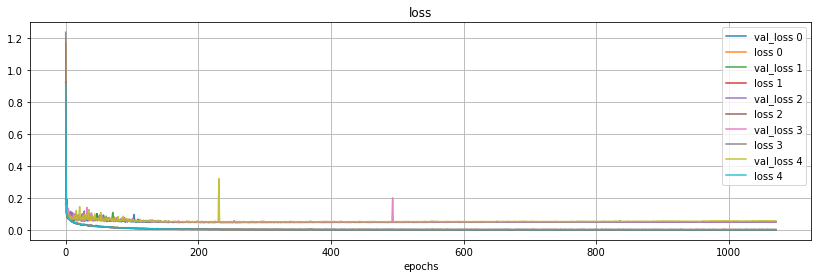

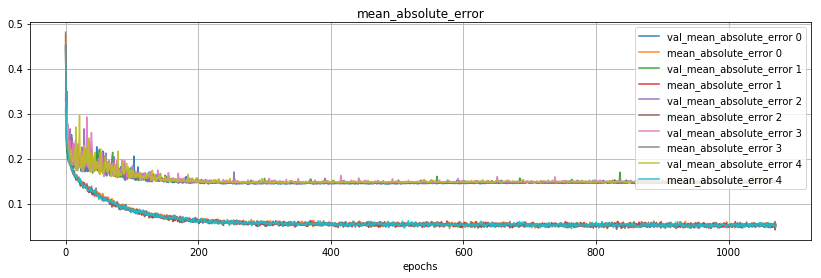

In [54]:
plot_keras_hist(hists)

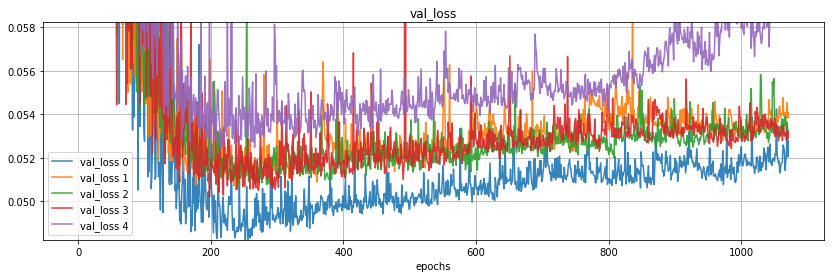

In [55]:
plot_keras_hist(hists, ylim=(min(hists[0].history['val_loss']), 
                             min(hists[0].history['val_loss'])+0.01), metrics_plot=['val_loss'])

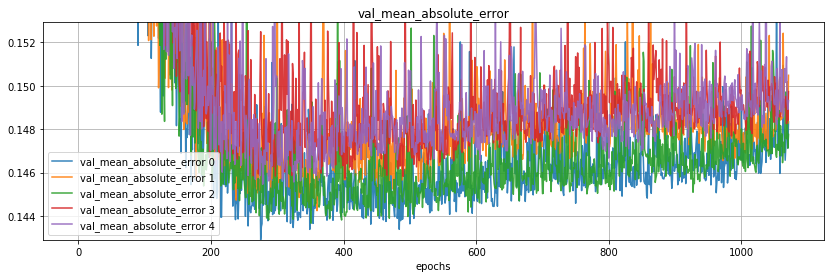

In [63]:
plot_keras_hist(hists, ylim=(min(hists[0].history['val_mean_absolute_error']), 
                             min(hists[0].history['val_mean_absolute_error'])+0.01), metrics_plot=['val_mean_absolute_error'])

### One-fold prediction

In [56]:
params['epochs'] = int(np.mean(best_iterations)*1.15)

In [57]:
params

{'batch_norm': True,
 'batch_size': 256,
 'embedding_ratio': 3,
 'epochs': 261,
 'loss': 'mse',
 'n_neurons': (3548, 3548, 1774, 1774, 887, 887)}

In [74]:
def concate_keras_hists(hist1, hist2):
    ''' Concate two keras history objects '''
    if hist1 is not None:
        for m in hist2.history:
            hist2.history[m] = hist1.history[m] + hist2.history[m]
        hist2.epoch = hist1.epoch + hist2.epoch
    return hist2

In [58]:
df_train = train.copy()
df_test = test.copy()

# Feature eng
feat_eng = FeatureEngineering(cols_num=cols_num, 
                              cols_cat=cols_cat, 
                              cols_bin=cols_bin, 
                              col_target=col_target, 
                              fillna_values=fillna_values, 
                              cols_right_skew=cols_right_skew,
                              is_embedding=is_embedding, 
                              is_tar_encoded=is_tar_encoded,
                              rare_village_threshold=rare_village_threshold, 
                              rare_town_threshold=rare_town_threshold,)
df_train = feat_eng.fit_transform(df_train, df_test)
df_test = feat_eng.transform(df_test)

# Construct X y matrices
if is_embedding:
    X_train = build_features_matrices(df_train, cols_num=cols_num+cols_tar_encoded, cols_cat=cols_cat, cols_bin=cols_bin)
    X_test = build_features_matrices(df_test, cols_num=cols_num+cols_tar_encoded, cols_cat=cols_cat, cols_bin=cols_bin)
else:
    X_train = build_features_matrices(df_train, cols_num=cols_num+cols_tar_encoded, cols_cat=[], cols_bin=cols_bin)
    X_test = build_features_matrices(df_test, cols_num=cols_num+cols_tar_encoded, cols_cat=[], cols_bin=cols_bin)
y_train = df_train[col_target+'_scaled']

# Compute network size
n_cols_num_bin = len(cols_num+cols_bin+cols_tar_encoded)
if is_embedding:
    cat_n_classes = {c: feat_eng.cat_astyper.cat_n_classes[c] for c in cols_cat}
else:
    cat_n_classes = {}
cat_embed_sizes = {c: min(int(params['embedding_ratio']*np.log(cat_n_classes[c]+1)+1), 
                          cat_n_classes[c]) for c in cat_n_classes}
print('Numerical input dims:', n_cols_num_bin)
print('Embeding  input dims:', cat_n_classes)
print('Embeding output dims:', cat_embed_sizes)
print('Total embedding output dims:', np.sum(list(cat_embed_sizes.values())))

# Build model
model = build_model(n_cols_num_bin, cat_n_classes, cat_embed_sizes, **params)

# Train model
hist = model.fit(x=X_train, y=y_train, batch_size=params['batch_size'], epochs=params['epochs'], 
                 verbose=2)

# Predict on test set
df_test[col_target+'_scaled_pred'] = model.predict(X_test, batch_size=1024)
feat_eng.target_inverse_transform(df_test, col_target+'_scaled_pred', col_target+'_pred')
df_test['total_price_pred'] = post_processing(df_test[col_target+'_pred'], df_test)

df_test_pred = pd.DataFrame({'building_id': df_test['building_id'], 
                             'total_price': df_test['total_price_pred']})
display(df_test_pred.head(20))

Numerical input dims: 138
Embeding  input dims: {'building_material': 10, 'parking_way': 4, 'city': 12, 'town': 203, 'building_type': 6, 'building_use': 11, 'encoded_latlon': 7, 'village': 2537}
Embeding output dims: {'building_material': 8, 'building_use': 8, 'city': 8, 'town': 16, 'building_type': 6, 'parking_way': 4, 'encoded_latlon': 7, 'village': 24}
Total embedding output dims: 81
Epoch 1/261
 - 21s - loss: 0.7441 - mean_absolute_error: 0.4162
Epoch 2/261
 - 15s - loss: 0.1117 - mean_absolute_error: 0.2536
Epoch 3/261
 - 15s - loss: 0.0863 - mean_absolute_error: 0.2212
Epoch 4/261
 - 15s - loss: 0.0750 - mean_absolute_error: 0.2051
Epoch 5/261
 - 15s - loss: 0.0696 - mean_absolute_error: 0.1973
Epoch 6/261
 - 15s - loss: 0.0639 - mean_absolute_error: 0.1894
Epoch 7/261
 - 15s - loss: 0.0625 - mean_absolute_error: 0.1874
Epoch 8/261
 - 15s - loss: 0.0596 - mean_absolute_error: 0.1825
Epoch 9/261
 - 15s - loss: 0.0572 - mean_absolute_error: 0.1799
Epoch 10/261
 - 15s - loss: 0.0542

Epoch 121/261
 - 15s - loss: 0.0097 - mean_absolute_error: 0.0747
Epoch 122/261
 - 15s - loss: 0.0096 - mean_absolute_error: 0.0728
Epoch 123/261
 - 15s - loss: 0.0098 - mean_absolute_error: 0.0742
Epoch 124/261
 - 15s - loss: 0.0097 - mean_absolute_error: 0.0735
Epoch 125/261
 - 15s - loss: 0.0093 - mean_absolute_error: 0.0726
Epoch 126/261
 - 15s - loss: 0.0087 - mean_absolute_error: 0.0711
Epoch 127/261
 - 15s - loss: 0.0080 - mean_absolute_error: 0.0679
Epoch 128/261
 - 15s - loss: 0.0082 - mean_absolute_error: 0.0669
Epoch 129/261
 - 15s - loss: 0.0084 - mean_absolute_error: 0.0690
Epoch 130/261
 - 15s - loss: 0.0083 - mean_absolute_error: 0.0694
Epoch 131/261
 - 15s - loss: 0.0089 - mean_absolute_error: 0.0709
Epoch 132/261
 - 15s - loss: 0.0077 - mean_absolute_error: 0.0665
Epoch 133/261
 - 15s - loss: 0.0091 - mean_absolute_error: 0.0727
Epoch 134/261
 - 15s - loss: 0.0099 - mean_absolute_error: 0.0738
Epoch 135/261
 - 15s - loss: 0.0084 - mean_absolute_error: 0.0686
Epoch 136/

 - 15s - loss: 0.0049 - mean_absolute_error: 0.0541
Epoch 246/261
 - 15s - loss: 0.0053 - mean_absolute_error: 0.0558
Epoch 247/261
 - 15s - loss: 0.0054 - mean_absolute_error: 0.0556
Epoch 248/261
 - 15s - loss: 0.0068 - mean_absolute_error: 0.0638
Epoch 249/261
 - 15s - loss: 0.0060 - mean_absolute_error: 0.0601
Epoch 250/261
 - 15s - loss: 0.0054 - mean_absolute_error: 0.0564
Epoch 251/261
 - 15s - loss: 0.0057 - mean_absolute_error: 0.0595
Epoch 252/261
 - 15s - loss: 0.0054 - mean_absolute_error: 0.0558
Epoch 253/261
 - 15s - loss: 0.0051 - mean_absolute_error: 0.0555
Epoch 254/261
 - 15s - loss: 0.0054 - mean_absolute_error: 0.0573
Epoch 255/261
 - 15s - loss: 0.0058 - mean_absolute_error: 0.0584
Epoch 256/261
 - 15s - loss: 0.0058 - mean_absolute_error: 0.0592
Epoch 257/261
 - 15s - loss: 0.0049 - mean_absolute_error: 0.0538
Epoch 258/261
 - 15s - loss: 0.0053 - mean_absolute_error: 0.0550
Epoch 259/261
 - 15s - loss: 0.0049 - mean_absolute_error: 0.0548
Epoch 260/261
 - 15s - l

,building_id,total_price
0,X5gsdTWGS3W7JJQB,1.290643e+07
1,BTshNOJyKHnT2YIT,4.066496e+06
2,dhdymr0lV8N5kZOT,1.004198e+07
3,VEwyGGMcD56w5BOc,5.974373e+06
4,wmUeMoJZfsqaSX9b,1.066647e+06
5,EtBjGAHmHCe9t7TZ,2.589430e+06
6,hPNH34vmaZtvBtqc,1.270095e+07
7,wXjeI38bYDMJJwZC,6.066029e+06
8,fxZSGX6aPAFKU8W4,1.795246e+06
9,ewr0Fx6ign87OwaV,3.994543e+06


In [86]:
params['epochs'] = 263

In [108]:
print(hist.epoch)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

In [88]:
# Train model
hist_j = model.fit(x=X_train, y=y_train, batch_size=params['batch_size'], epochs=params['epochs'],
                   verbose=2, initial_epoch=hist.epoch[-1])

Epoch 263/263
 - 15s - loss: 0.0049 - mean_absolute_error: 0.0546


In [ ]:
print(hist_j.epoch)

In [91]:
hist = concate_keras_hists(hist, hist_j)

# Predict on test set
df_test[col_target+'_scaled_pred'] = model.predict(X_test, batch_size=1024)
feat_eng.target_inverse_transform(df_test, col_target+'_scaled_pred', col_target+'_pred')
df_test['total_price_pred'] = post_processing(df_test[col_target+'_pred'], df_test)

df_test_pred = pd.DataFrame({'building_id': df_test['building_id'], 
                             'total_price': df_test['total_price_pred']})
display(df_test_pred.head(20))

,building_id,total_price
0,X5gsdTWGS3W7JJQB,1.305066e+07
1,BTshNOJyKHnT2YIT,4.106509e+06
2,dhdymr0lV8N5kZOT,7.774622e+06
3,VEwyGGMcD56w5BOc,6.196206e+06
4,wmUeMoJZfsqaSX9b,1.078885e+06
5,EtBjGAHmHCe9t7TZ,2.686954e+06
6,hPNH34vmaZtvBtqc,1.326179e+07
7,wXjeI38bYDMJJwZC,6.024112e+06
8,fxZSGX6aPAFKU8W4,1.846650e+06
9,ewr0Fx6ign87OwaV,4.072796e+06


In [95]:
df_test_pred.to_csv('output/'+model_name+'-test-one.csv', index=False)

In [92]:
hist.params

{'batch_size': 256,
 'do_validation': False,
 'epochs': 263,
 'metrics': ['loss', 'mean_absolute_error'],
 'samples': 60000,
 'steps': None,
 'verbose': 2}

#### Hist

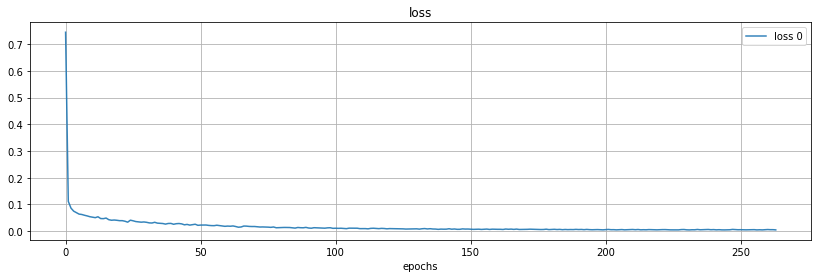

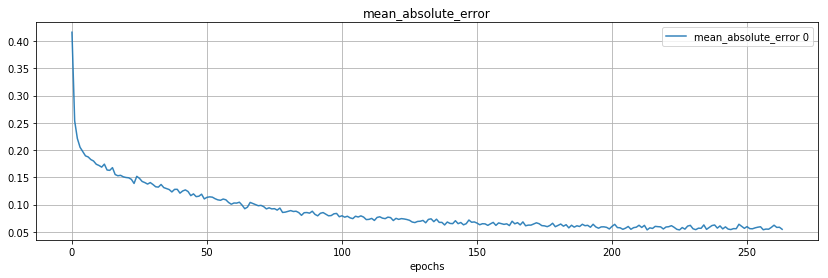

In [96]:
plot_keras_hist(hist)

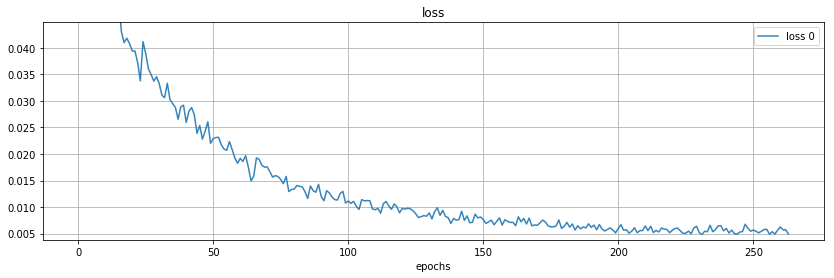

In [97]:
plot_keras_hist(hist, ylim=(min(hist.history['loss'])-0.001, 
                            min(hist.history['loss'])+0.04), metrics_plot=['loss'])

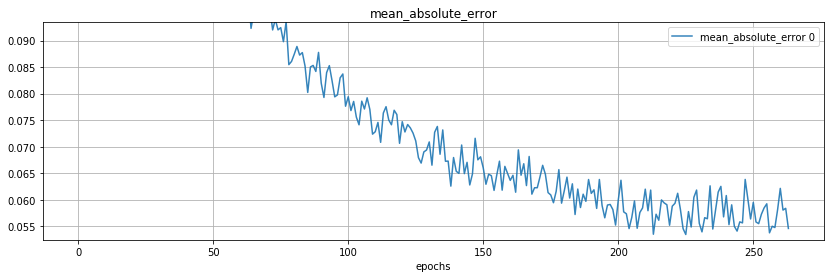

In [98]:
plot_keras_hist(hist, ylim=(min(hist.history['mean_absolute_error'])-0.001, 
                            min(hist.history['mean_absolute_error'])+0.04), metrics_plot=['mean_absolute_error'])

### Result

- Kfold cv score (mean, stdev, kfolds): 5401.4521640509365 30.849209712285113 [5416.858439460397, 5417.85637575388, 5441.85222774744, 5367.853903308511, 5362.839873984456]

Leaderboard:
- kfold: 5847.8706967139
- one: 5643.8594910442